In [1]:
import wandb
from data_loaders import make_train_data, make_test_val_data, make_model
from train import train, test
import torch
import time
import gc
import config_file
from clean_data import load_all_houses_with_device
import random
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from scipy.stats import skew
from scipy import stats
from sklearn.cluster import KMeans

In [4]:
data = [2859., 2890., 2899., 2909., 2909., 2912., 2912., 2911., 2912., 2888., 2822., 2826.,
 2830., 2831., 2833., 2833., 2834., 2834., 2832., 2833., 2833., 2831., 2831., 2826.,
 2827., 2829., 2838., 2841., 2839., 2982., 3025., 3012., 3014., 3016., 3016., 3017.,
 3017., 2983., 2925., 2926., 2925., 2925., 2923., 2917., 2915., 2921., 2921., 2924.,
 2918., 2908., 2916., 2917., 2918., 3023., 3040., 3048., 3040., 3039., 3039., 3040.,
 3050., 3029., 3025., 3025., 3030., 3040., 3135., 3098., 3033., 3034., 3033., 3033.,
 3039., 3037., 2985., 2949., 2974., 2971., 2920., 2888., 2895., 2909., 2965., 2981.,
 2998., 2999., 2978., 2975., 2979., 2980., 3056., 3087., 3083., 3084., 3083., 3078.,
 3081., 3088., 2982., 2435., 2432., 2426., 2425., 2423., 2418., 2325., 2324., 2324.,
 2327., 2326., 2363., 2429., 2424., 2419., 2419., 2420., 2418., 2417., 2411., 2409.,
 2416., 2422., 2424., 2422., 2419., 2364., 2328., 2329., 2329., 2329., 2328., 2328.,
 2326., 2277., 2239., 2255.]

(array([12., 11., 14.,  0.,  0.,  0., 20., 29., 38., 12.]),
 array([2239. , 2328.6, 2418.2, 2507.8, 2597.4, 2687. , 2776.6, 2866.2,
        2955.8, 3045.4, 3135. ]),
 <BarContainer object of 10 artists>)

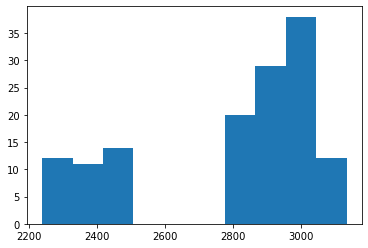

In [17]:
plt.hist(data)

(array([17., 20.,  0.,  0.,  0., 16., 18., 27., 29.,  9.]),
 array([   0.        ,  439.39406996,  878.78813992, 1318.18220987,
        1757.57627983, 2196.97034979, 2636.36441975, 3075.75848971,
        3515.15255966, 3954.54662962, 4393.94069958]),
 <BarContainer object of 10 artists>)

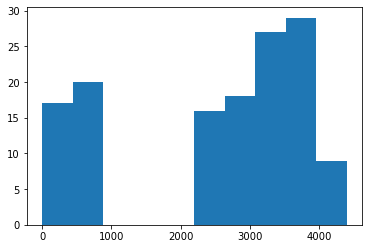

In [18]:
plt.hist(stats.boxcox(np.add(data, -2238))[0])

In [19]:
appliance_dict = {"air1":"compressor",
                  "air2": "compressor",
                  "air3": "compressor",
                  "airwindowunit1":"air conditioner",
                  "aquarium1":"water pump",
                  "bathroom1":"sockets",
                  "bathroom2":"sockets",
                  "bedroom1":"sockets",
                  "bedroom2":"sockets",
                  "bedroom3":"sockets",
                  "bedroom4":"sockets",
                  "bedroom5":"sockets",
                  "battery1":"unknown",
                  "car1":"electric vehicle",
                  "car2":"electric vehicle",
                  "circpump1":"water pump",
                  "clotheswasher1":"washing machine",
                  "clotheswasher_dryg1":"washer dryer",
                  "diningroom1":"sockets",
                  "diningroom2":"sockets",
                  "dishwasher1":"dish washer",
                  "disposal1":"waste disposal unit",
                  "drye1":"tumble dryer",
                  "dryg1":"tumble dryer",
                  "freezer1":"freezer",
                  "furnace1":"electric furnace",
                  "furnace2":"electric furnace",
                  "garage1":"sockets",
                  "garage2":"sockets",
                  "heater1":"heating appliance",
                  "heater2":"heating appliance",
                  "heater3":"heating appliance",
                  "housefan1":"fan",
                  "icemaker1":"cold appliance",
                  "jacuzzi1":"jacuzzi pump",
                  "kitchen1":"sockets",
                  "kitchen2":"sockets",
                  "kitchenapp1":"sockets",
                  "kitchenapp2":"sockets",
                  "lights_plugs1":"light",
                  "lights_plugs2":"light",
                  "lights_plugs3":"light",
                  "lights_plugs4":"light",
                  "lights_plugs5":"light",
                  "lights_plugs6":"light",
                  "livingroom1":"sockets",
                  "livingroom2":"sockets",
                  "microwave1":"microwave",
                  "office1":"sockets",
                  "outsidelights_plugs1":"lighting component",
                  "outsidelights_plugs2":"lighting component",
                  "oven1":"oven",
                  "oven2":"oven",
                  "pool1":"electric swimming pool heater",
                  "pool2":"electric swimming pool heater",
                  "poollight1":"lighting component",
                  "poolpump1":"swimming pool pump",
                  "pump1":"water pump",
                  "range1":"stove",
                  "refrigerator1":"fridge",
                  "refrigerator2":"fridge",
                  "security1":"security alarm",
                  "sewerpump1":"water pump",
                  "shed1":"sockets",
                  "sprinkler1":"garden sprinkler",
                  "sumppump1":"water pump",
                  "utilityroom1":"subpanel",
                  "venthood1":"fan",
                  "waterheater1":"electric water heater",
                  "waterheater2":"electric water heater",
                  "wellpump1":"water pump",
                  "winecooler1":"cold appliance"
                 }

In [20]:
path = r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\input\1min_real_sept_oct_nov2019.csv"

In [21]:
df = pd.read_csv(path, index_col=0)

C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [22]:
df = df.fillna(0)

In [23]:
wanted = {'dataid', 'grid', 'solar', 'solar2'}

In [24]:
grid = df.drop(columns=[x for x in df.columns if x not in wanted])

In [25]:
grid = grid*1000
grid.dataid = grid.dataid/1000
grid.dataid = grid.dataid.astype('int32')

In [26]:
df = df.drop(columns=['localminute', 'leg1v', 'leg2v', 'grid', 'solar', 'solar2'])

In [27]:
df = df*1000

In [28]:
df.dataid = df.dataid/1000

In [29]:
df.dataid = df.dataid.astype('int32')

In [30]:
len(df)

12706308

In [31]:
df_new = df.groupby(df.dataid).sum()

<AxesSubplot:ylabel='dataid'>

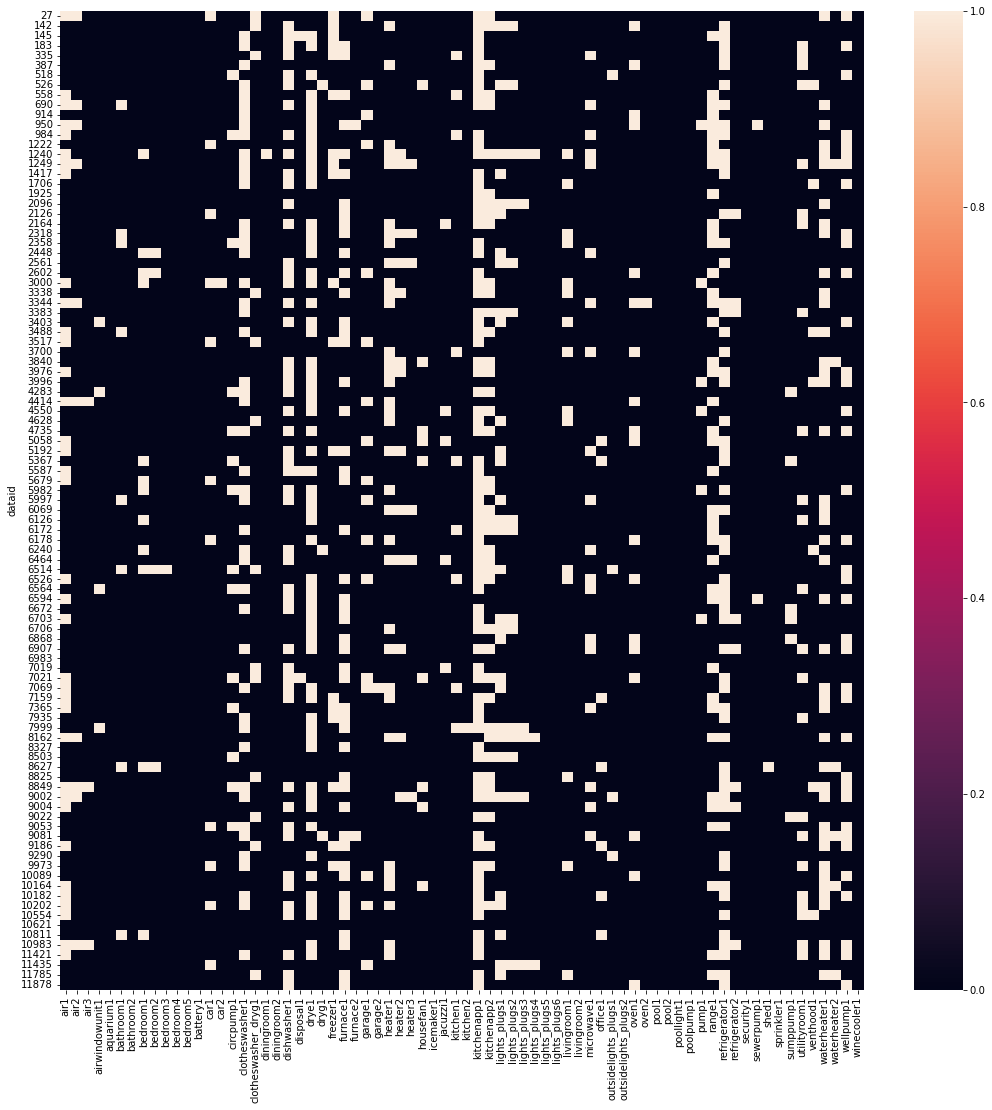

In [32]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(df_new.where(df_new == 0, 1), xticklabels=True, yticklabels=True, ax=ax)

In [33]:
app_distribution = pd.DataFrame([df_new.columns, np.count_nonzero(df_new, axis=0)/df_new.shape[0]]).transpose()

In [34]:
app_distribution = app_distribution.sort_values(by=[1], ascending=False).reset_index(drop=True)

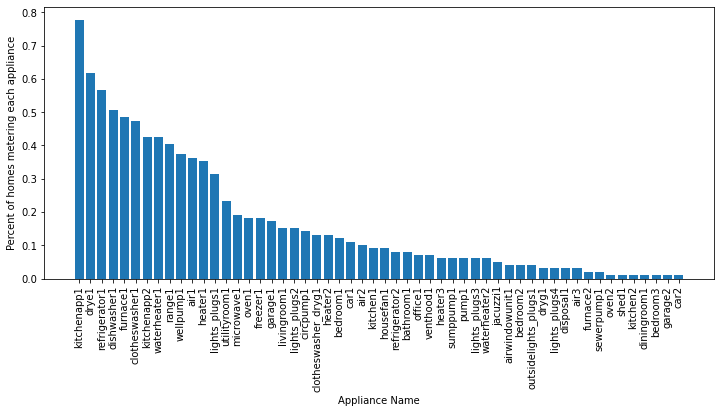

In [35]:
#plot to show the percent of buildings that contain each appliance type
plt.figure(figsize=(12,5))
plt.bar(app_distribution[0][0:54], app_distribution[1][0:54])
plt.xticks(rotation=90)
plt.xlabel("Appliance Name")
plt.ylabel("Percent of homes metering each appliance")
plt.savefig('appliance_percents.png')

In [36]:
appliances_per_building = pd.DataFrame([df_new.index, np.count_nonzero(df_new, axis=1)]).transpose()

In [37]:
appliances_per_building = appliances_per_building.sort_values(by=[1], ascending=False).reset_index(drop=True)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

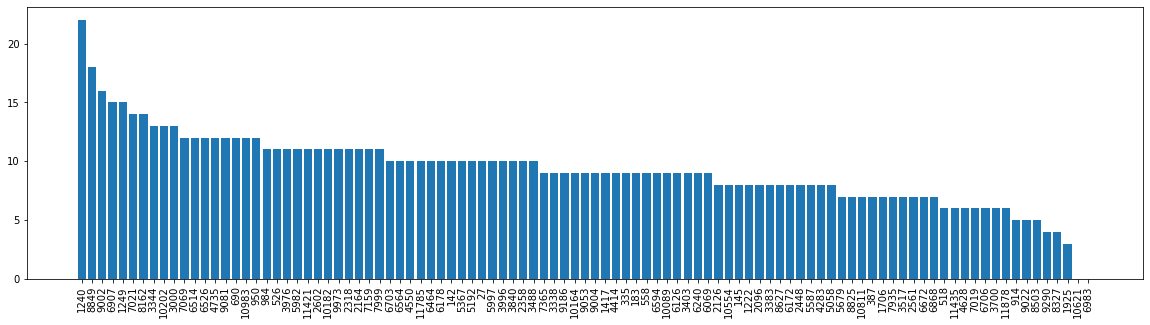

In [38]:
#plot to show how many appliances each building is metering
plt.figure(figsize=(20,5))
plt.bar(appliances_per_building[0].astype('str'), appliances_per_building[1])
plt.xticks(rotation=90)

In [39]:
grid['total_grid'] = grid['grid'] + grid['solar'] + grid['solar2']

In [40]:
grid.groupby(grid.dataid).sum()

grid        solar  solar2   total_grid
dataid                                               
27      -19243432.0  180202437.0     0.0  160959005.0
142       3228340.0   83888802.0     0.0   87117142.0
145      51496622.0          0.0     0.0   51496622.0
183      37599064.0   27837926.0     0.0   65436990.0
335      62268759.0   50782179.0     0.0  113050938.0
...             ...          ...     ...          ...
10983    -9134004.0   82309193.0     0.0   73175189.0
11421   124532904.0  145207471.0     0.0  269740375.0
11435    27085168.0          0.0     0.0   27085168.0
11785    85670931.0   88175728.0     0.0  173846659.0
11878   -90814060.0  173027398.0     0.0   82213338.0

[99 rows x 4 columns]

In [41]:
grid['total_grid'] = grid['total_grid'].mask(grid['total_grid'] > 30000, 0)

In [42]:
grid['total_grid'] = grid['total_grid'].mask(grid['total_grid'] < 0, 0)

In [43]:
df_new

air1        air2      air3  airwindowunit1  aquarium1  \
dataid                                                                
27      41485272.0  11523179.0       0.0             0.0        0.0   
142            0.0         0.0       0.0             0.0        0.0   
145            0.0         0.0       0.0             0.0        0.0   
183            0.0         0.0       0.0             0.0        0.0   
335            0.0         0.0       0.0             0.0        0.0   
...            ...         ...       ...             ...        ...   
10983      79653.0    262285.0  376477.0             0.0        0.0   
11421   20301239.0         0.0       0.0             0.0        0.0   
11435          0.0         0.0       0.0             0.0        0.0   
11785          0.0         0.0       0.0             0.0        0.0   
11878          0.0         0.0       0.0             0.0        0.0   

        bathroom1  bathroom2  bedroom1  bedroom2  bedroom3  ...  sewerpump1  \
dataid                                                      ...               
27            0.0        0.0       0.0       0.0       0.0  ...         0.0   
142           0.0        0.0       0.0       0.0       0.0  ...         0.0   
145           0.0        0.0       0.0       0.0       0.0  ...         0.0   
183           0.0        0.0       0.0       0.0       0.0  ...         0.0   
335           0.0        0.0       0.0       0.0       0.0  ...         0.0   
...           ...        ...       ...       ...       ...  ...         ...   
10983         0.0        0.0       0.0       0.0       0.0  ...         0.0   
11421         0.0        0.0       0.0       0.0       0.0  ...         0.0   
11435         0.0        0.0       0.0       0.0       0.0  ...         0.0   
11785         0.0        0.0       0.0       0.0       0.0  ...         0.0   
11878         0.0        0.0       0.0       0.0       0.0  ...         0.0   

        shed1  sprinkler1  sumppump1  utilityroom1  venthood1  waterheater1  \
dataid                                                                        
27        0.0         0.0        0.0           0.0        0.0     9493163.0   
142       0.0         0.0        0.0           0.0        0.0           0.0   
145       0.0         0.0        0.0           0.0        0.0           0.0   
183       0.0         0.0        0.0     3639481.0        0.0           0.0   
335       0.0         0.0        0.0    13185247.0        0.0           0.0   
...       ...         ...        ...           ...        ...           ...   
10983     0.0         0.0        0.0     5341141.0        0.0     1823706.0   
11421     0.0         0.0        0.0    45019787.0        0.0    12040757.0   
11435     0.0         0.0        0.0           0.0        0.0           0.0   
11785     0.0         0.0        0.0           0.0        0.0    11131073.0   
11878     0.0         0.0        0.0           0.0        0.0           0.0   

        waterheater2  wellpump1  winecooler1  
dataid                                        
27               0.0   788642.0          0.0  
142              0.0        0.0          0.0  
145              0.0        0.0          0.0  
183              0.0   465823.0          0.0  
335              0.0        0.0          0.0  
...              ...        ...          ...  
10983            0.0   510091.0          0.0  
11421            0.0  6261923.0          0.0  
11435            0.0        0.0          0.0  
11785      2804363.0        0.0          0.0  
11878            0.0  1155614.0          0.0  

[99 rows x 72 columns]

In [44]:
app_power_percents = df_new.div(grid.groupby(grid.dataid).sum().total_grid.values, axis=0)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

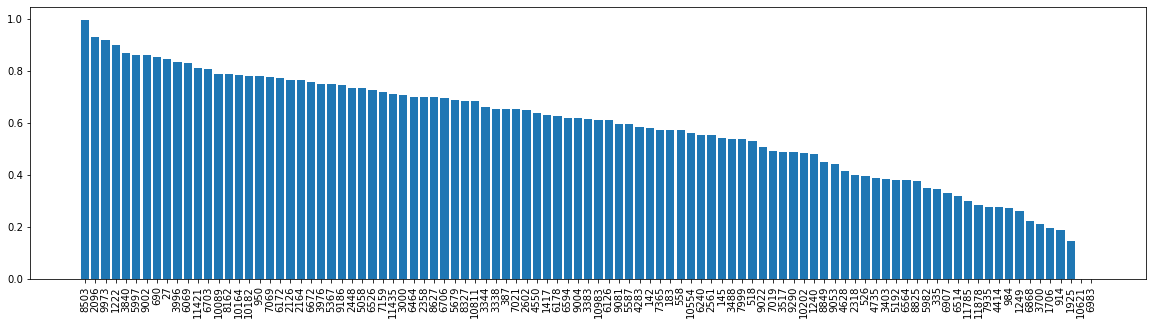

In [45]:
#plot to show percent of total power that each house is submetering
plt.figure(figsize=(20,5))
plt.bar(app_power_percents.sum(axis=1).sort_values(ascending=False).index.astype('str'), app_power_percents.sum(axis=1).sort_values(ascending=False).values)
plt.xticks(rotation=90)

In [46]:
app_power_percents.sum(axis=1).sort_values(ascending=False).index.astype('str')

Index(['8503', '2096', '9973', '1222', '3840', '5997', '9002', '690', '27',
       '3996', '6069', '11421', '6703', '10089', '8162', '10164', '10182',
       '950', '7069', '6172', '2126', '2164', '6672', '3976', '5367', '9186',
       '2448', '5058', '6526', '7159', '11435', '3000', '6464', '2358', '8627',
       '6706', '5679', '8327', '10811', '3344', '3338', '387', '7021', '2602',
       '4550', '1417', '6178', '6594', '9004', '3383', '10983', '6126', '9081',
       '5587', '4283', '142', '7365', '183', '558', '10554', '6240', '2561',
       '145', '3488', '7999', '518', '9022', '7019', '3517', '9290', '10202',
       '1240', '8849', '9053', '4628', '2318', '526', '4735', '3403', '5192',
       '6564', '8825', '5982', '335', '6907', '6514', '11785', '11878', '7935',
       '4414', '984', '1249', '6868', '3700', '1706', '914', '1925', '10621',
       '6983'],
      dtype='object', name='dataid')

In [47]:
df_avg = df.groupby(df.dataid).mean()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(

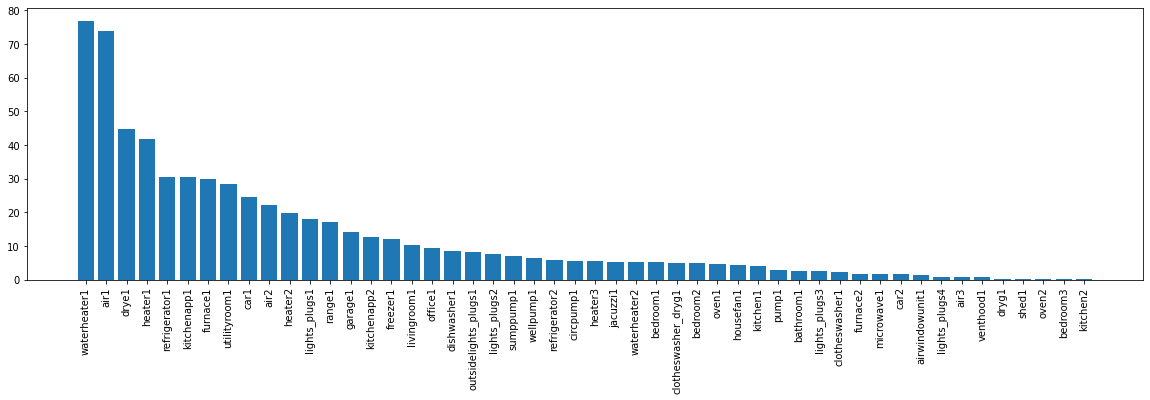

In [48]:
#average power consumption by appliance
plt.figure(figsize=(20,5))
plt.bar(df_avg.mean(axis=0).sort_values(ascending=False).index[0:50], df_avg.mean(axis=0).sort_values(ascending=False).values[0:50])
plt.xticks(rotation=90)

In [49]:
app_distribution_new = pd.DataFrame([df_new.columns, np.count_nonzero(df_new, axis=0)/df_new.shape[0]]).transpose()

In [50]:
app_distribution_new

0         1
0             air1  0.363636
1             air2   0.10101
2             air3  0.030303
3   airwindowunit1  0.040404
4        aquarium1       0.0
..             ...       ...
67       venthood1  0.070707
68    waterheater1  0.424242
69    waterheater2  0.060606
70       wellpump1  0.373737
71     winecooler1       0.0

[72 rows x 2 columns]

In [51]:
app_distribution_new[1] = app_distribution_new[1]*df_avg.mean(axis=0).values

In [52]:
app_distribution_new = app_distribution_new.sort_values(by=1,ascending=False).reset_index(drop=True)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

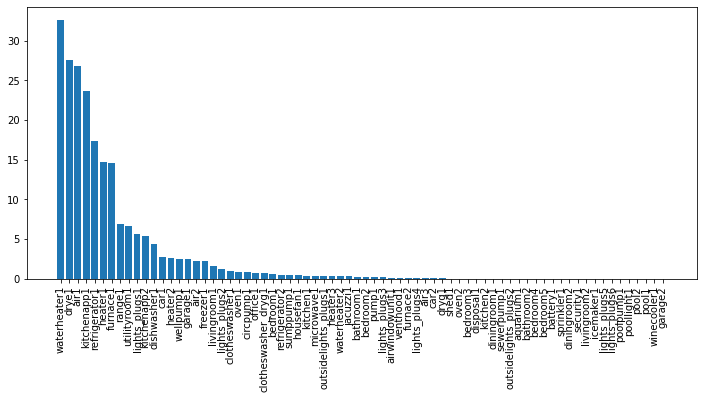

In [53]:
#plot showing average power consumption * percent of buildings containing each appliance
plt.figure(figsize=(12,5))
plt.bar(app_distribution_new[0], app_distribution_new[1])
plt.xticks(rotation=90)

In [54]:
lengths = df.pivot_table(columns=['dataid'], aggfunc='size').sort_values(ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

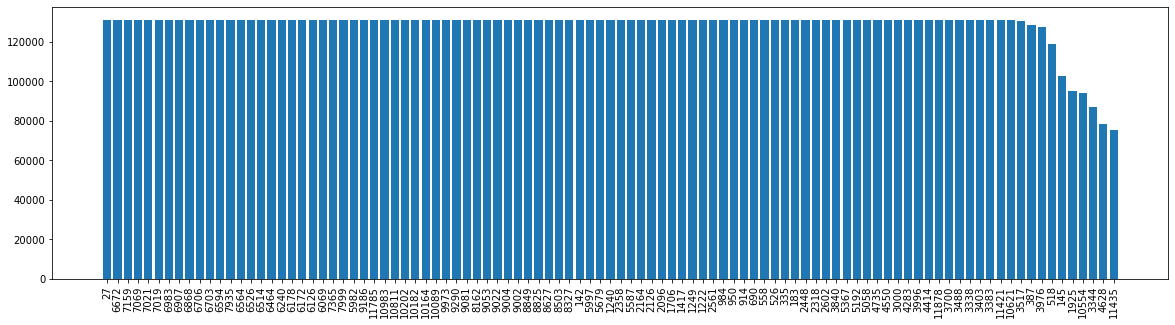

In [55]:
#dataset lengths for each home
plt.figure(figsize=(20,5))
plt.bar(lengths.index.astype('str'), lengths.values)
plt.xticks(rotation=90)

In [56]:
total_grid_power = grid.groupby(grid.dataid).sum().sort_values(by='total_grid', ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

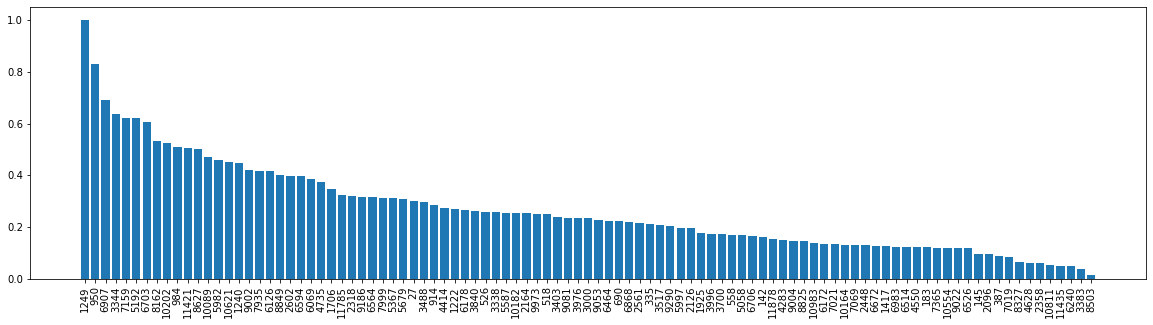

In [57]:
#normalized total power consumption for all houses
plt.figure(figsize=(20,5))
plt.bar(total_grid_power.index.astype('str'), 
         (total_grid_power.total_grid/max(total_grid_power.total_grid)).values)
plt.xticks(rotation=90)

<ipython-input-58-76bac4f716df>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

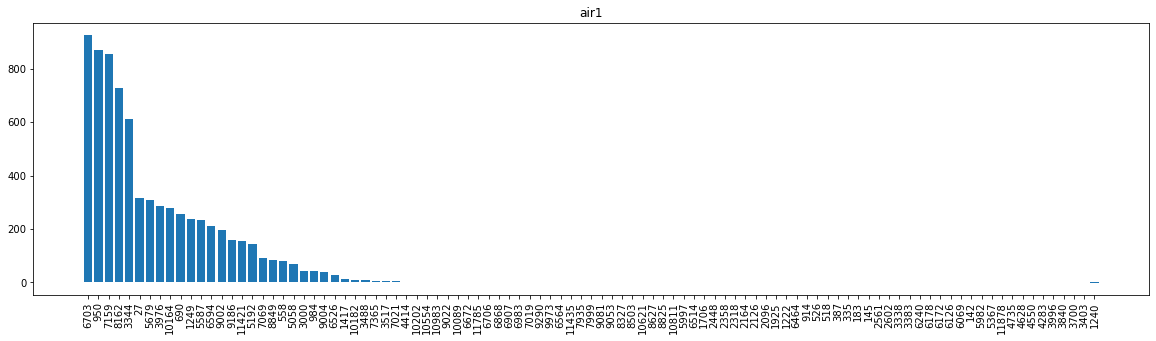

<Figure size 432x288 with 0 Axes>

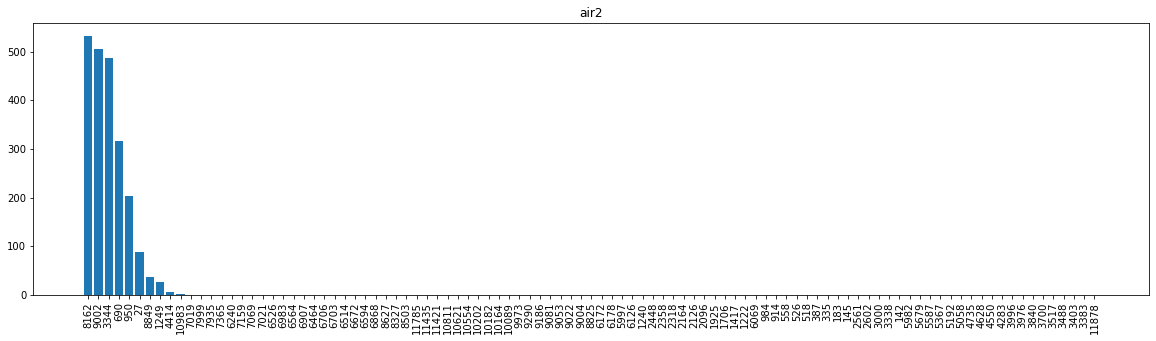

<Figure size 432x288 with 0 Axes>

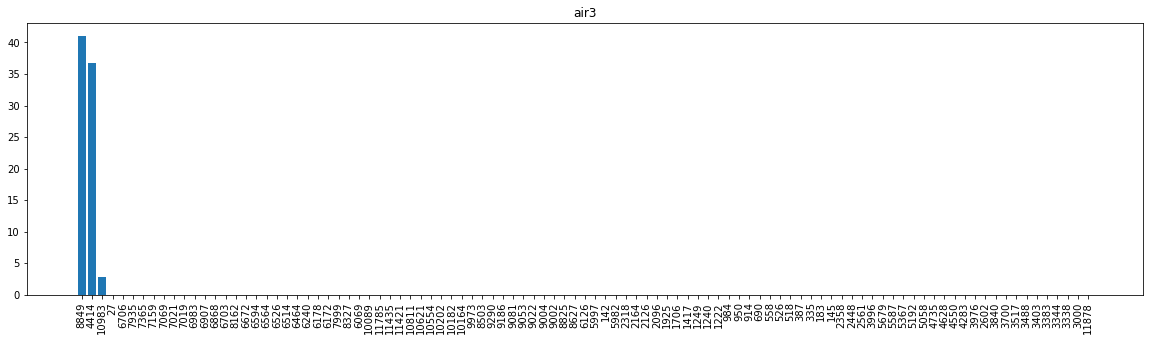

<Figure size 432x288 with 0 Axes>

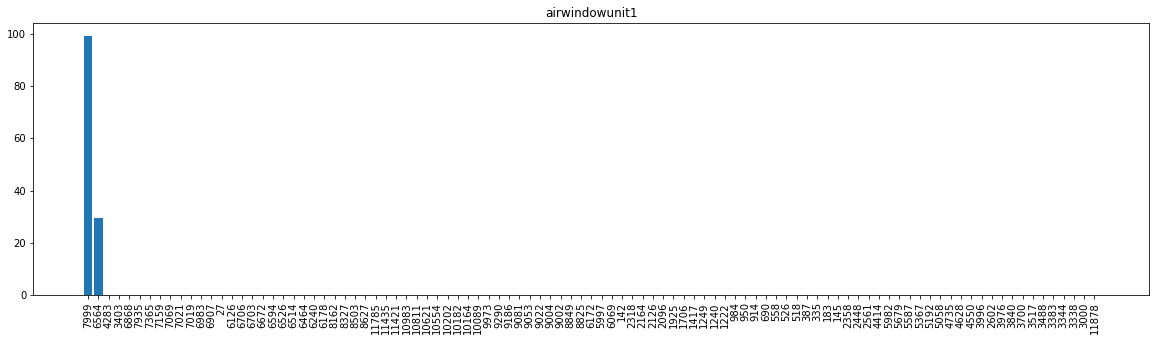

<Figure size 432x288 with 0 Axes>

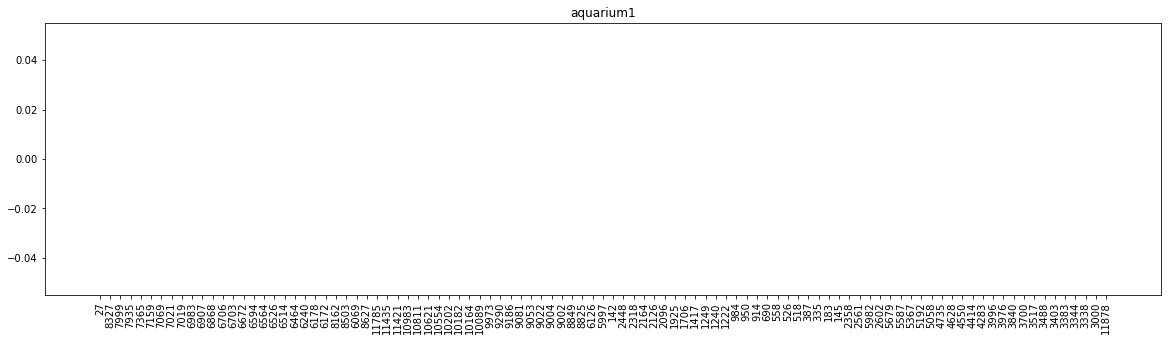

<Figure size 432x288 with 0 Axes>

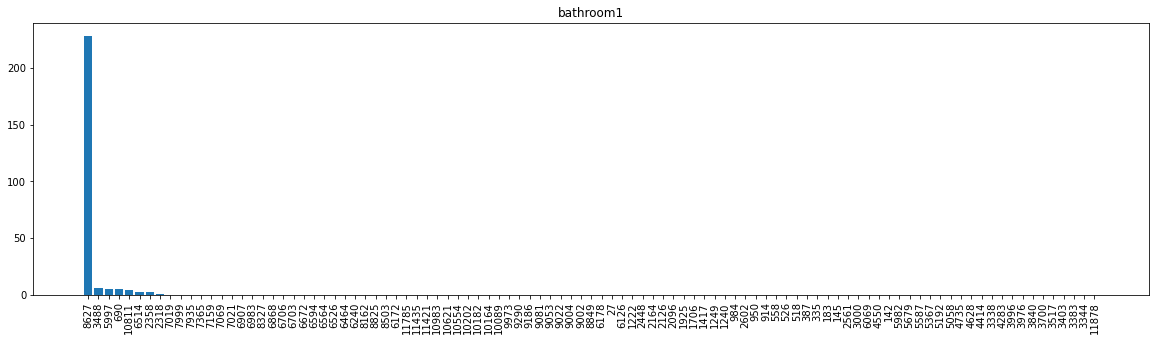

<Figure size 432x288 with 0 Axes>

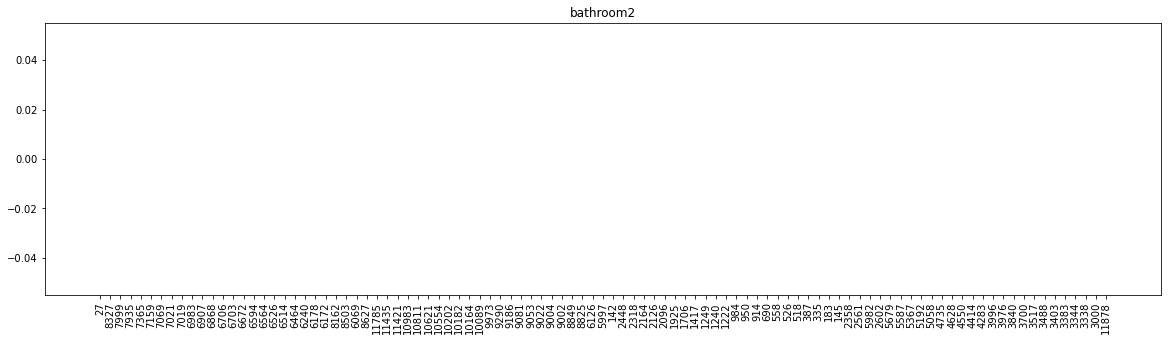

<Figure size 432x288 with 0 Axes>

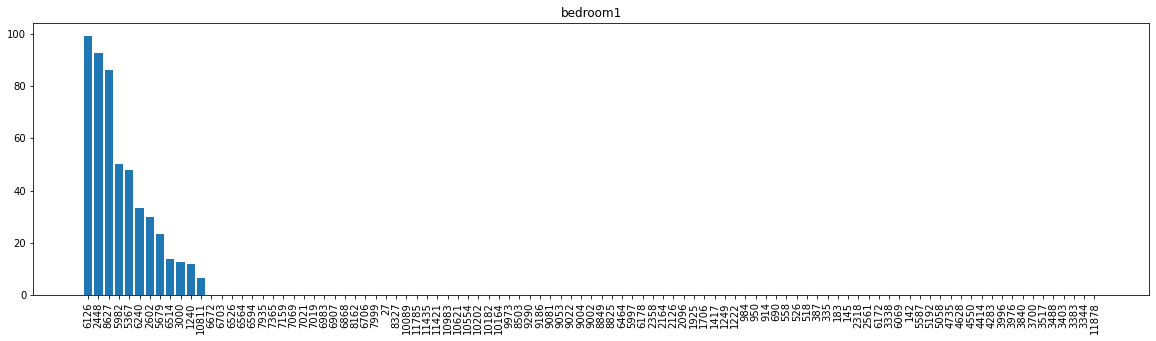

<Figure size 432x288 with 0 Axes>

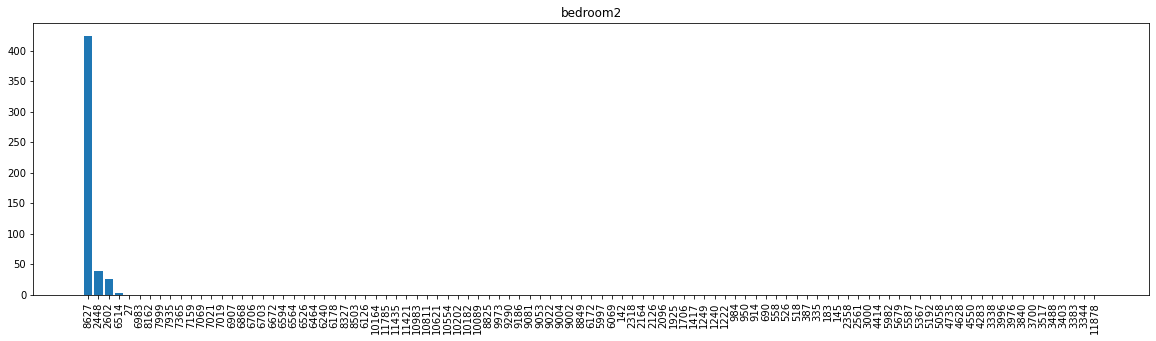

<Figure size 432x288 with 0 Axes>

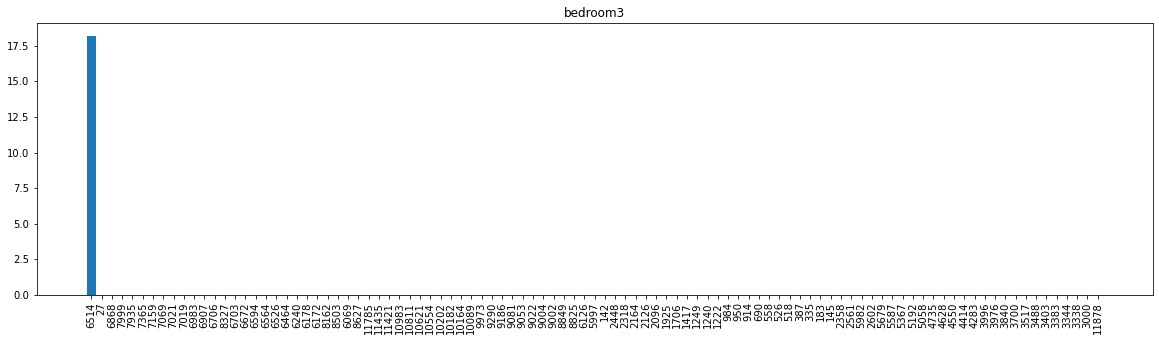

<Figure size 432x288 with 0 Axes>

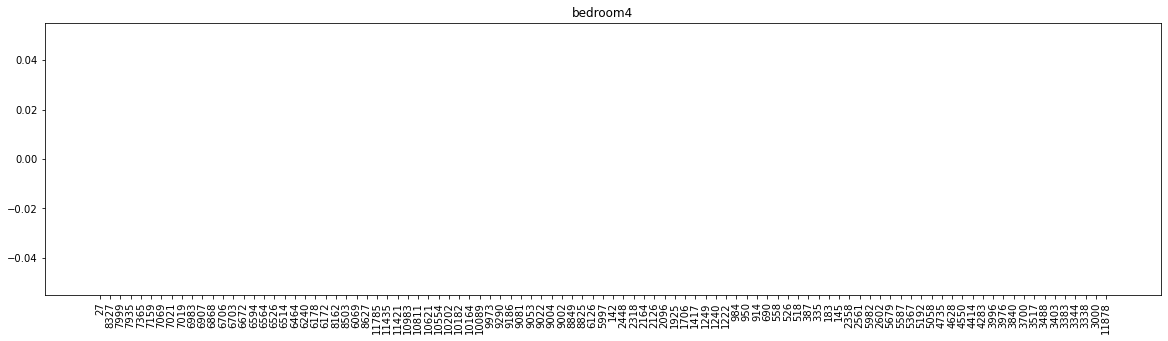

<Figure size 432x288 with 0 Axes>

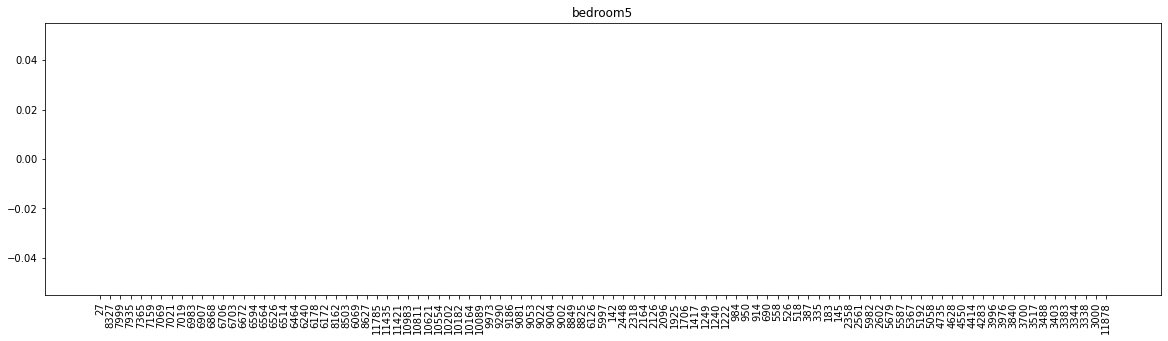

<Figure size 432x288 with 0 Axes>

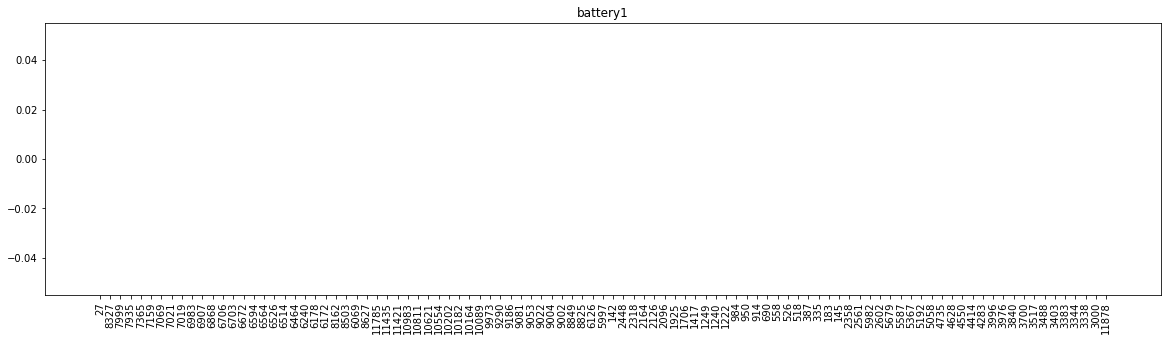

<Figure size 432x288 with 0 Axes>

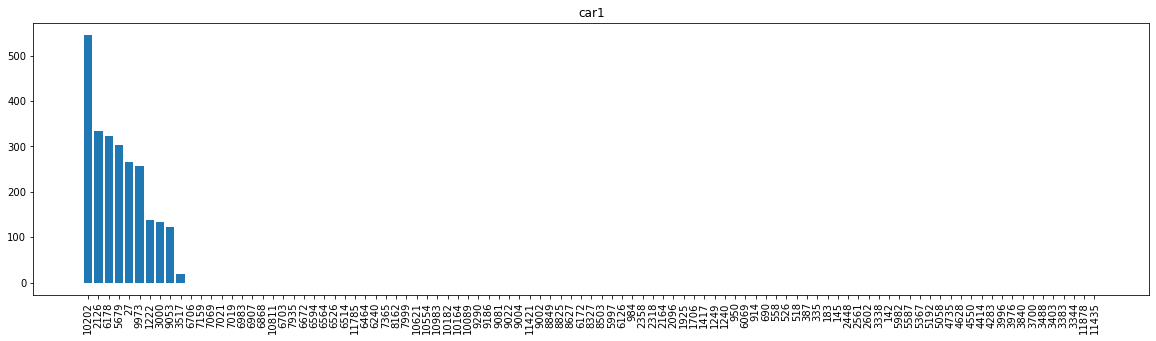

<Figure size 432x288 with 0 Axes>

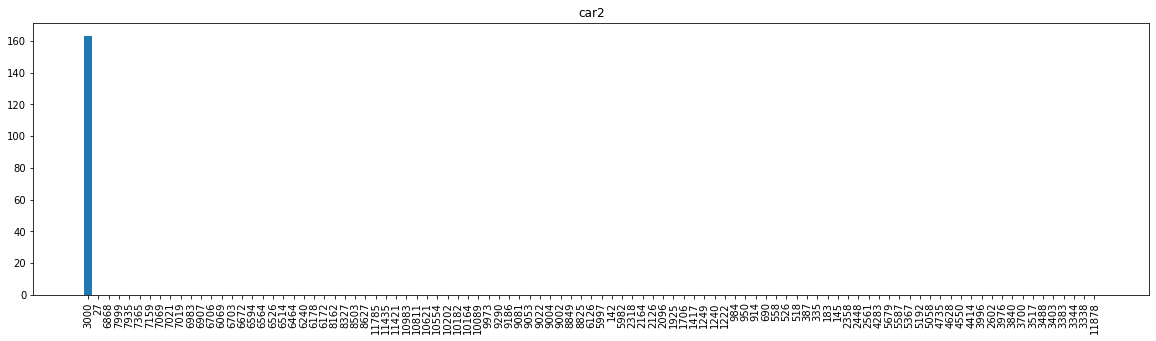

<Figure size 432x288 with 0 Axes>

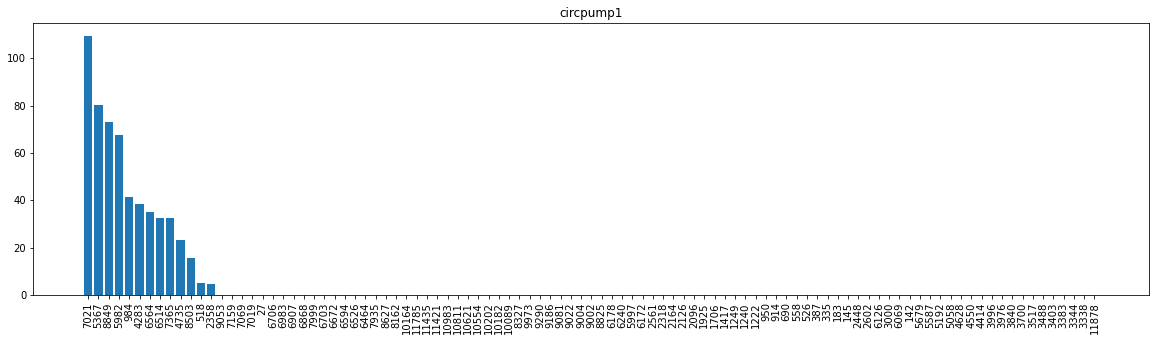

<Figure size 432x288 with 0 Axes>

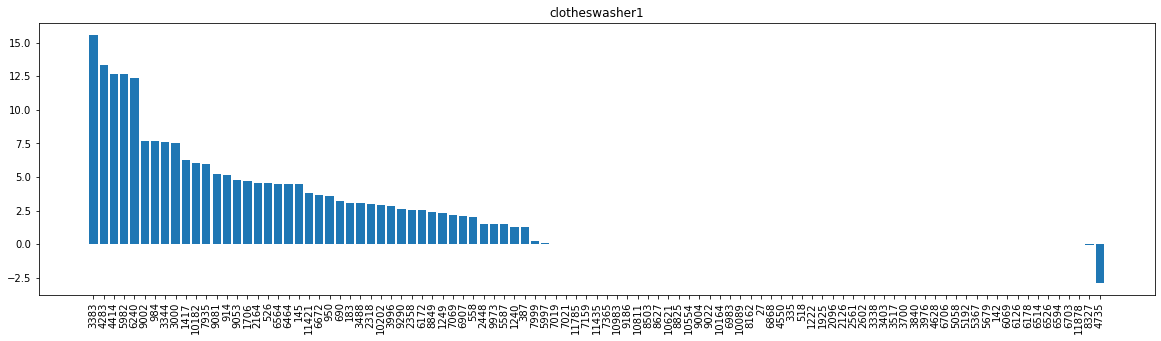

<Figure size 432x288 with 0 Axes>

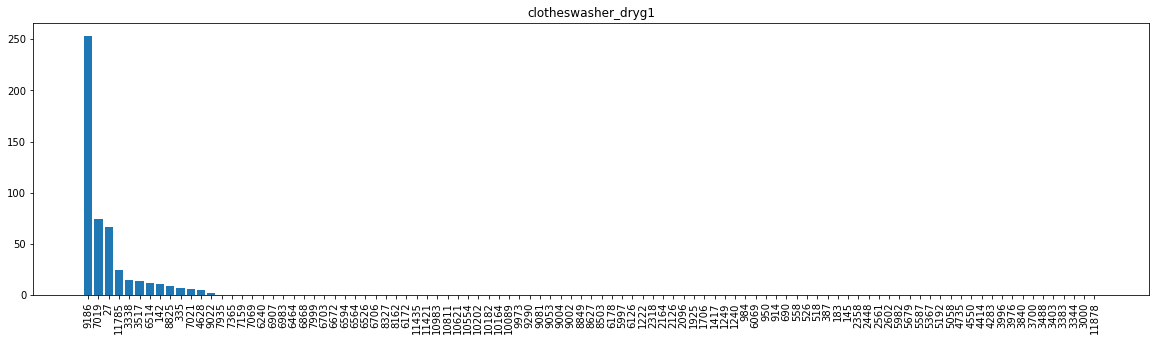

<Figure size 432x288 with 0 Axes>

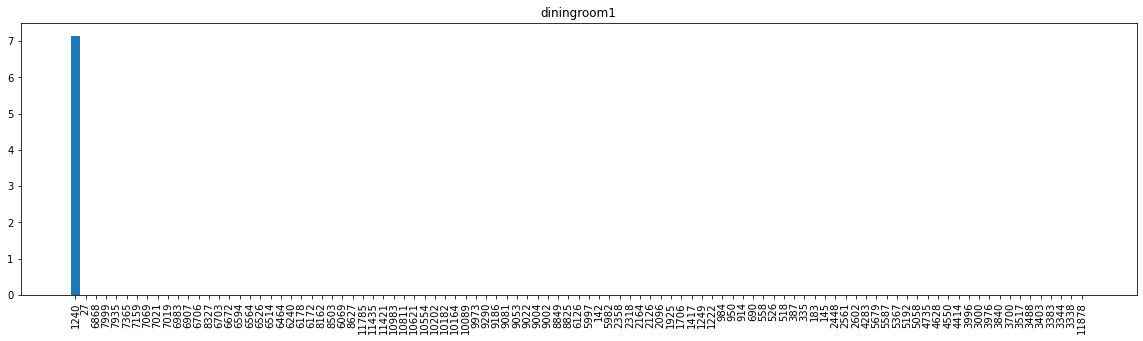

<Figure size 432x288 with 0 Axes>

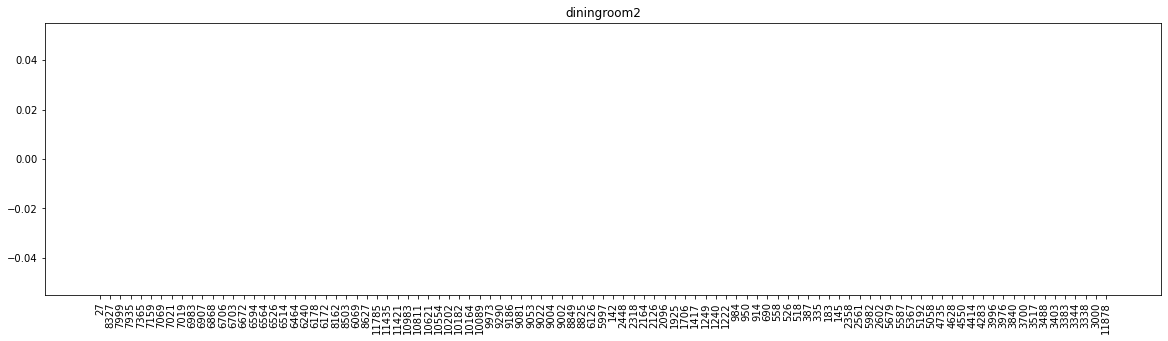

<Figure size 432x288 with 0 Axes>

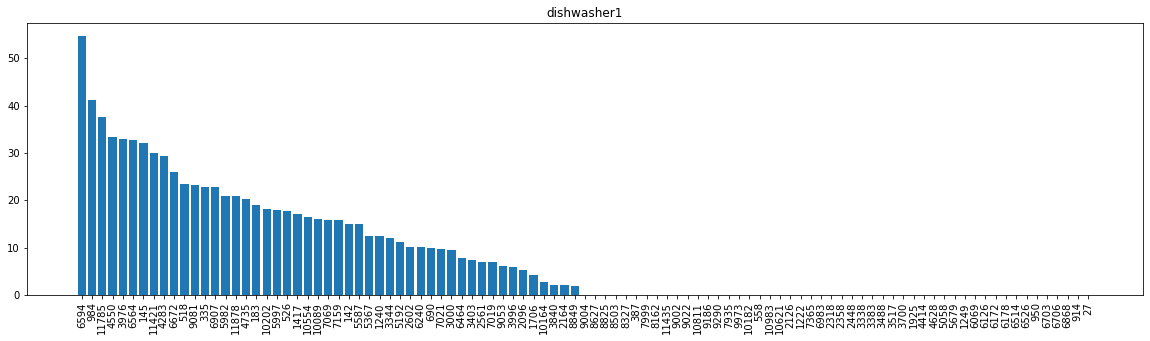

<Figure size 432x288 with 0 Axes>

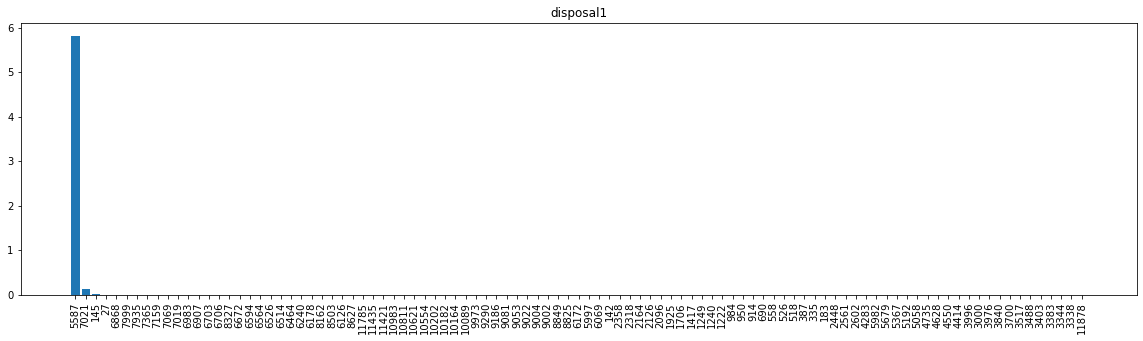

<Figure size 432x288 with 0 Axes>

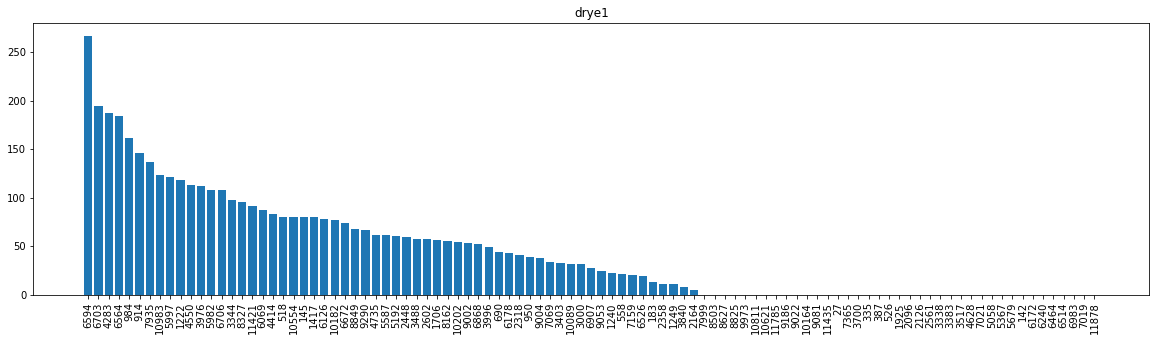

<Figure size 432x288 with 0 Axes>

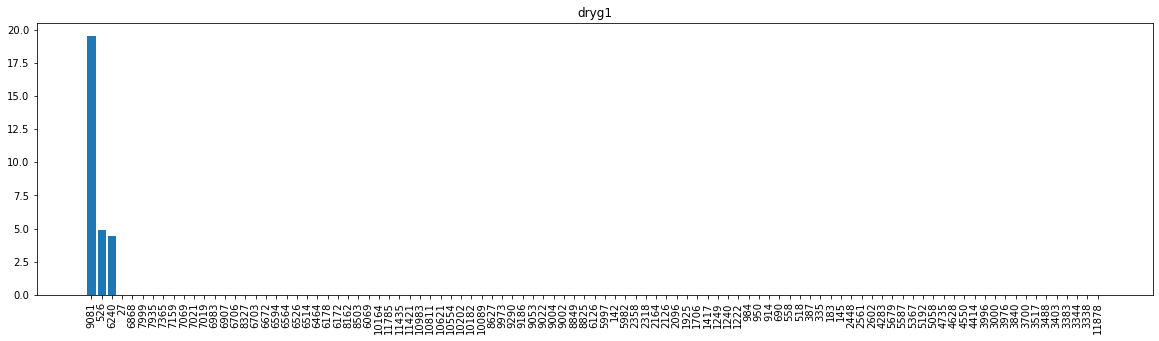

<Figure size 432x288 with 0 Axes>

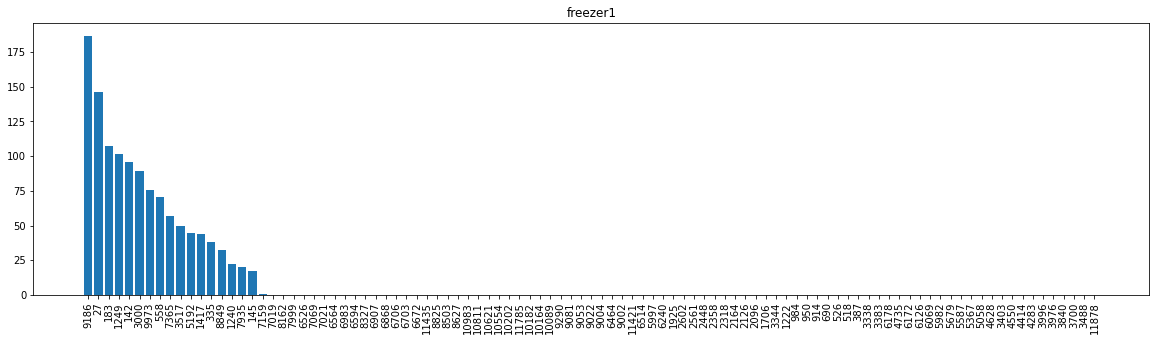

<Figure size 432x288 with 0 Axes>

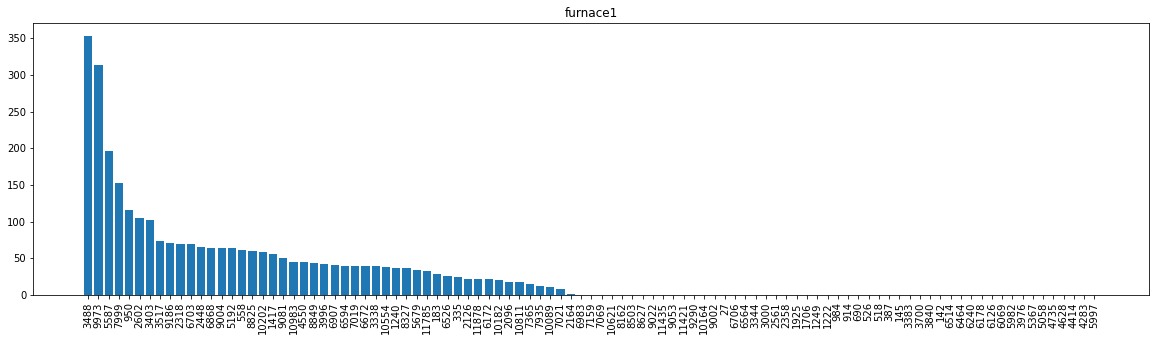

<Figure size 432x288 with 0 Axes>

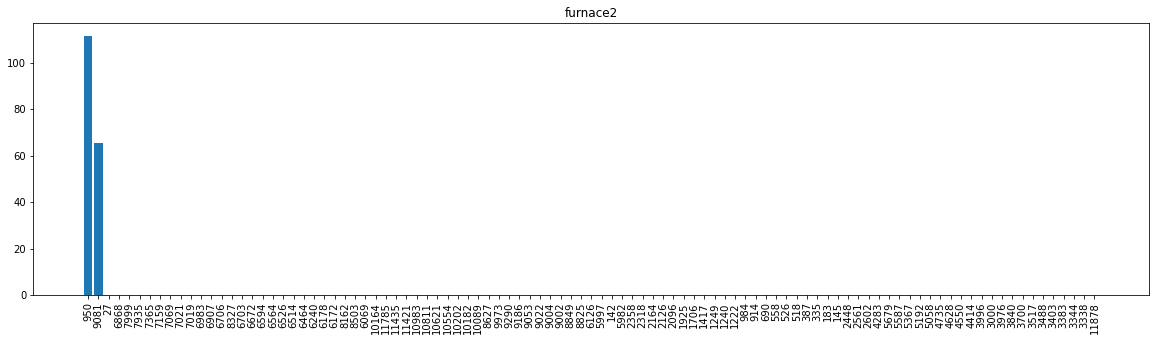

<Figure size 432x288 with 0 Axes>

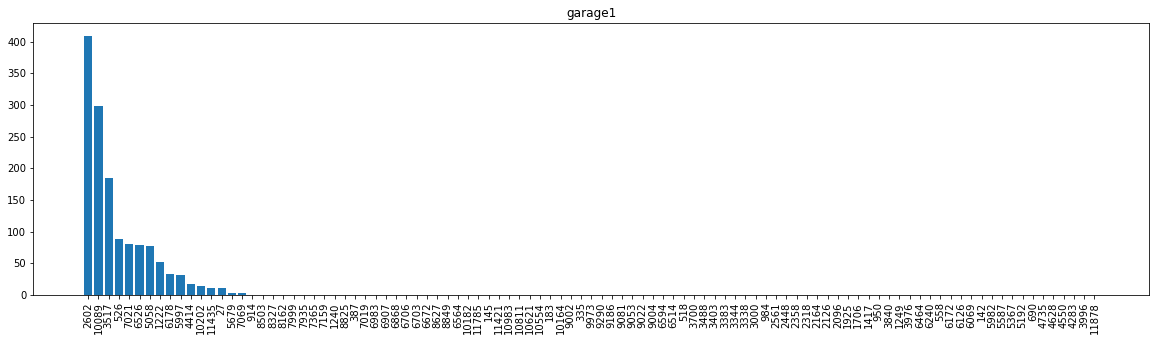

<Figure size 432x288 with 0 Axes>

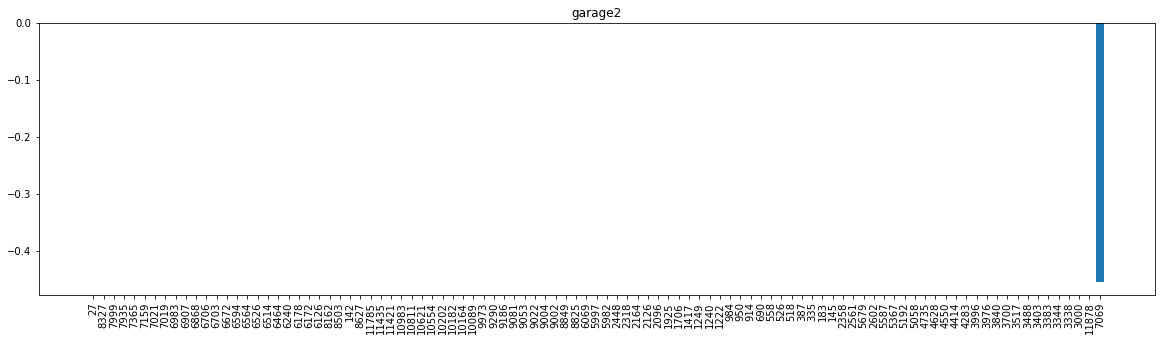

<Figure size 432x288 with 0 Axes>

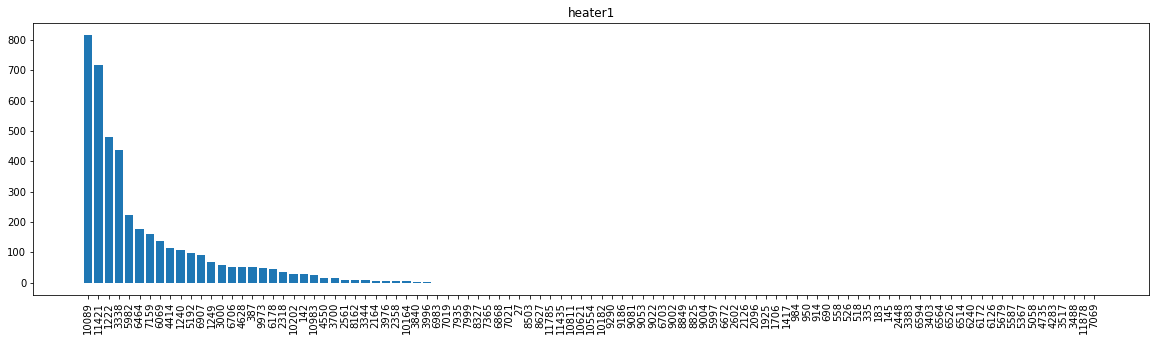

<Figure size 432x288 with 0 Axes>

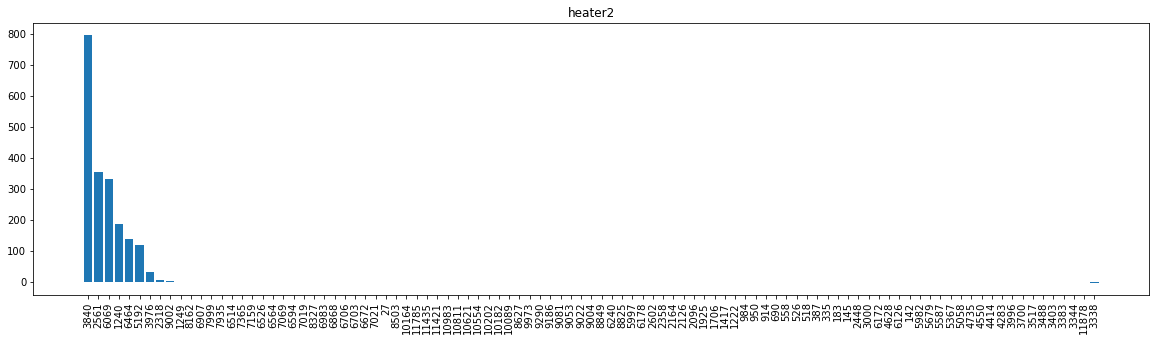

<Figure size 432x288 with 0 Axes>

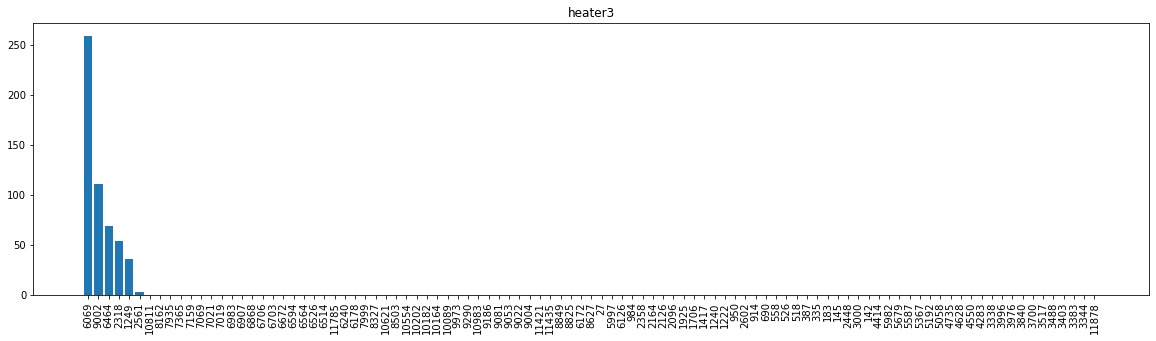

<Figure size 432x288 with 0 Axes>

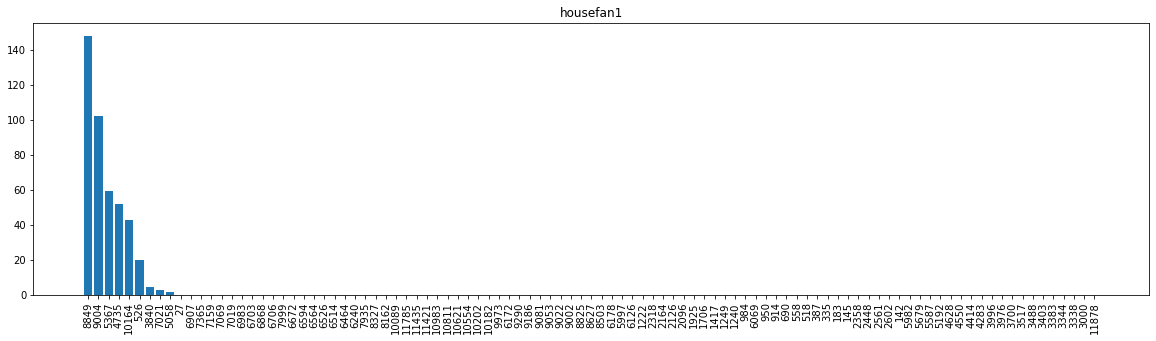

<Figure size 432x288 with 0 Axes>

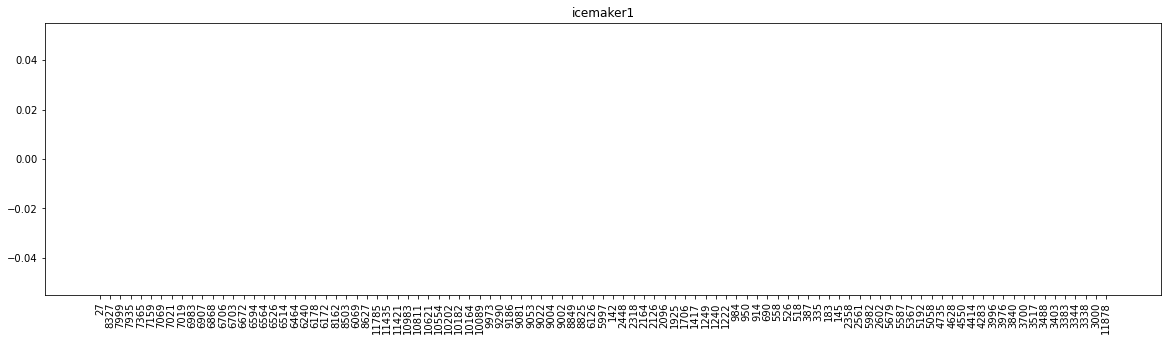

<Figure size 432x288 with 0 Axes>

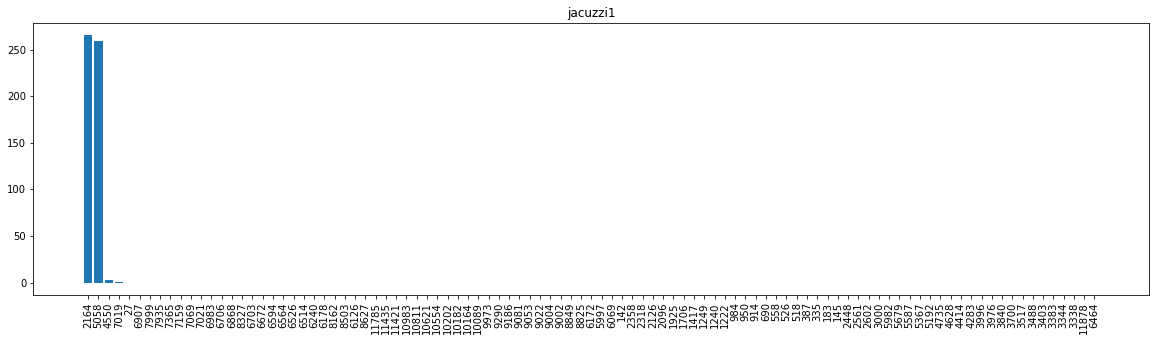

<Figure size 432x288 with 0 Axes>

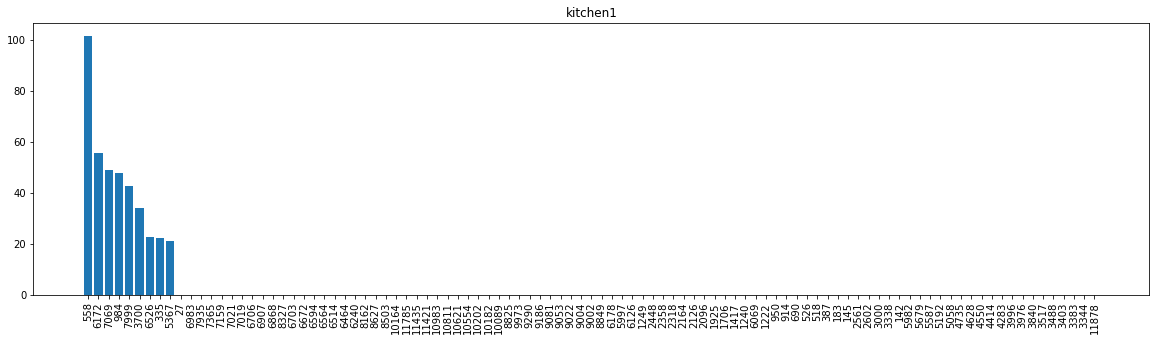

<Figure size 432x288 with 0 Axes>

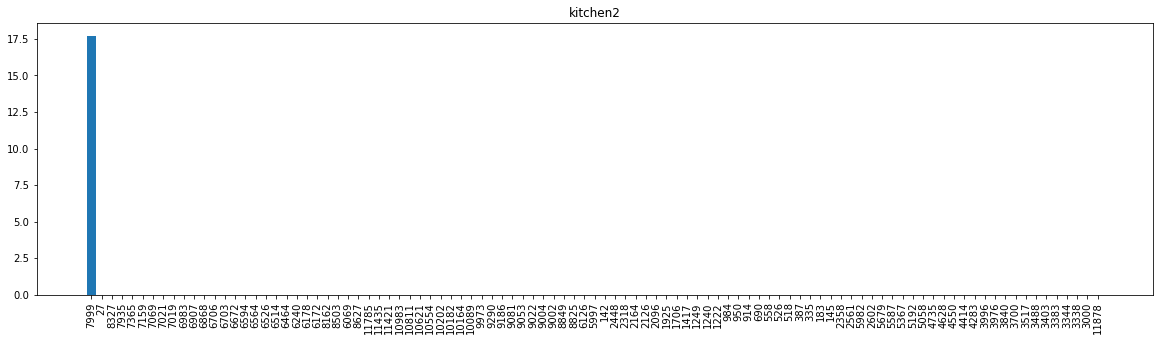

<Figure size 432x288 with 0 Axes>

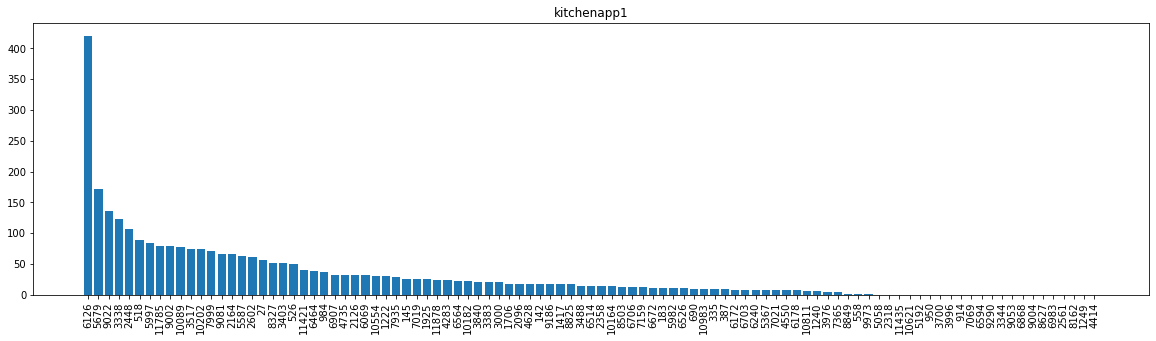

<Figure size 432x288 with 0 Axes>

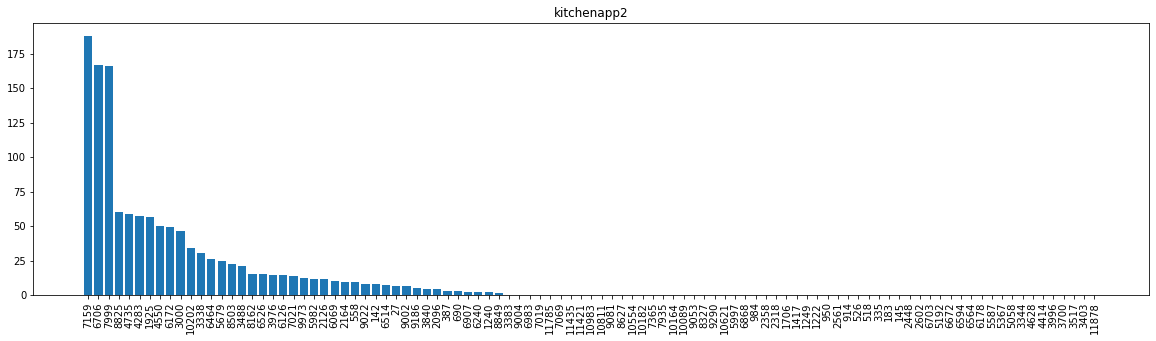

<Figure size 432x288 with 0 Axes>

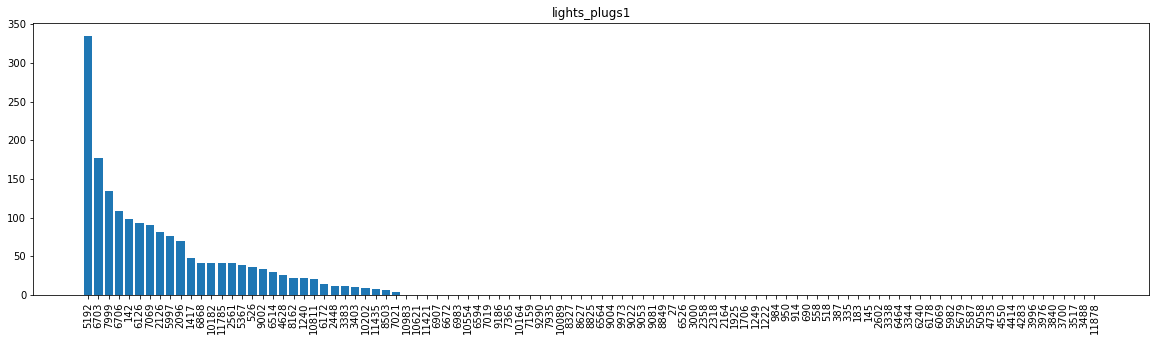

<Figure size 432x288 with 0 Axes>

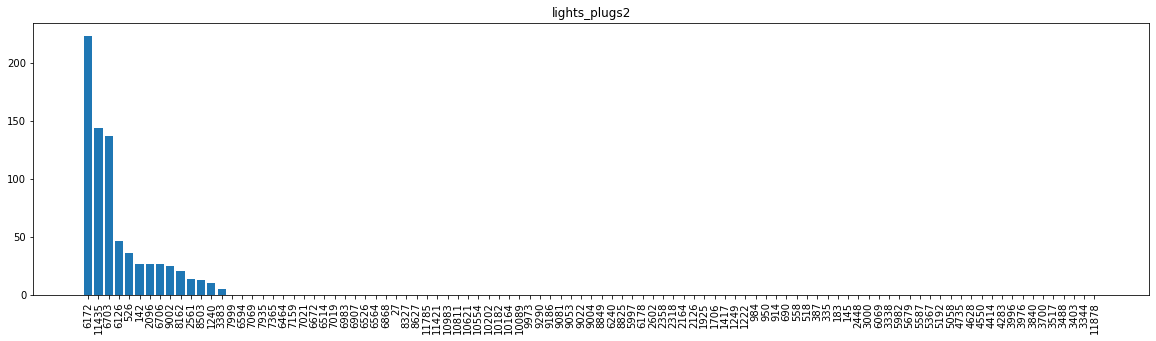

<Figure size 432x288 with 0 Axes>

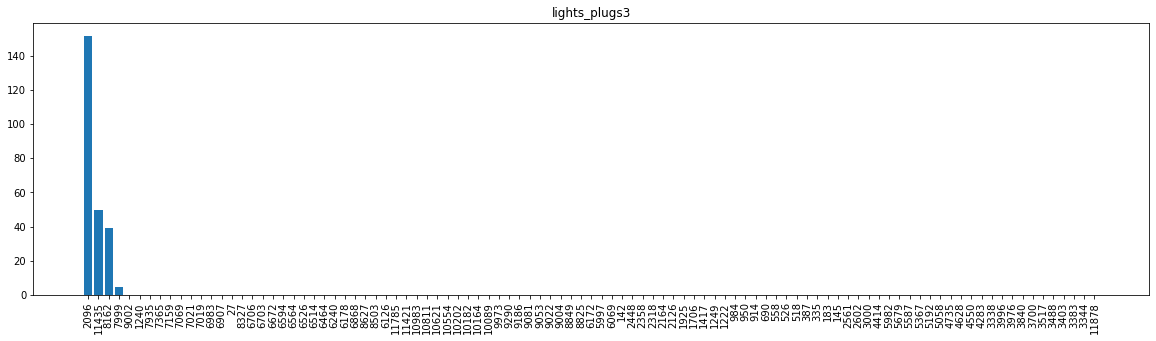

<Figure size 432x288 with 0 Axes>

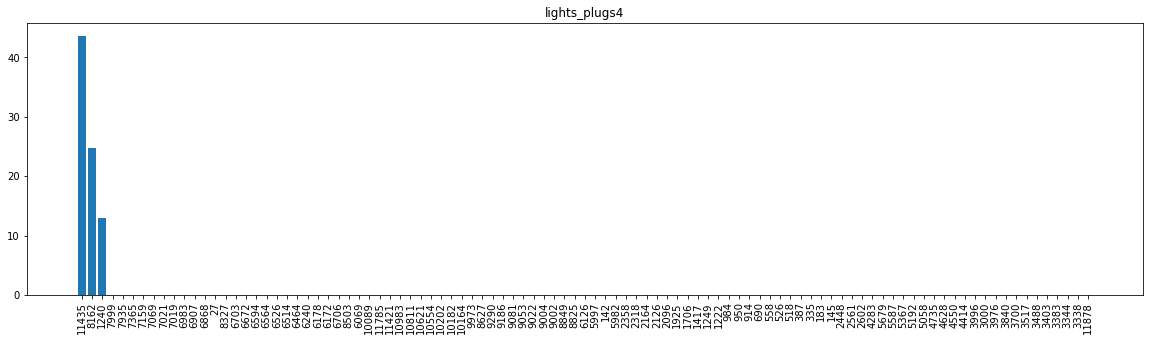

<Figure size 432x288 with 0 Axes>

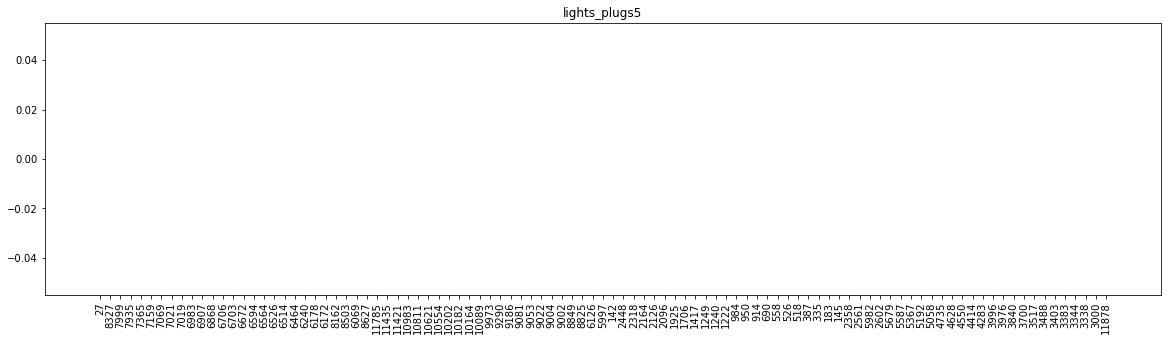

<Figure size 432x288 with 0 Axes>

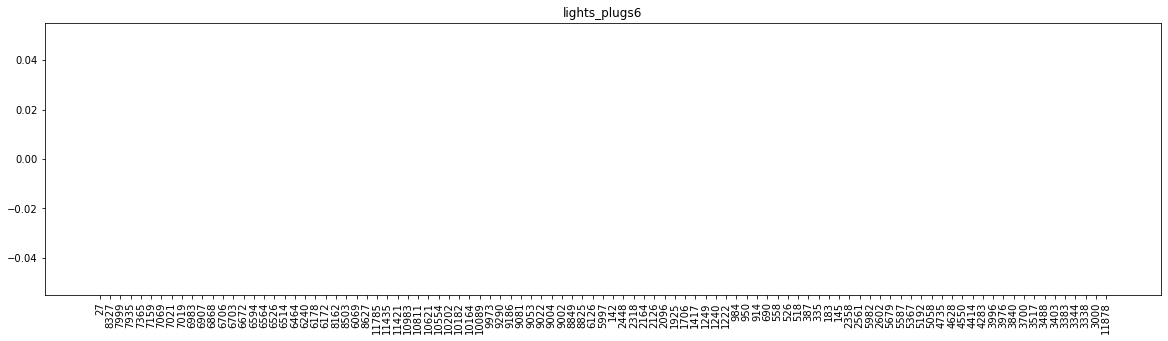

<Figure size 432x288 with 0 Axes>

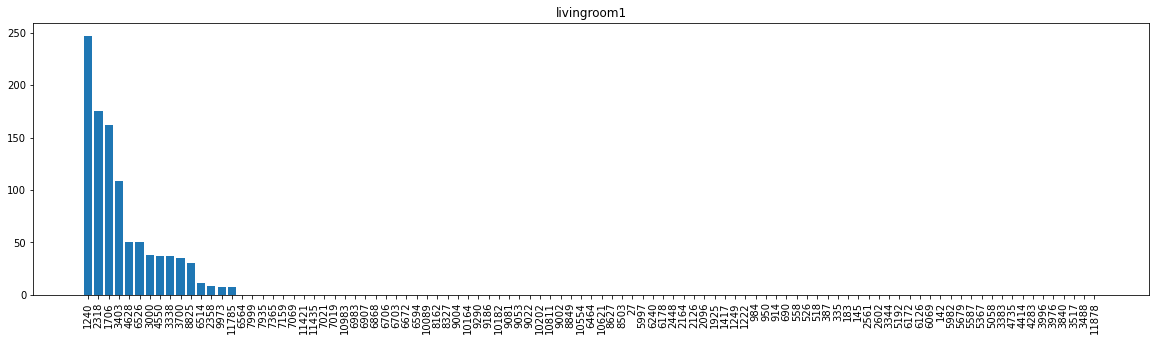

<Figure size 432x288 with 0 Axes>

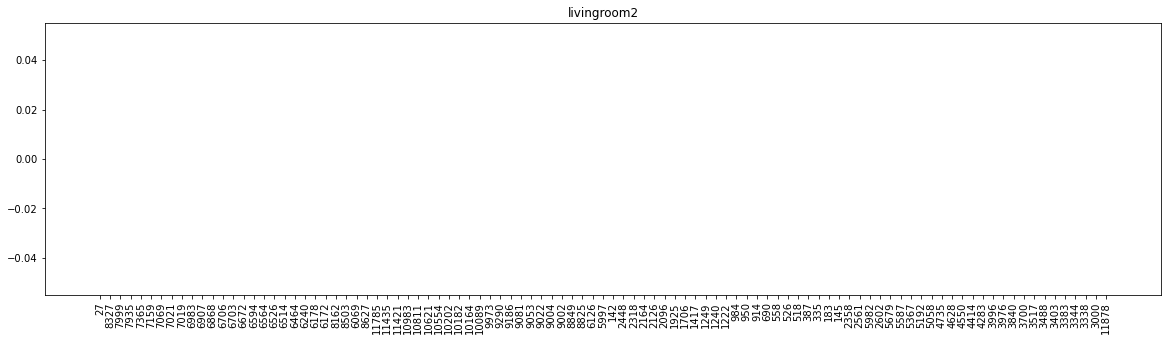

<Figure size 432x288 with 0 Axes>

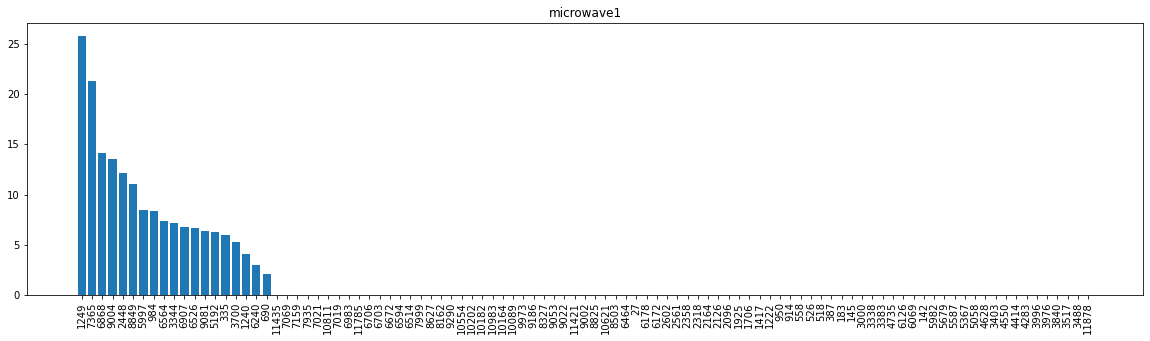

<Figure size 432x288 with 0 Axes>

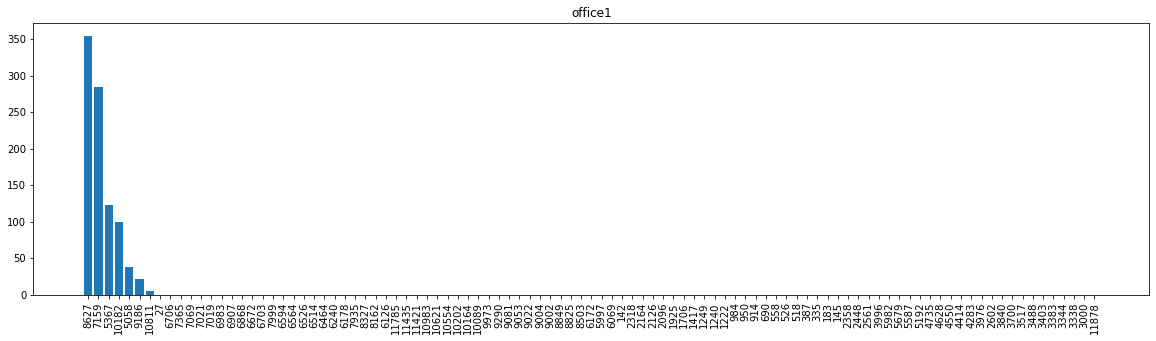

<Figure size 432x288 with 0 Axes>

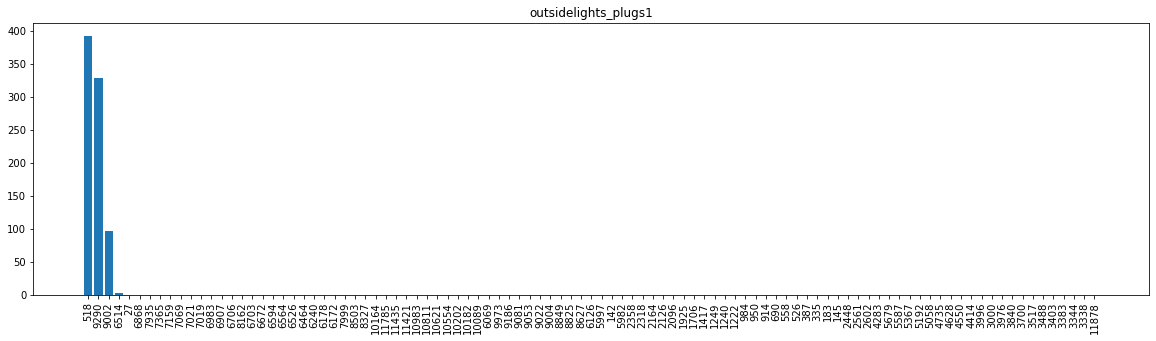

<Figure size 432x288 with 0 Axes>

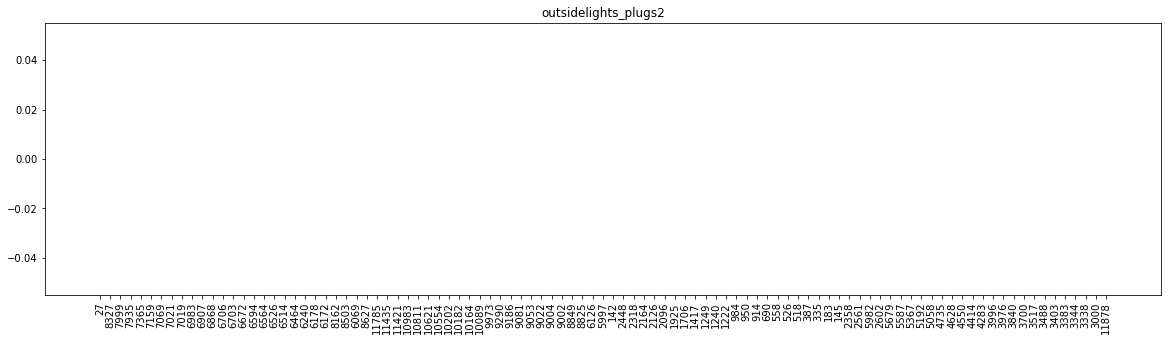

<Figure size 432x288 with 0 Axes>

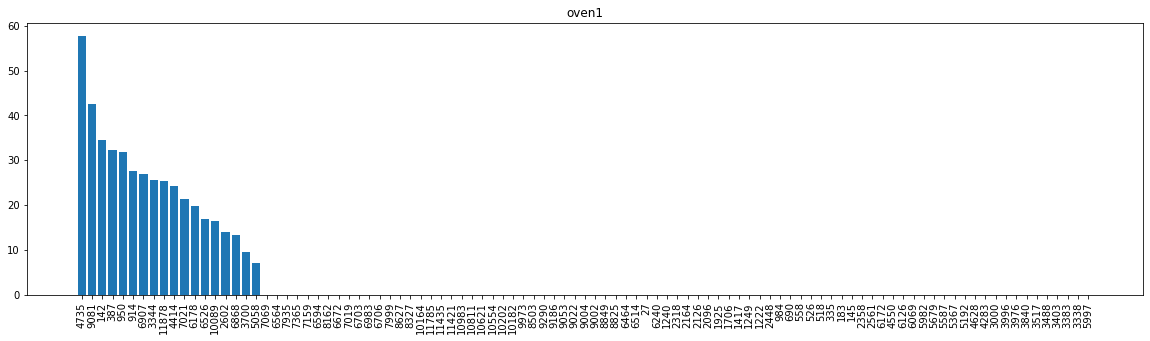

<Figure size 432x288 with 0 Axes>

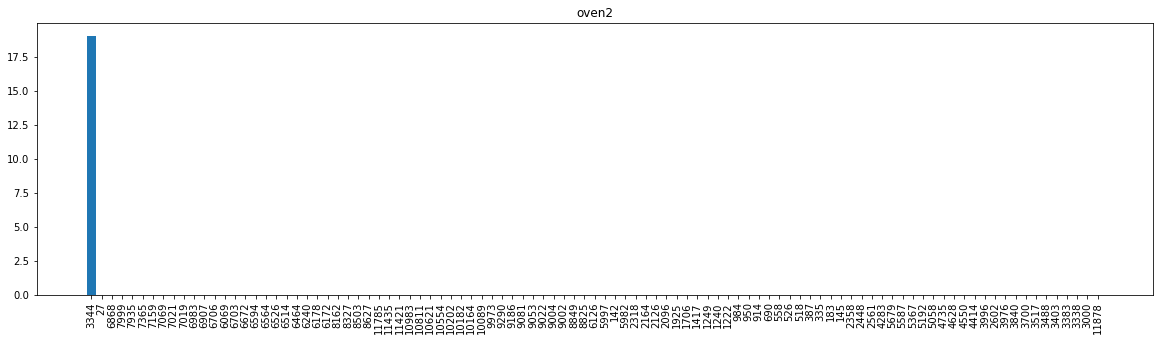

<Figure size 432x288 with 0 Axes>

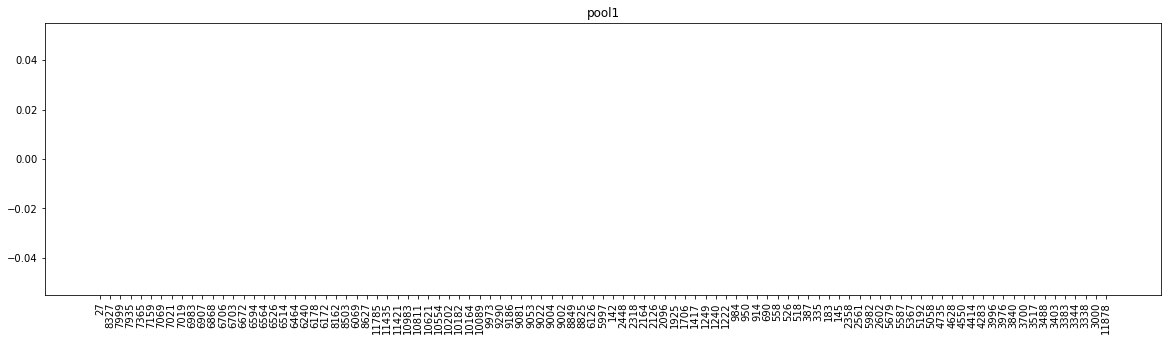

<Figure size 432x288 with 0 Axes>

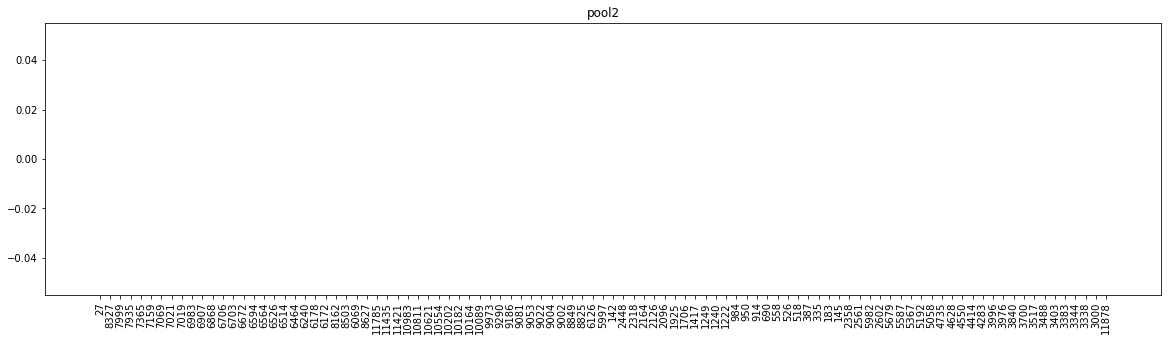

<Figure size 432x288 with 0 Axes>

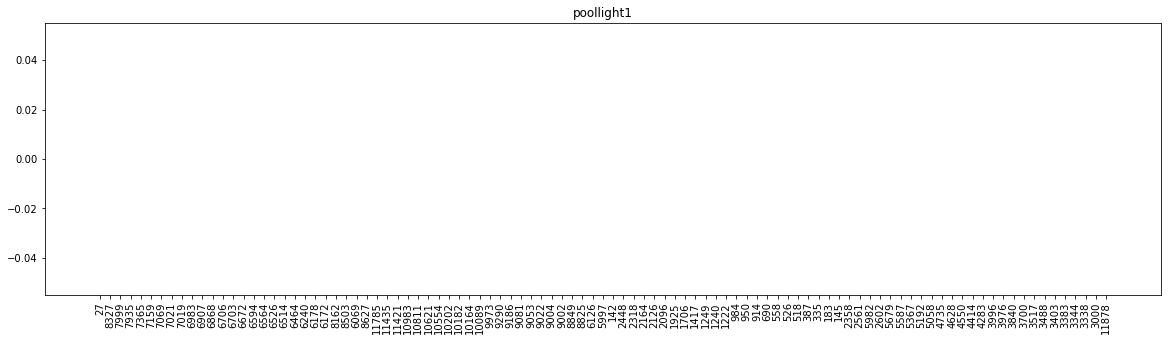

<Figure size 432x288 with 0 Axes>

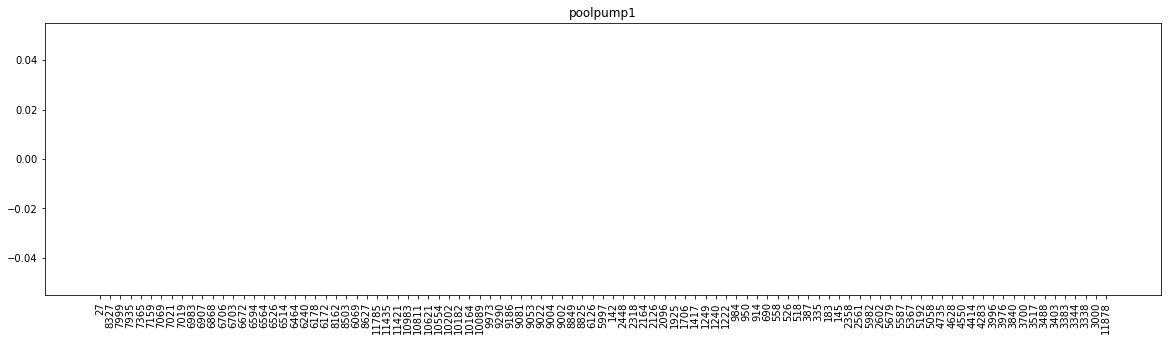

<Figure size 432x288 with 0 Axes>

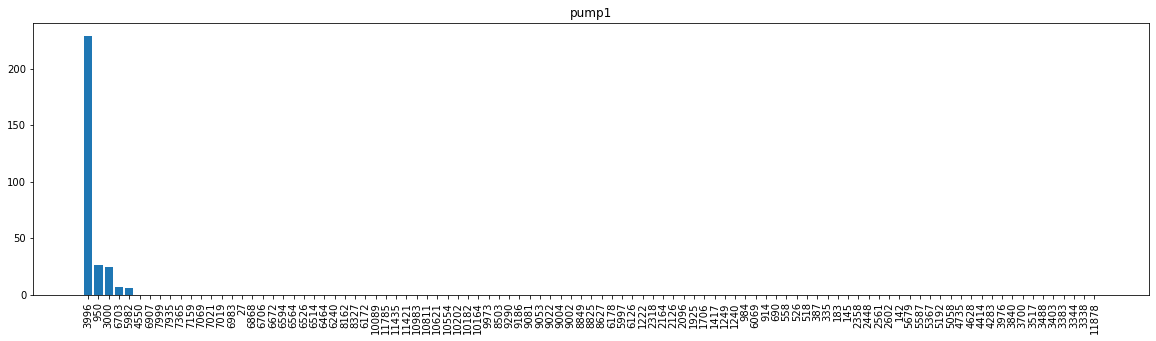

<Figure size 432x288 with 0 Axes>

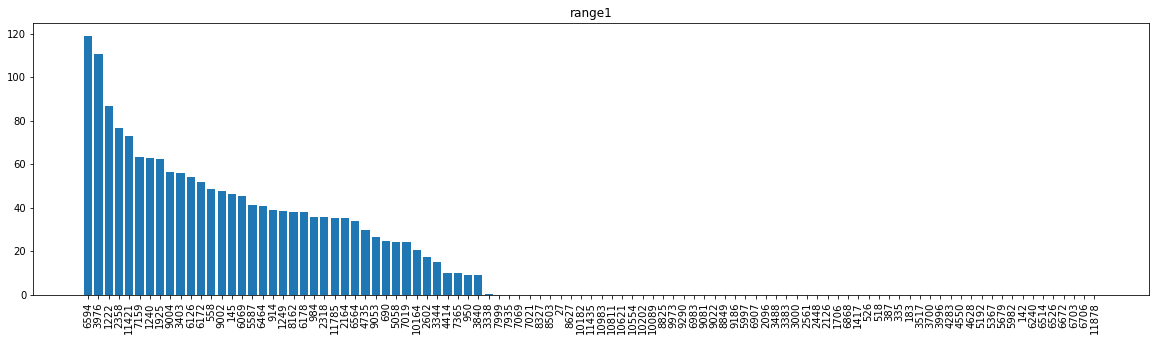

<Figure size 432x288 with 0 Axes>

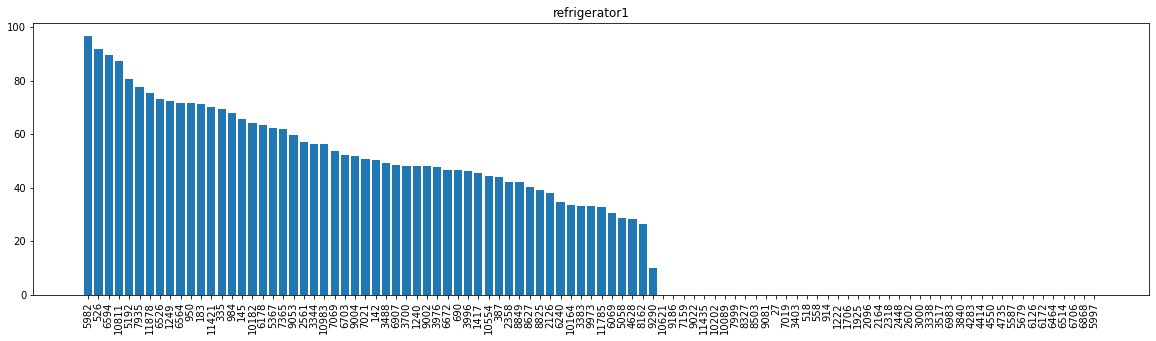

<Figure size 432x288 with 0 Axes>

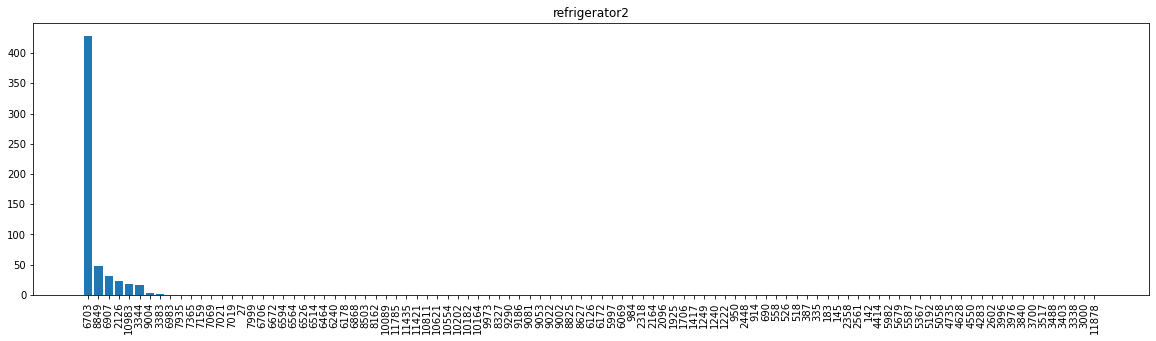

<Figure size 432x288 with 0 Axes>

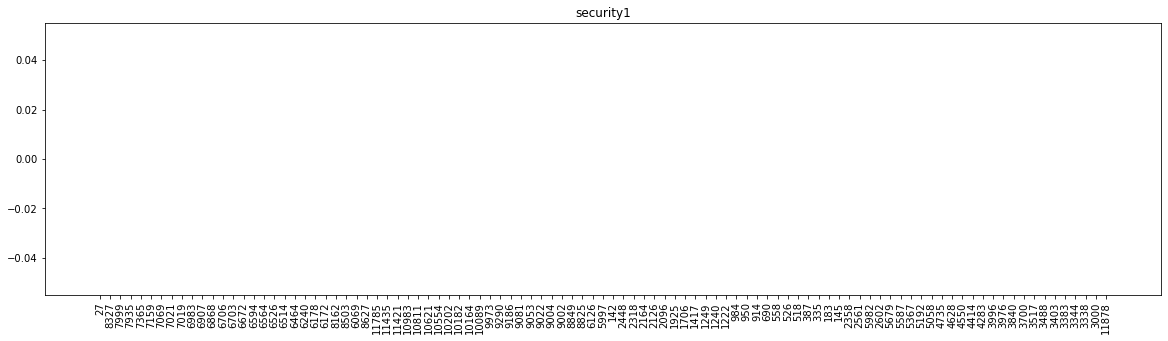

<Figure size 432x288 with 0 Axes>

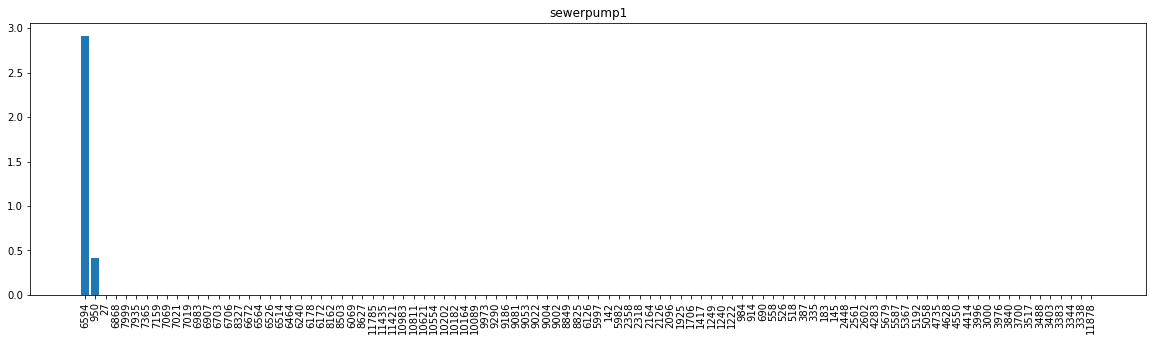

<Figure size 432x288 with 0 Axes>

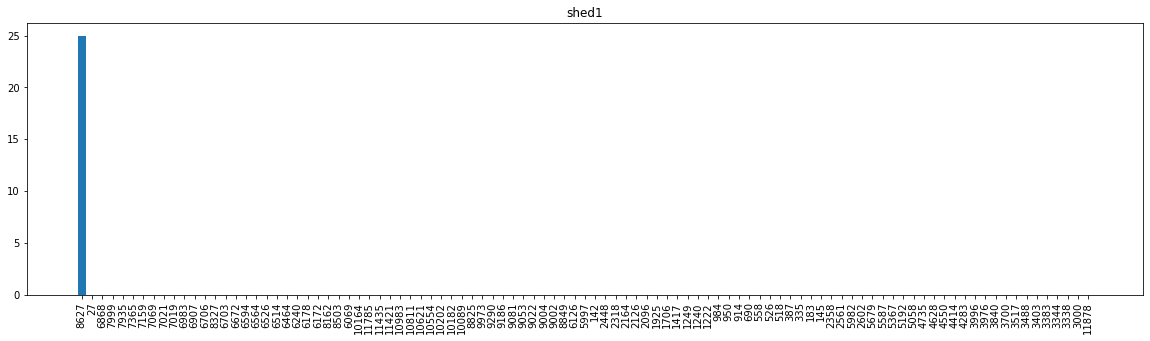

<Figure size 432x288 with 0 Axes>

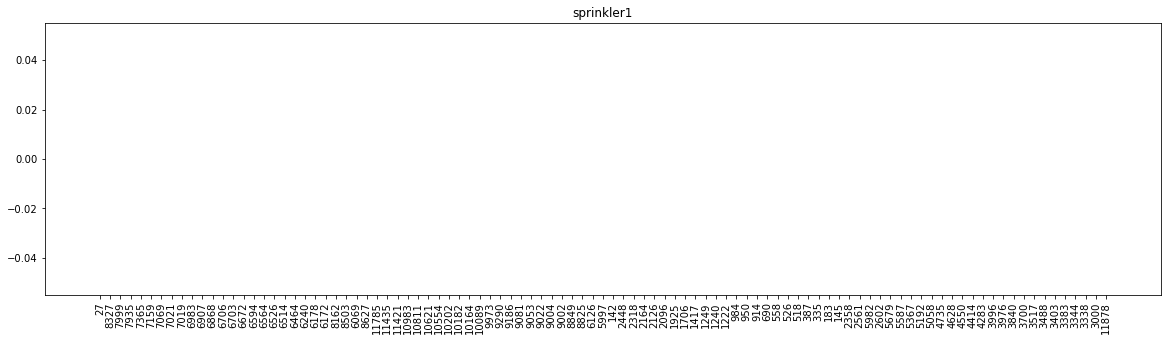

<Figure size 432x288 with 0 Axes>

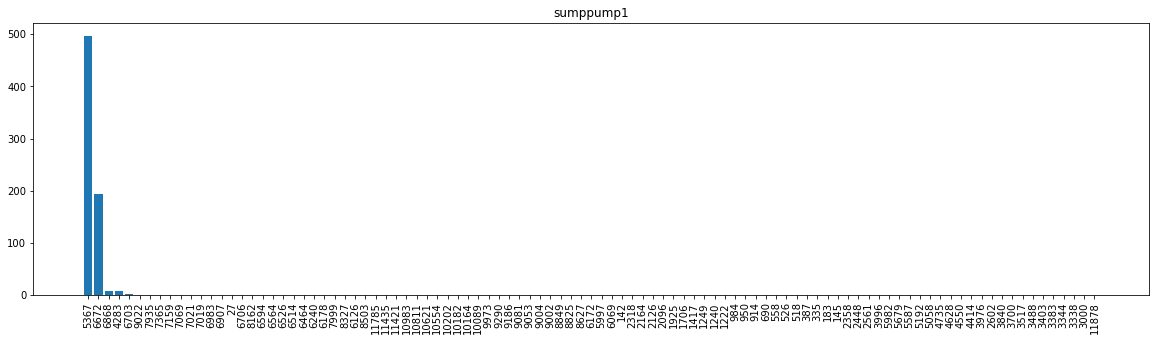

<Figure size 432x288 with 0 Axes>

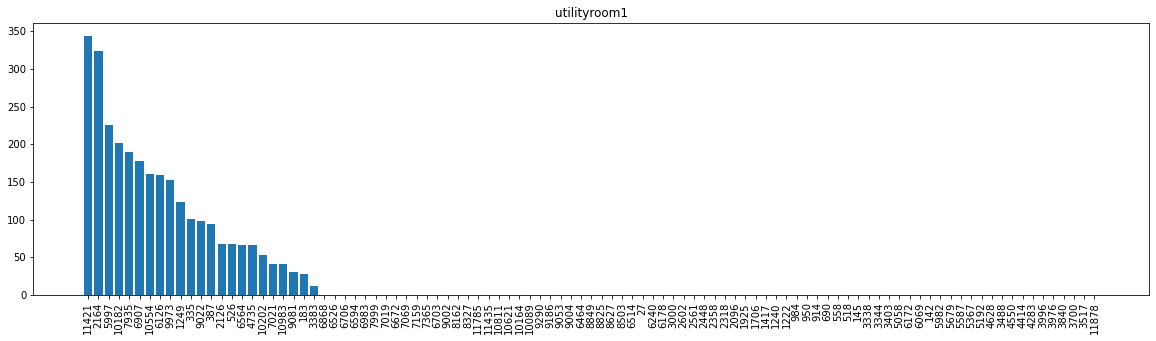

<Figure size 432x288 with 0 Axes>

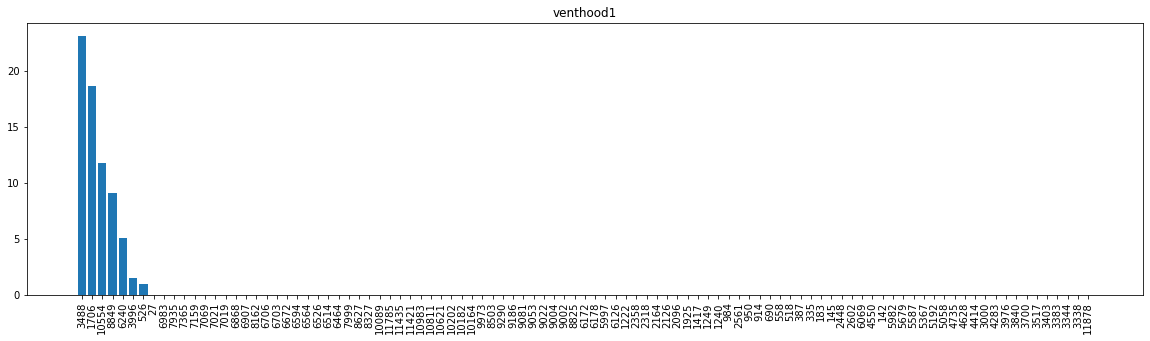

<Figure size 432x288 with 0 Axes>

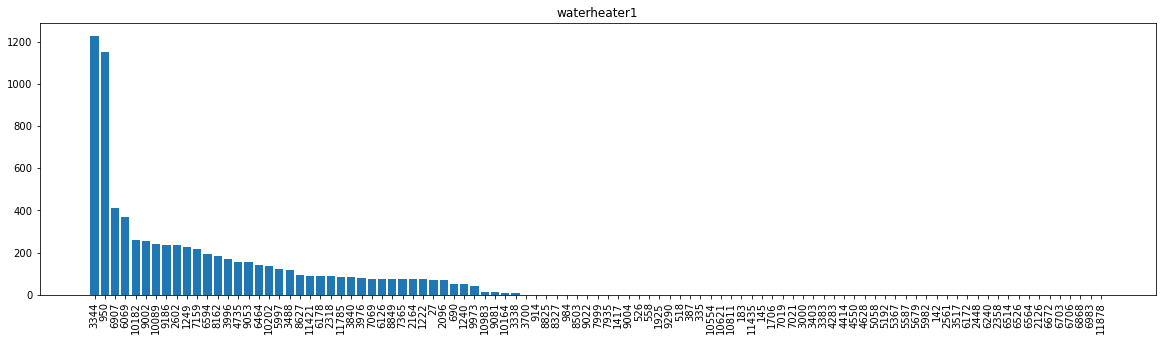

<Figure size 432x288 with 0 Axes>

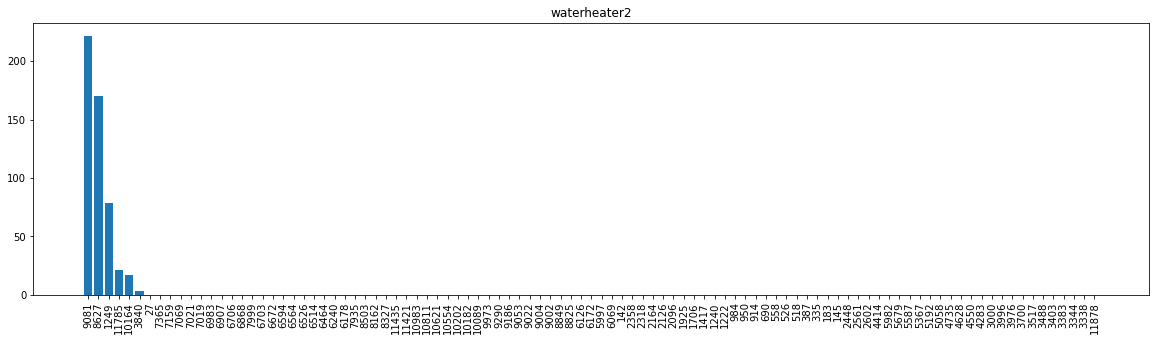

<Figure size 432x288 with 0 Axes>

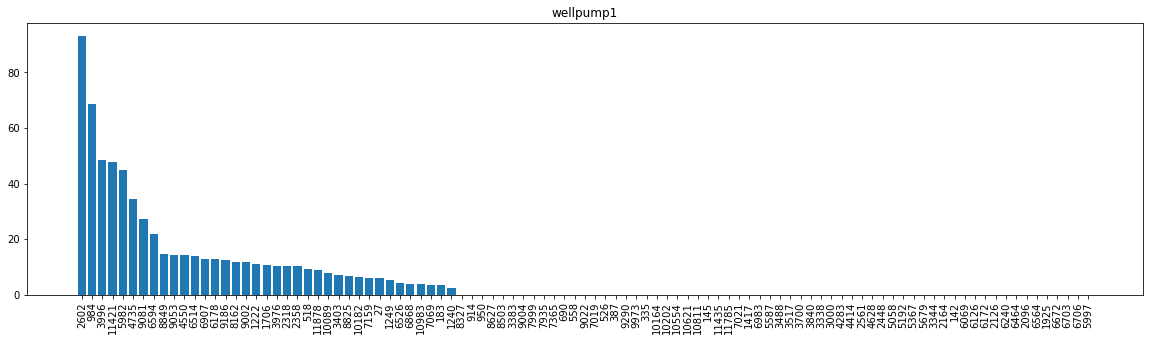

<Figure size 432x288 with 0 Axes>

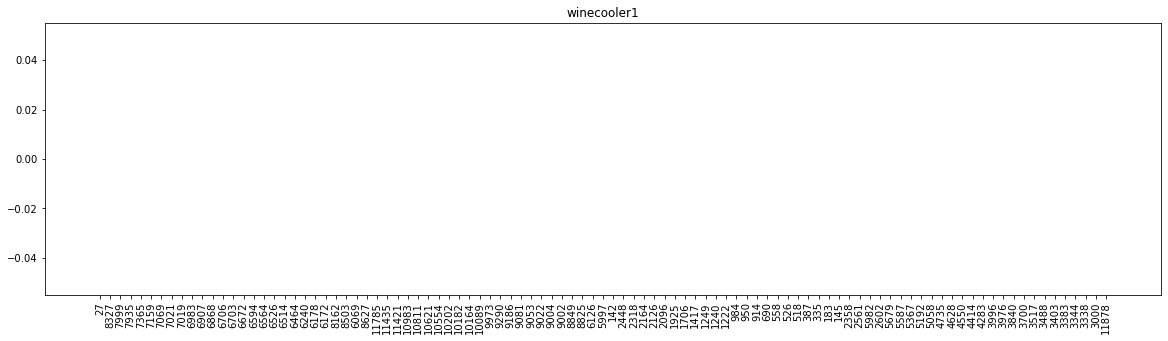

In [58]:
#plots for appliance power consumption for each house
for column in df_avg.columns:
    appliance = df_avg.sort_values(by=str(column), ascending=False)
    plt.figure()
    plt.figure(figsize=(20,5))
    plt.bar(appliance.index.astype('str'), appliance[str(column)].values)
    plt.xticks(rotation=90)
    plt.title(str(column))

In [59]:
appliance_over_mains = df_avg.div(total_grid_power.total_grid.sort_index().values, axis=0)

<ipython-input-60-c5c949f57695>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

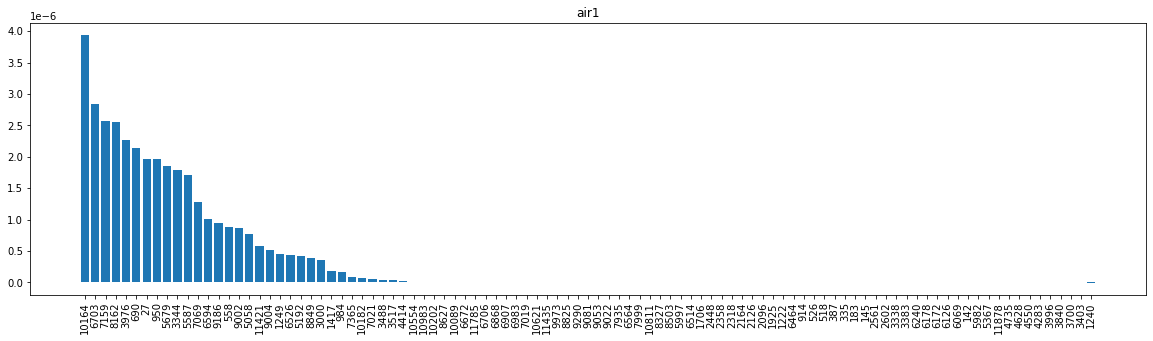

<Figure size 432x288 with 0 Axes>

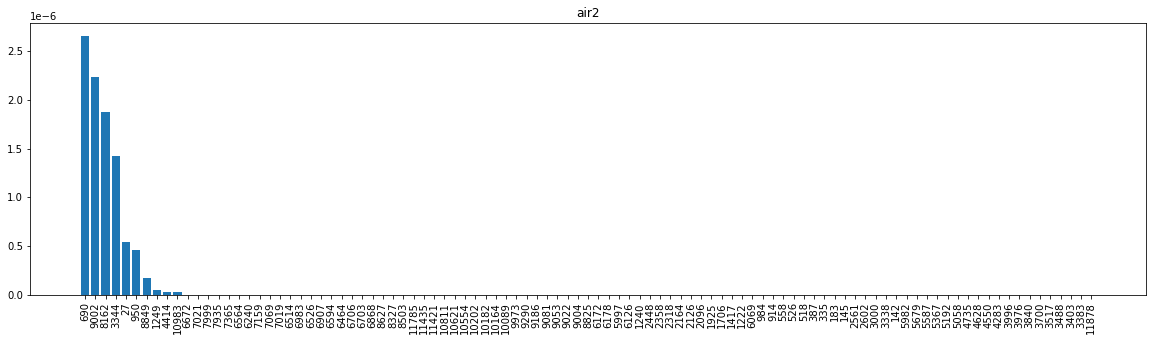

<Figure size 432x288 with 0 Axes>

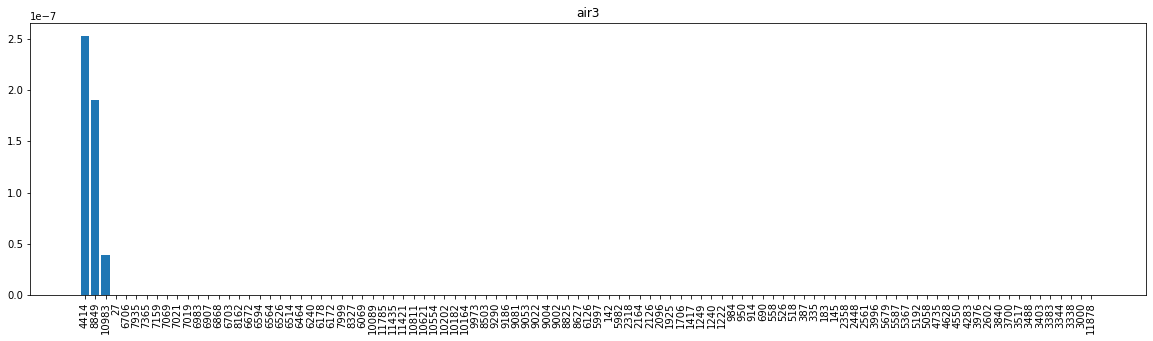

<Figure size 432x288 with 0 Axes>

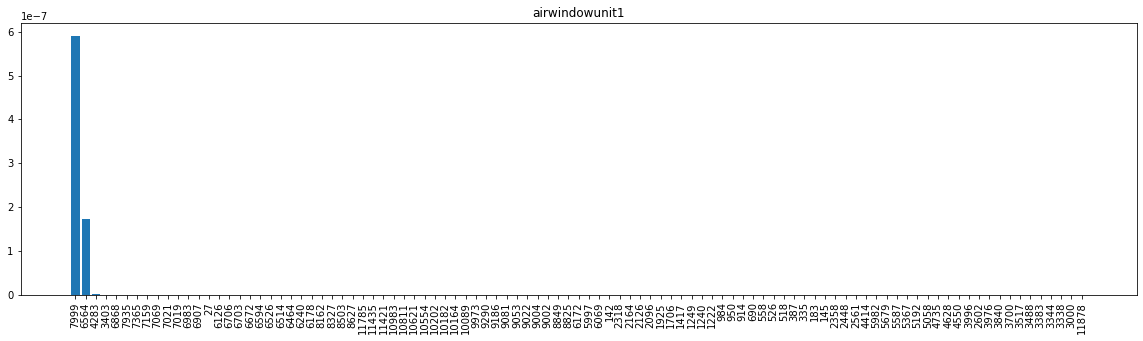

<Figure size 432x288 with 0 Axes>

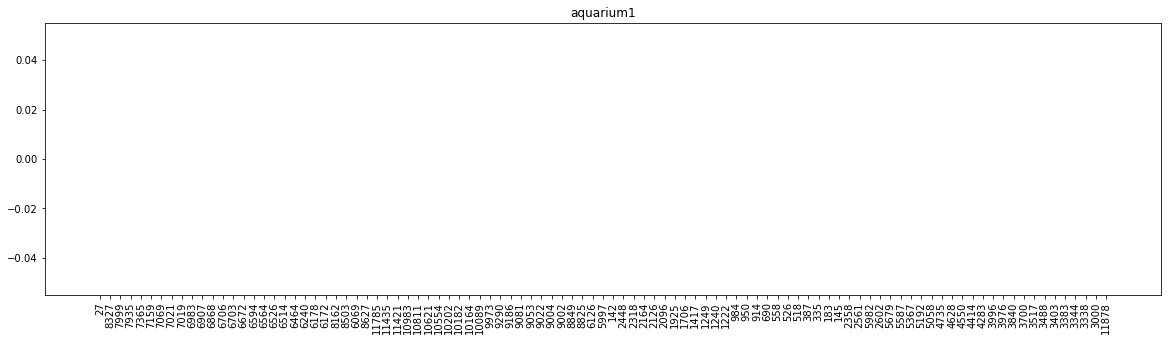

<Figure size 432x288 with 0 Axes>

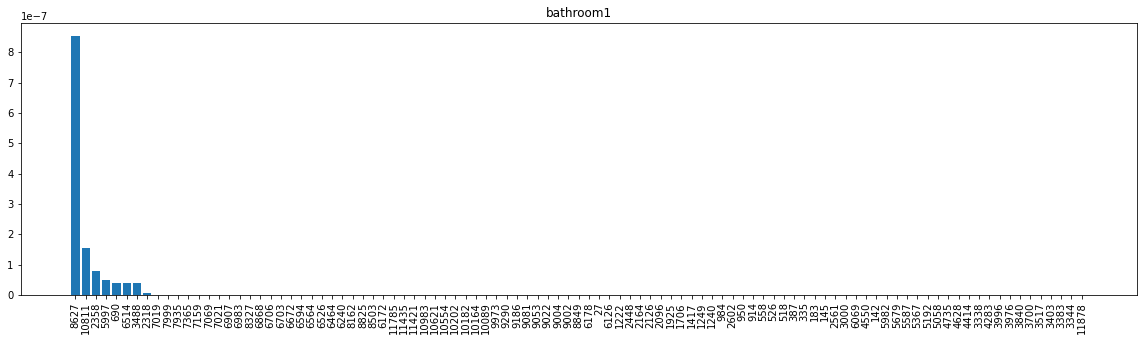

<Figure size 432x288 with 0 Axes>

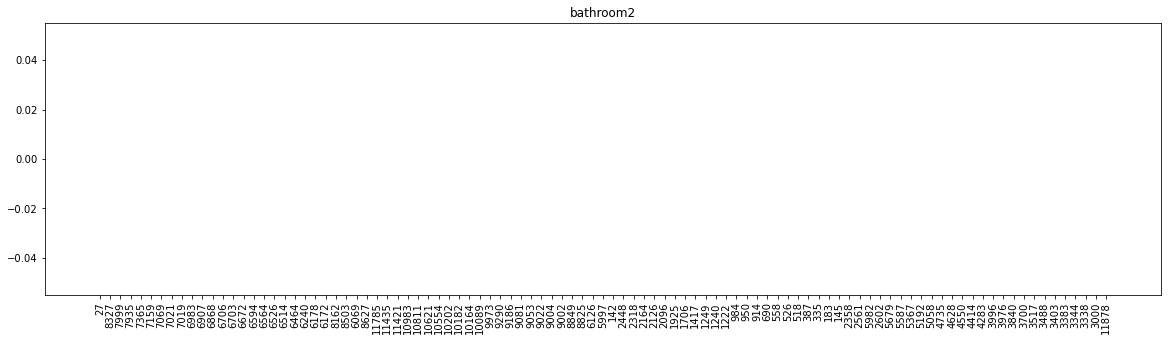

<Figure size 432x288 with 0 Axes>

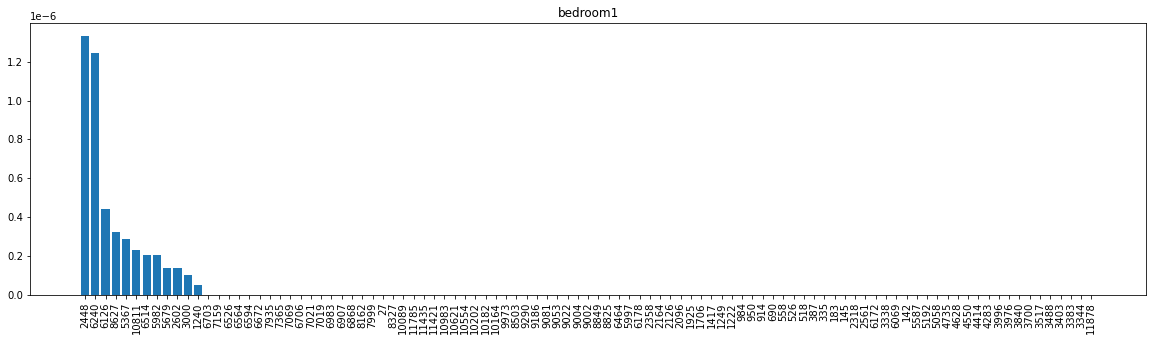

<Figure size 432x288 with 0 Axes>

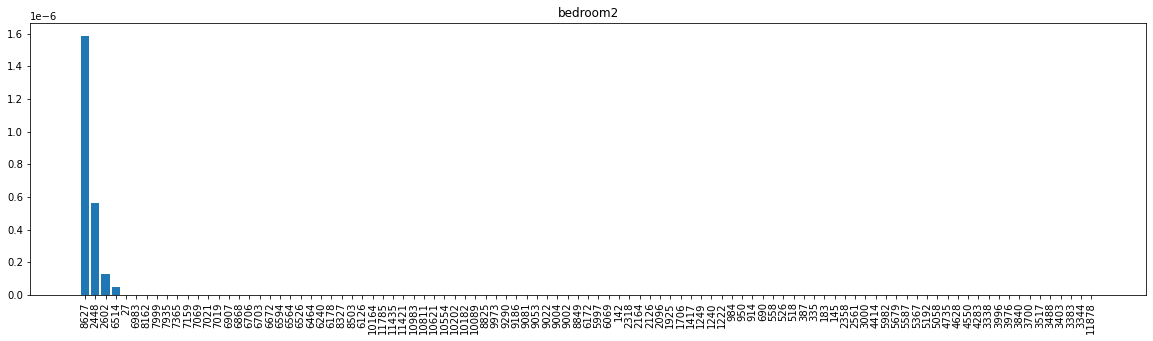

<Figure size 432x288 with 0 Axes>

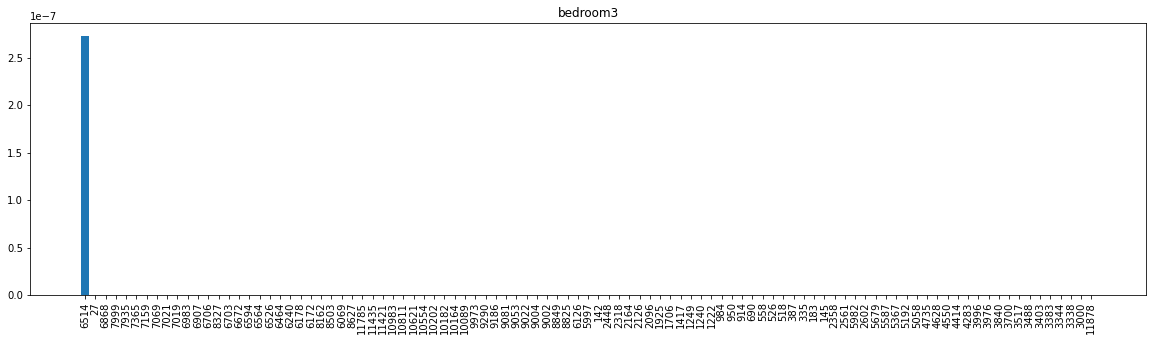

<Figure size 432x288 with 0 Axes>

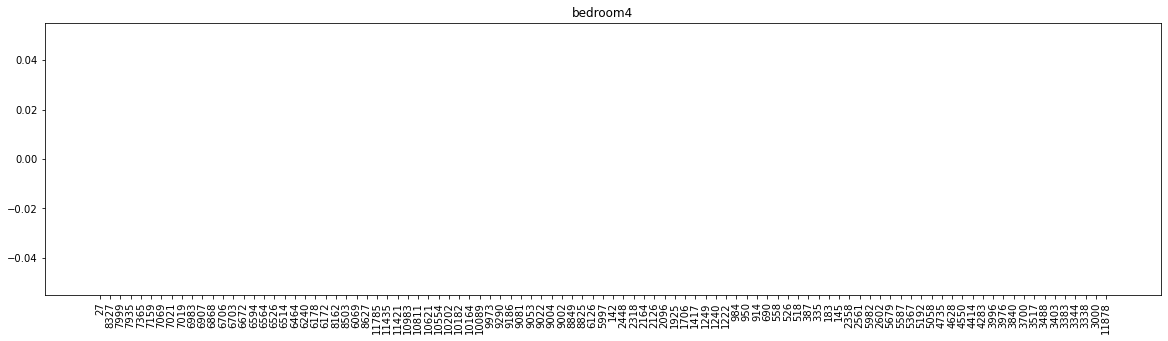

<Figure size 432x288 with 0 Axes>

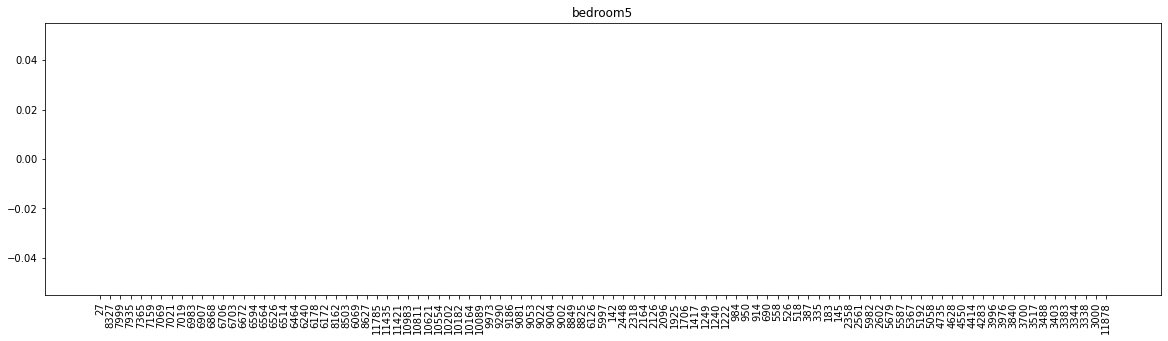

<Figure size 432x288 with 0 Axes>

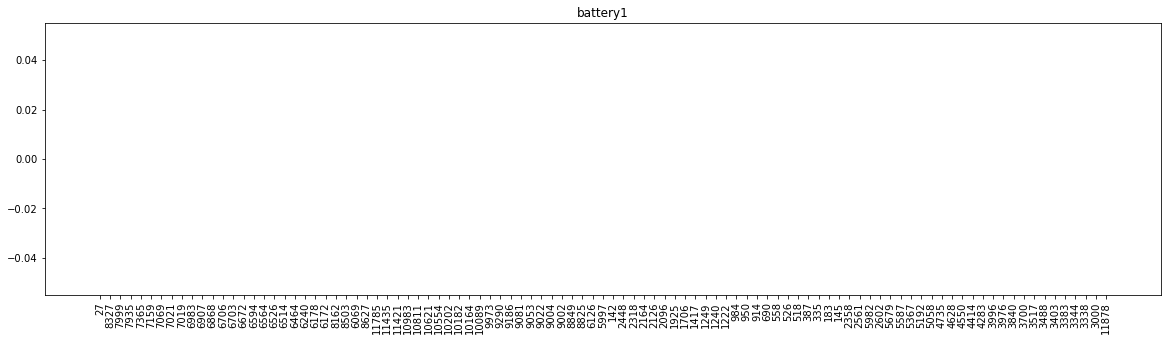

<Figure size 432x288 with 0 Axes>

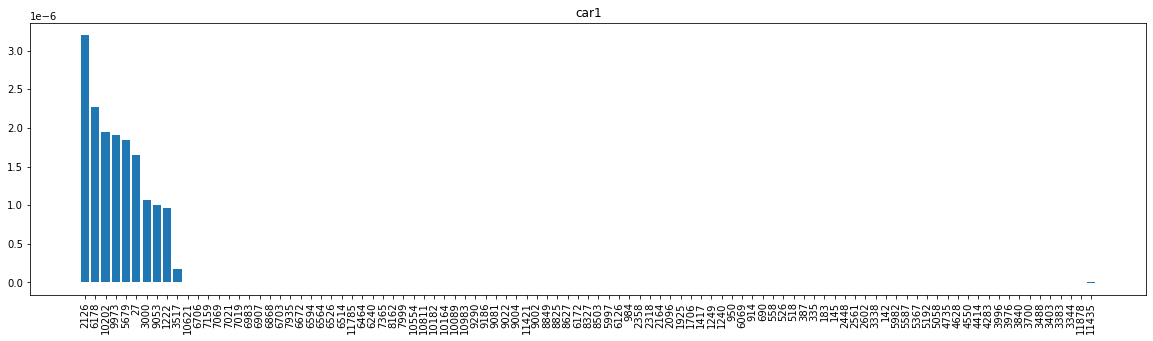

<Figure size 432x288 with 0 Axes>

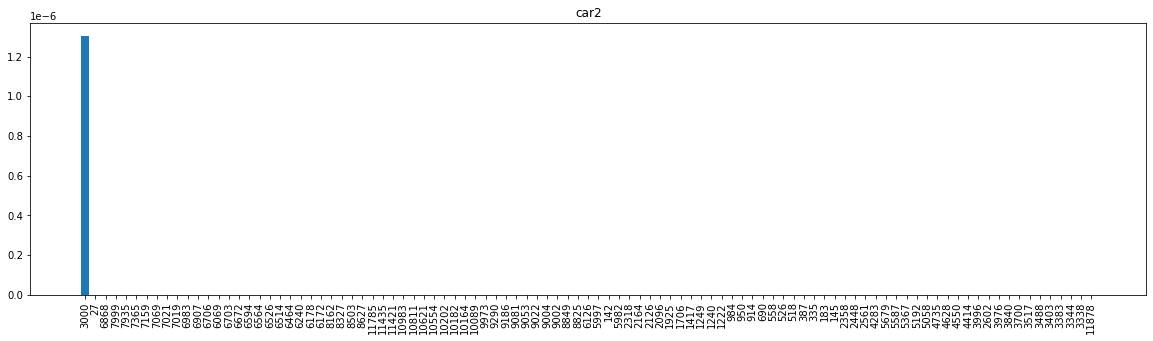

<Figure size 432x288 with 0 Axes>

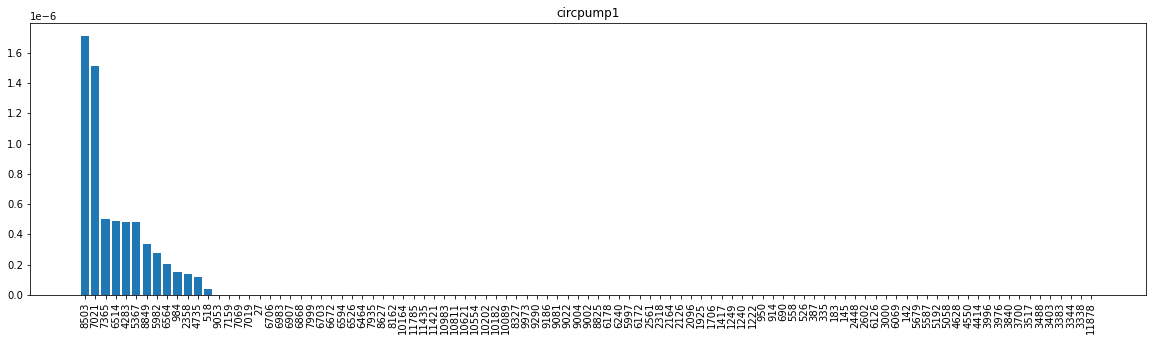

<Figure size 432x288 with 0 Axes>

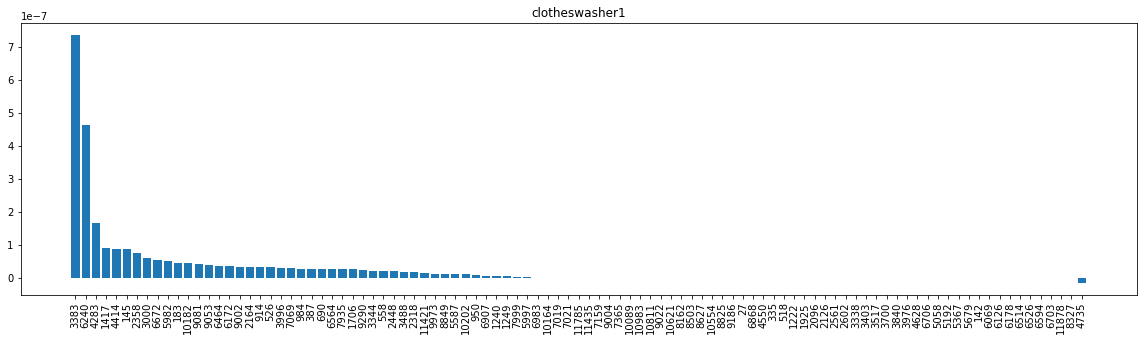

<Figure size 432x288 with 0 Axes>

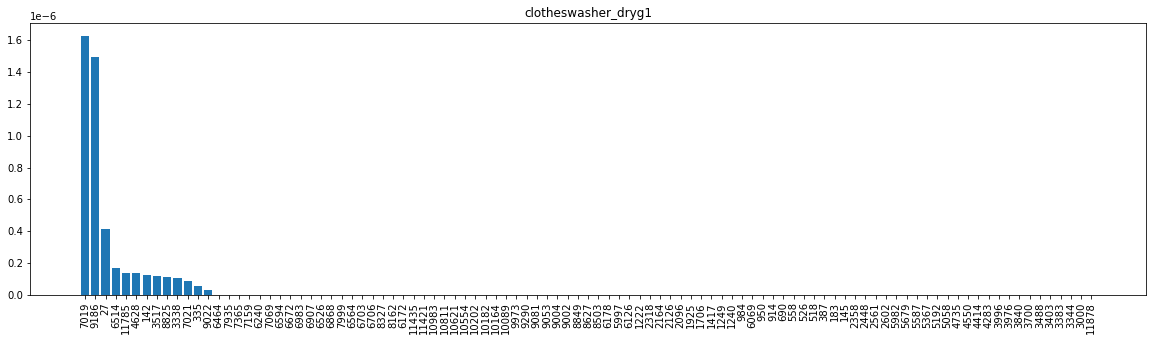

<Figure size 432x288 with 0 Axes>

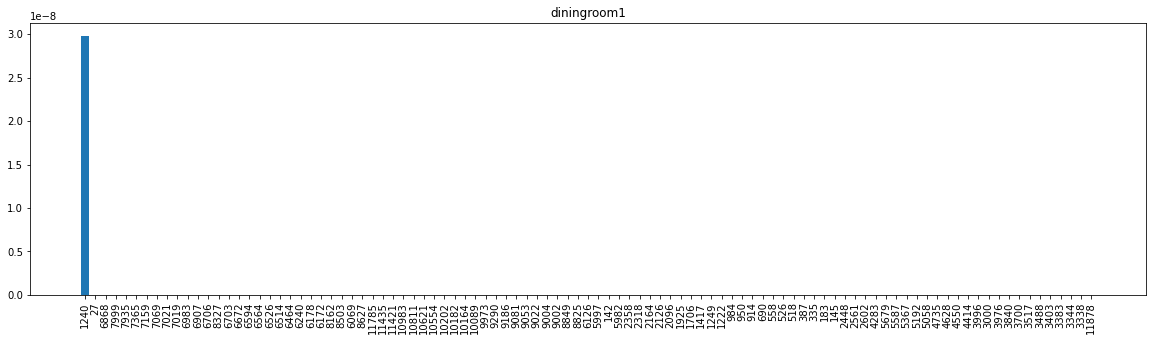

<Figure size 432x288 with 0 Axes>

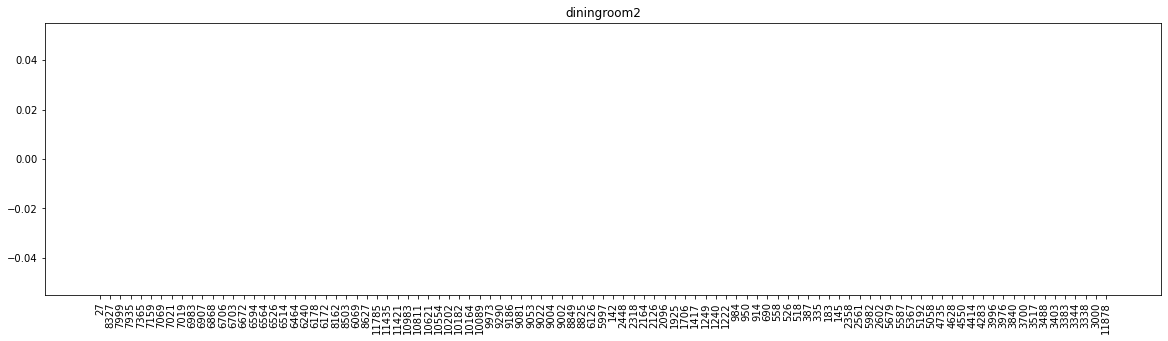

<Figure size 432x288 with 0 Axes>

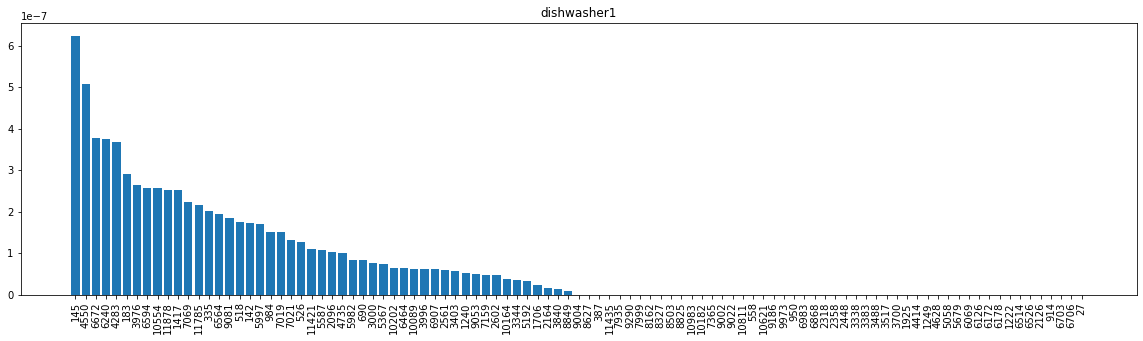

<Figure size 432x288 with 0 Axes>

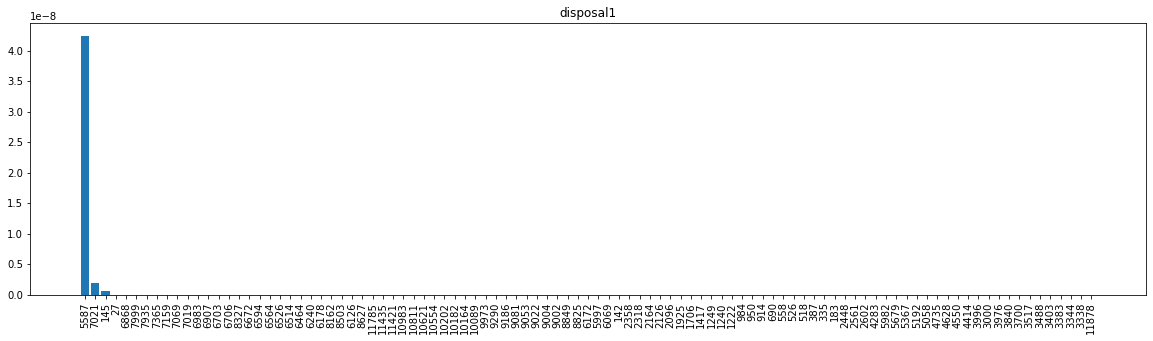

<Figure size 432x288 with 0 Axes>

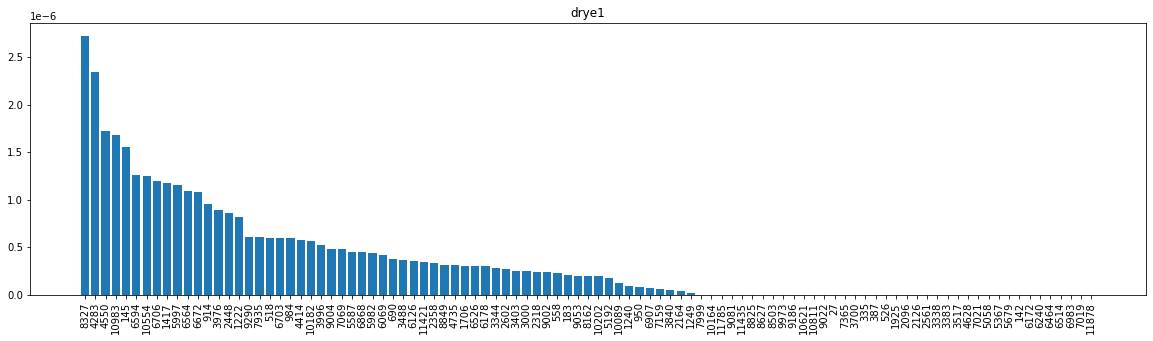

<Figure size 432x288 with 0 Axes>

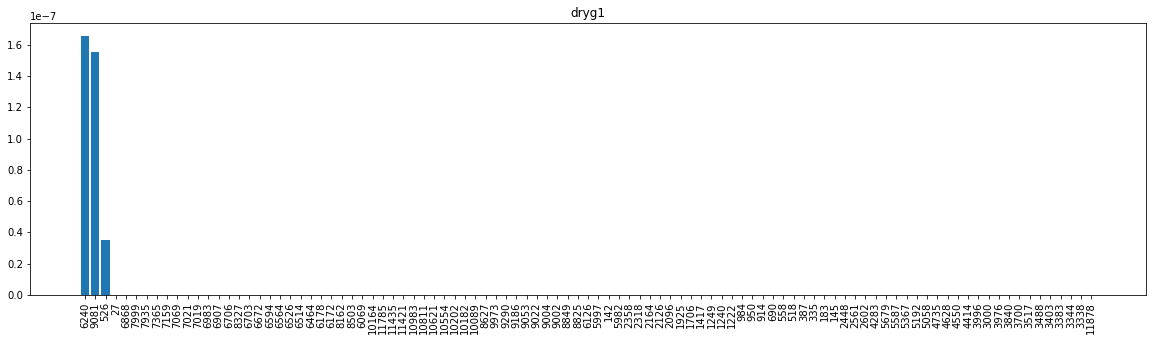

<Figure size 432x288 with 0 Axes>

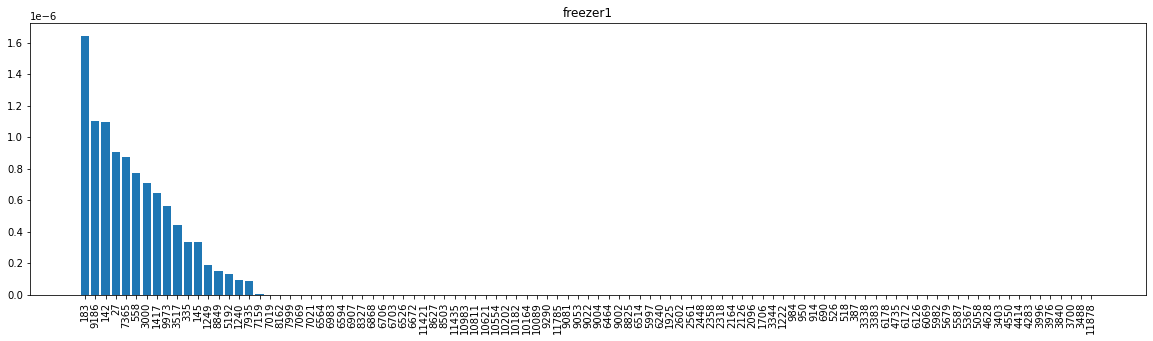

<Figure size 432x288 with 0 Axes>

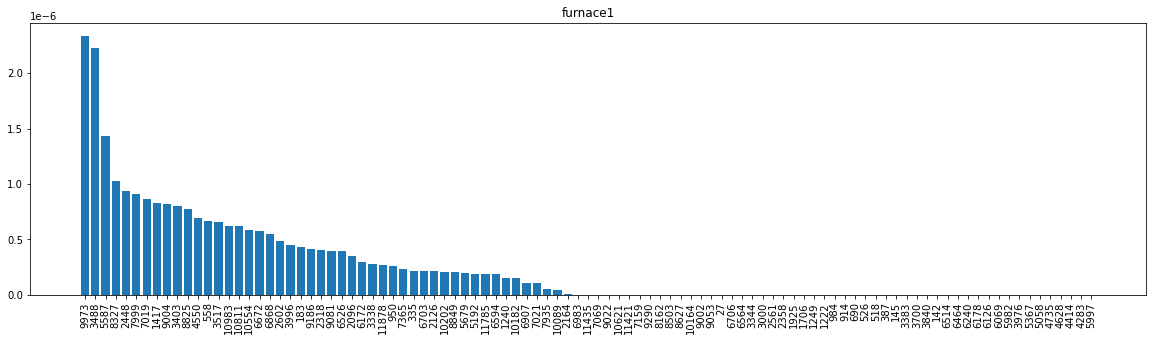

<Figure size 432x288 with 0 Axes>

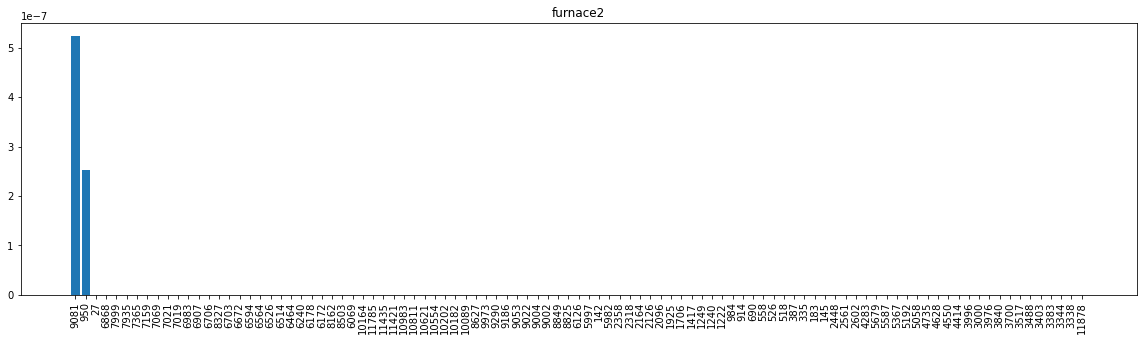

<Figure size 432x288 with 0 Axes>

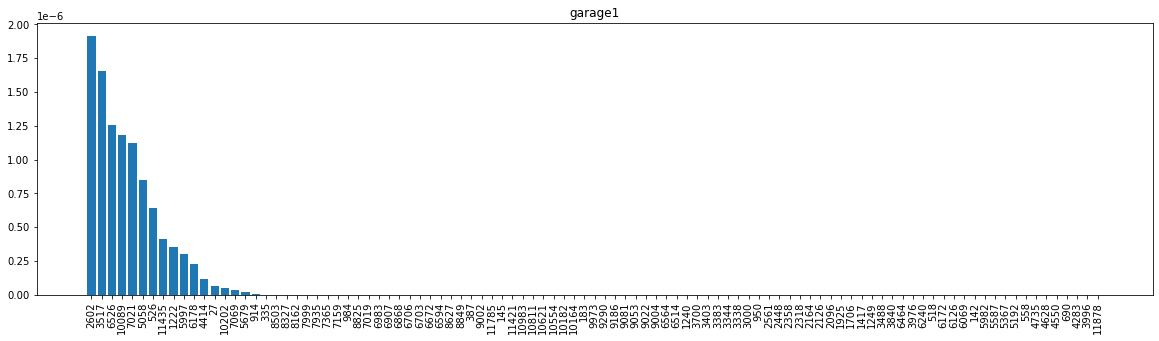

<Figure size 432x288 with 0 Axes>

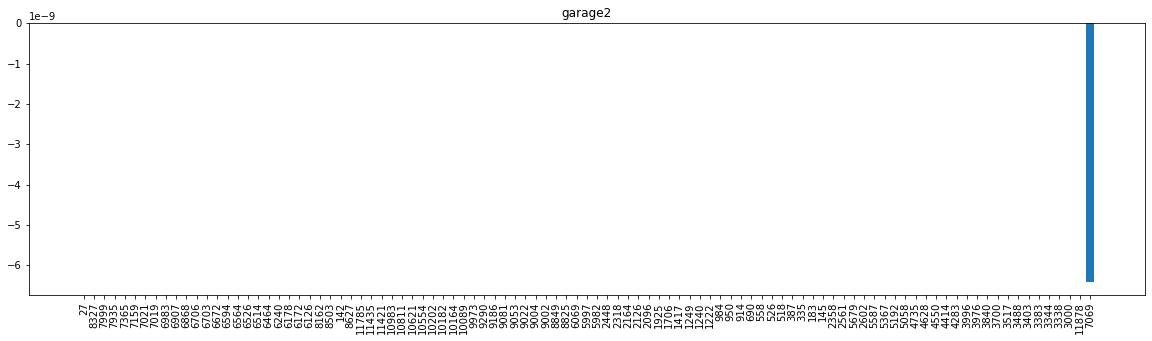

<Figure size 432x288 with 0 Axes>

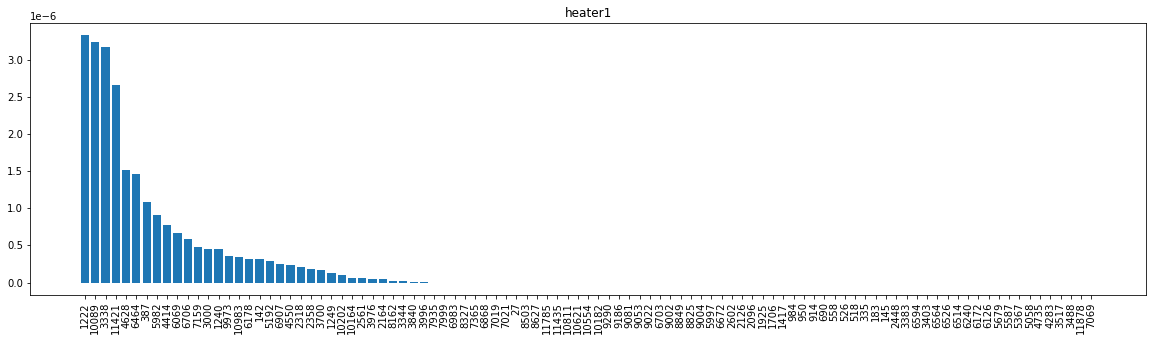

<Figure size 432x288 with 0 Axes>

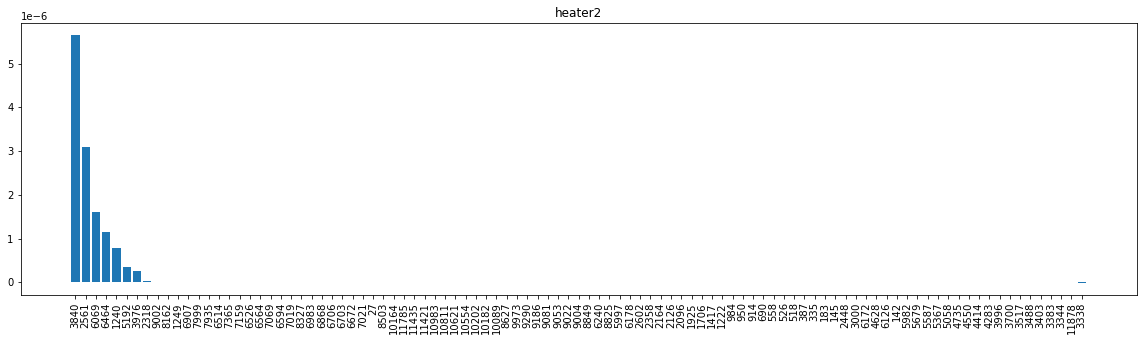

<Figure size 432x288 with 0 Axes>

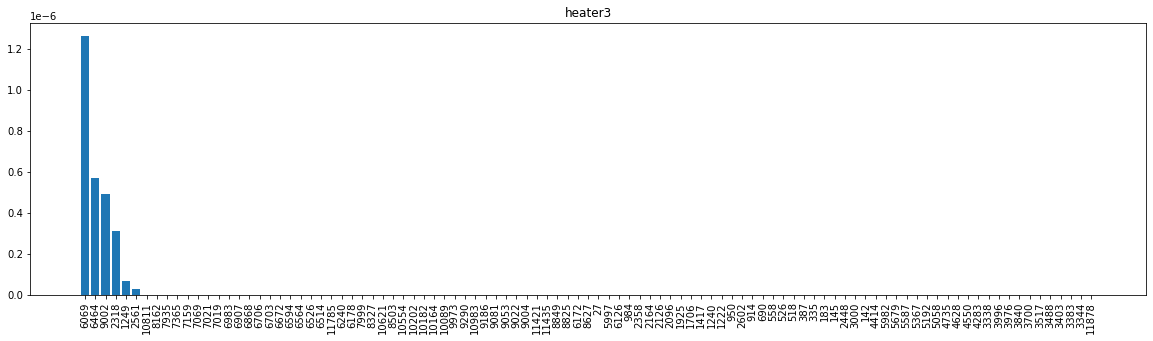

<Figure size 432x288 with 0 Axes>

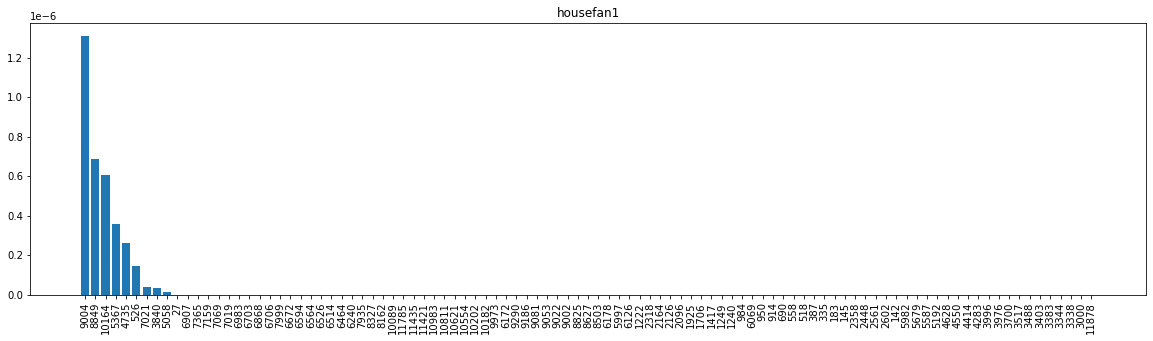

<Figure size 432x288 with 0 Axes>

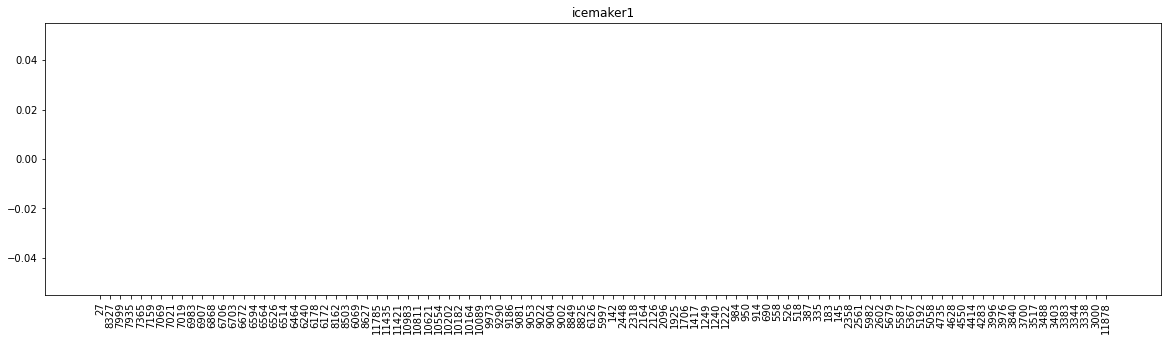

<Figure size 432x288 with 0 Axes>

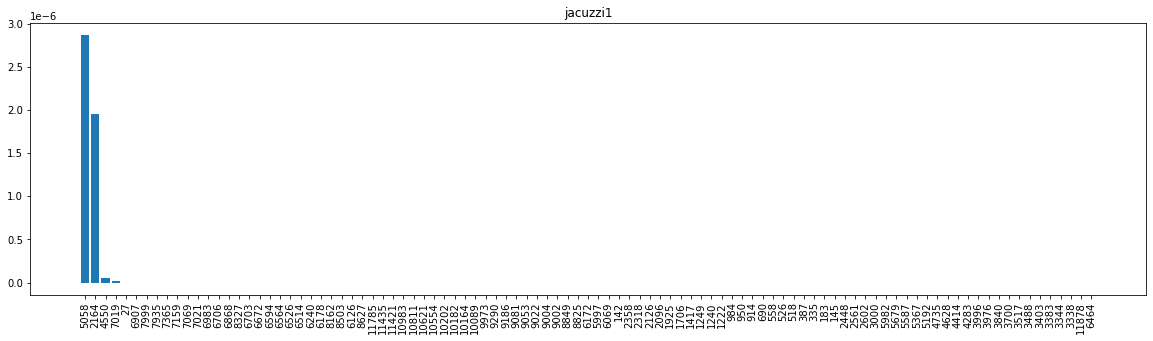

<Figure size 432x288 with 0 Axes>

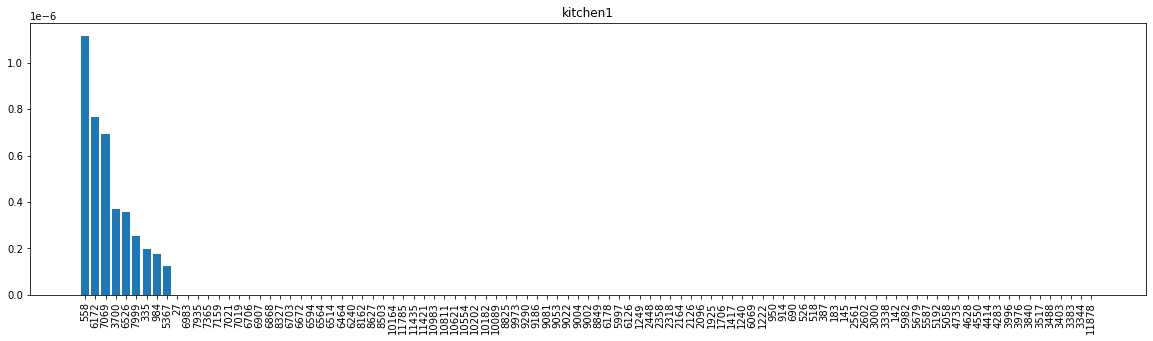

<Figure size 432x288 with 0 Axes>

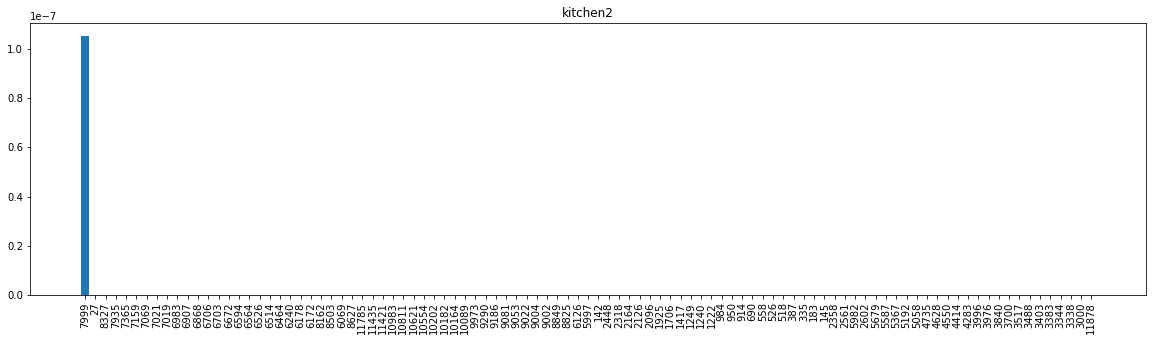

<Figure size 432x288 with 0 Axes>

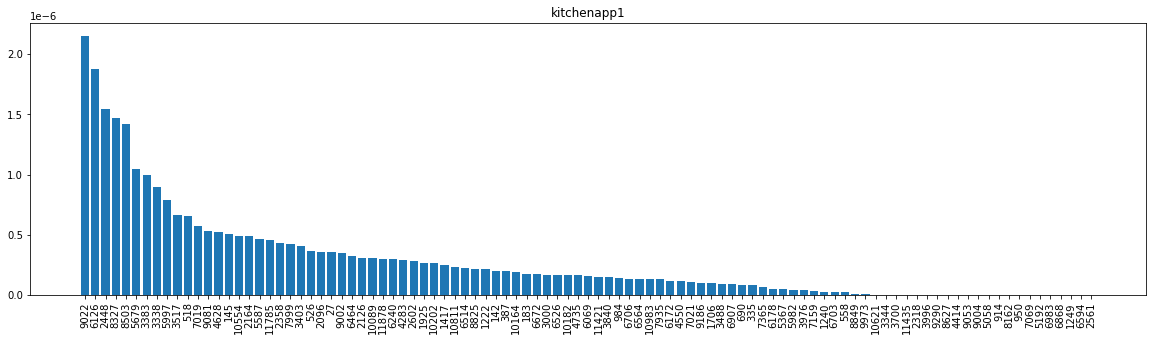

<Figure size 432x288 with 0 Axes>

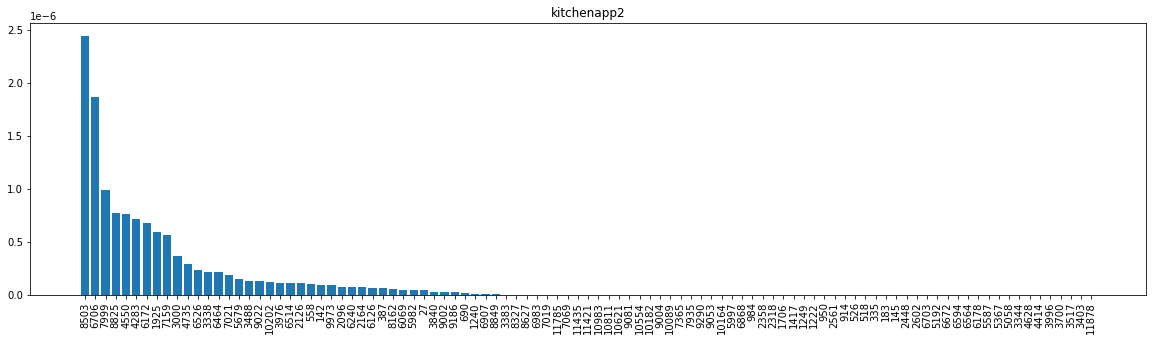

<Figure size 432x288 with 0 Axes>

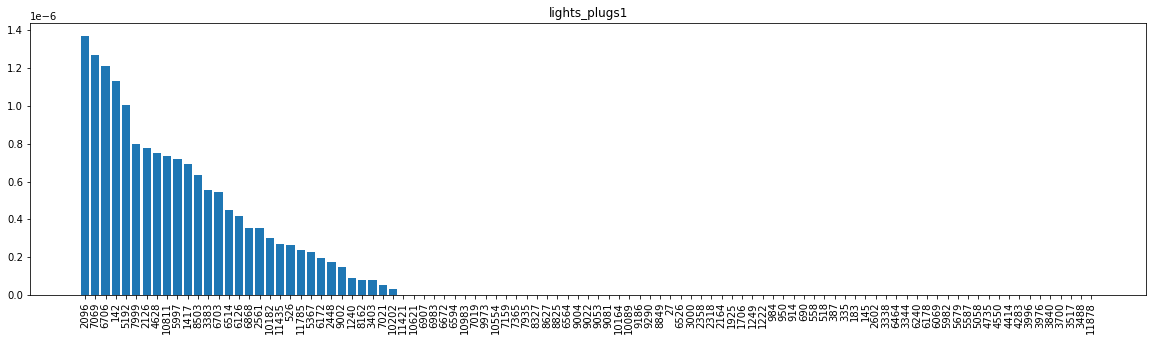

<Figure size 432x288 with 0 Axes>

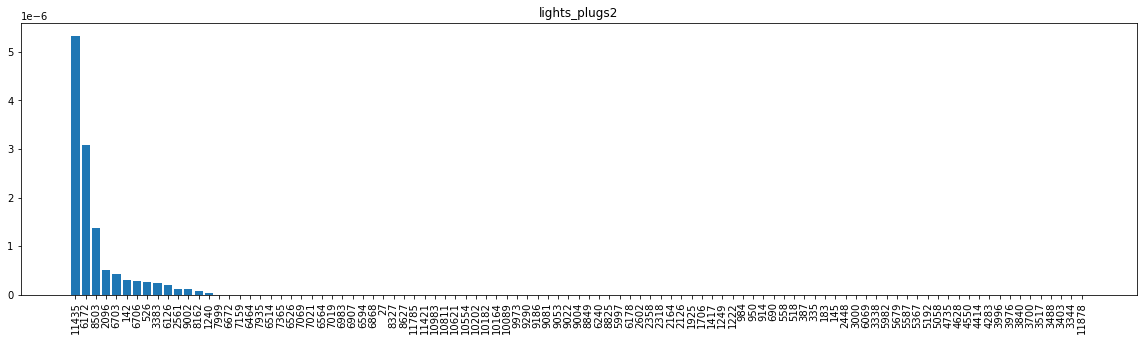

<Figure size 432x288 with 0 Axes>

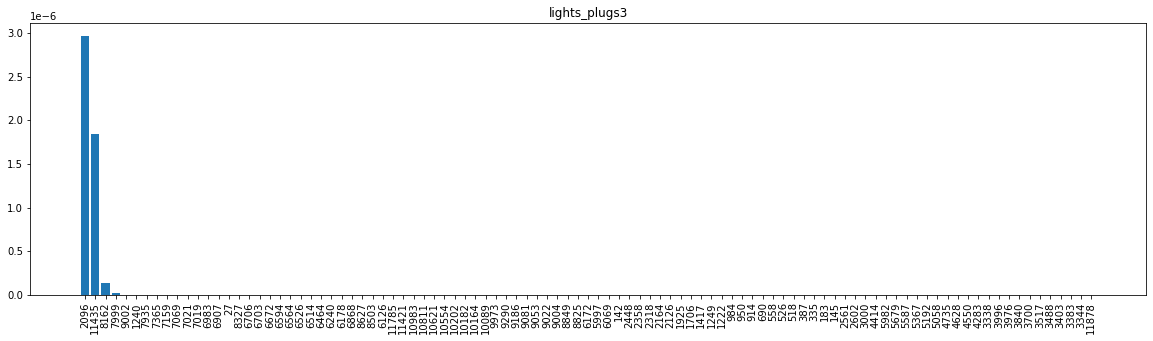

<Figure size 432x288 with 0 Axes>

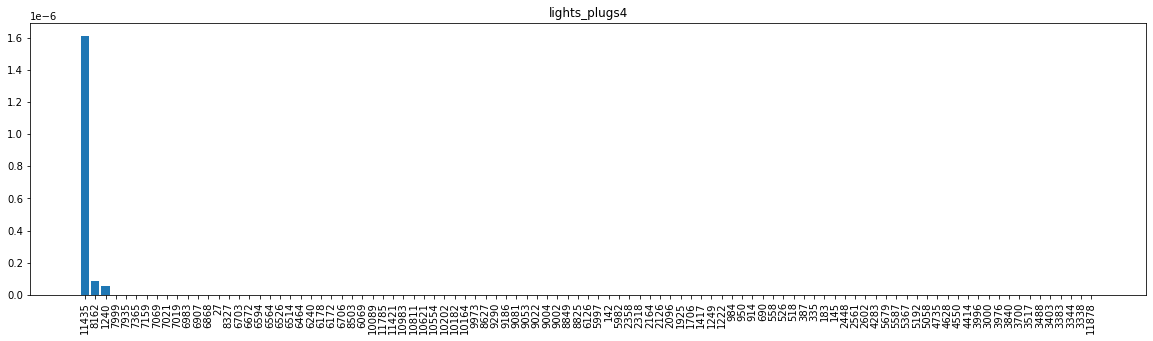

<Figure size 432x288 with 0 Axes>

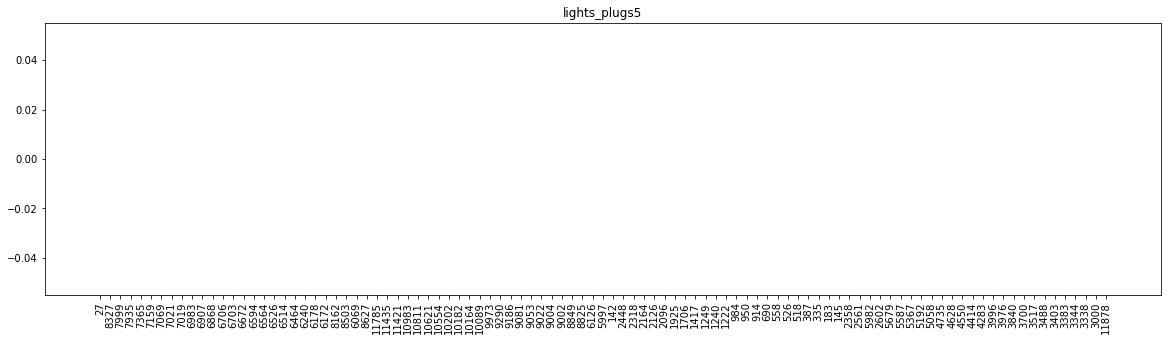

<Figure size 432x288 with 0 Axes>

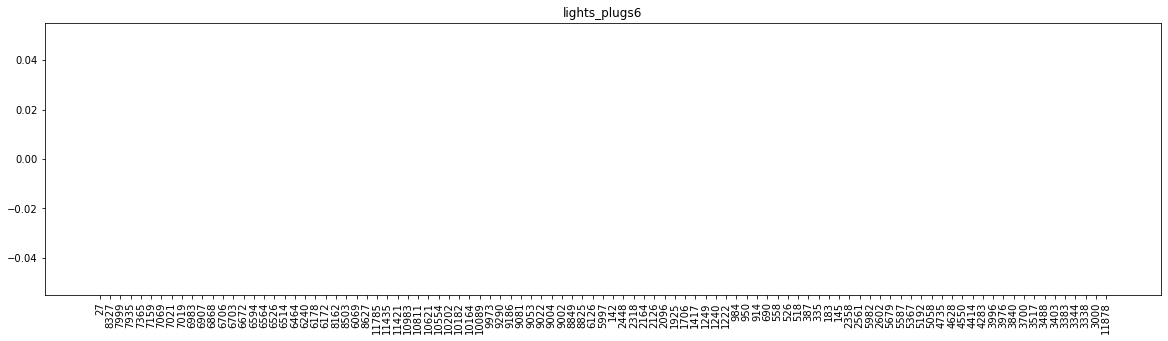

<Figure size 432x288 with 0 Axes>

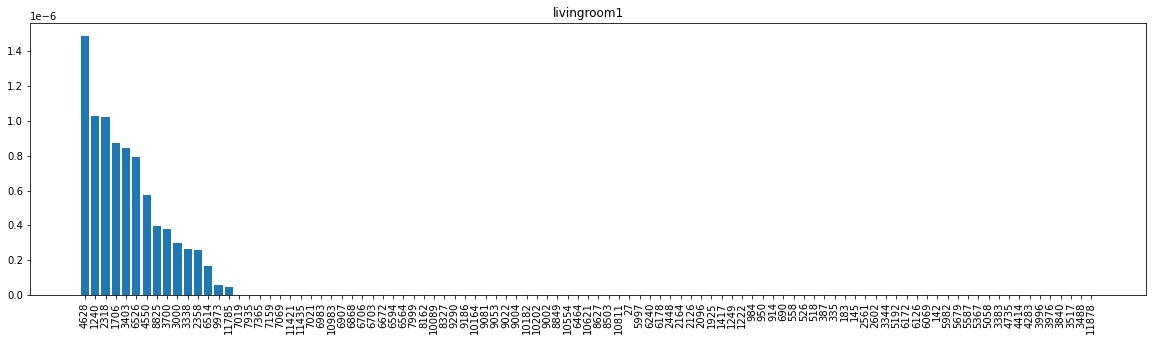

<Figure size 432x288 with 0 Axes>

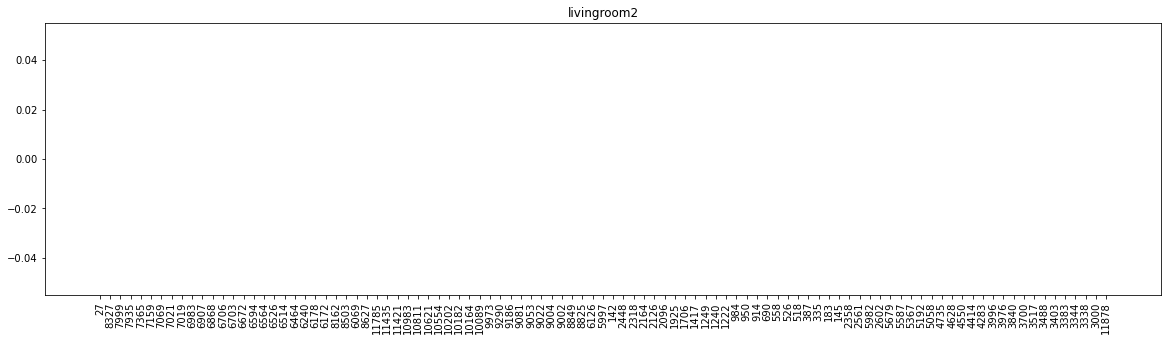

<Figure size 432x288 with 0 Axes>

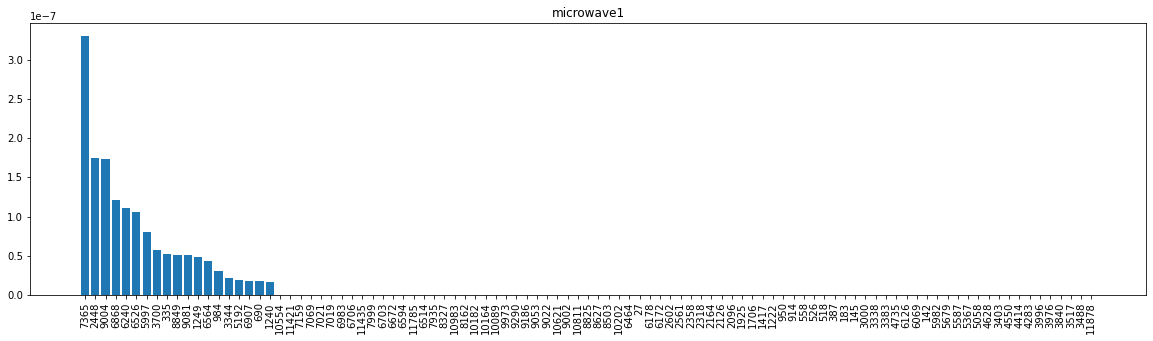

<Figure size 432x288 with 0 Axes>

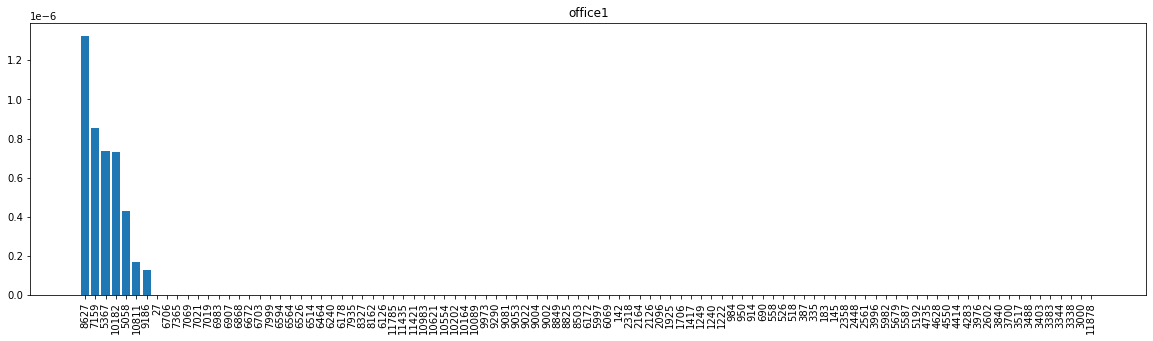

<Figure size 432x288 with 0 Axes>

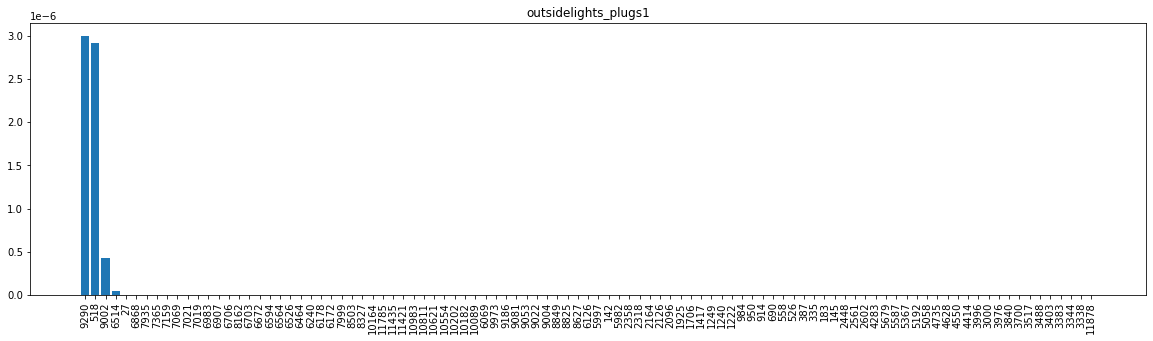

<Figure size 432x288 with 0 Axes>

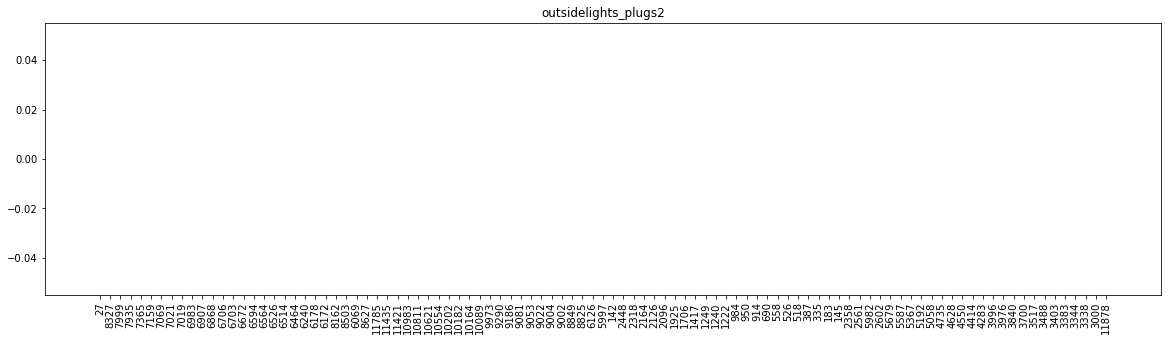

<Figure size 432x288 with 0 Axes>

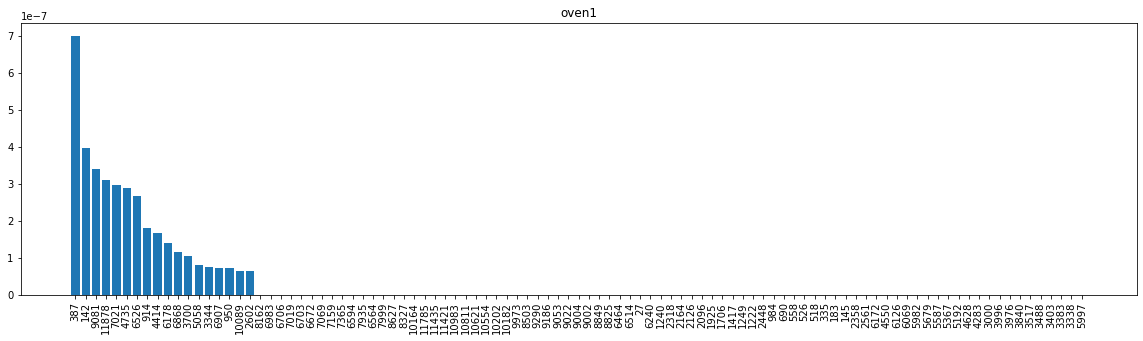

<Figure size 432x288 with 0 Axes>

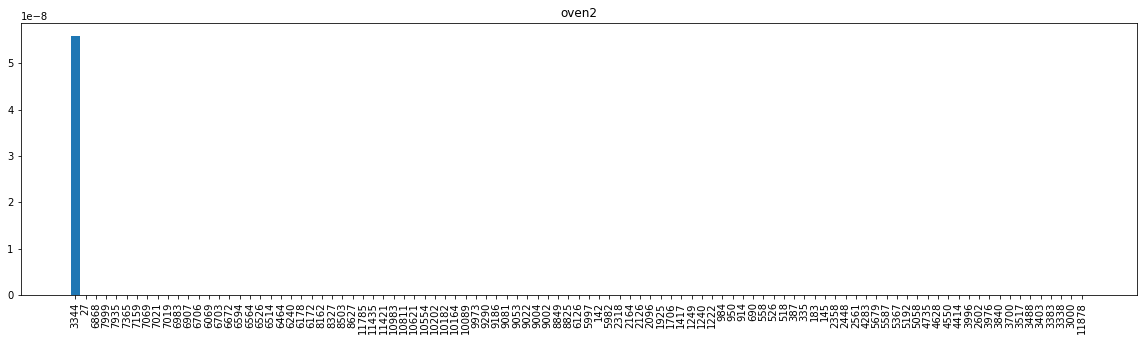

<Figure size 432x288 with 0 Axes>

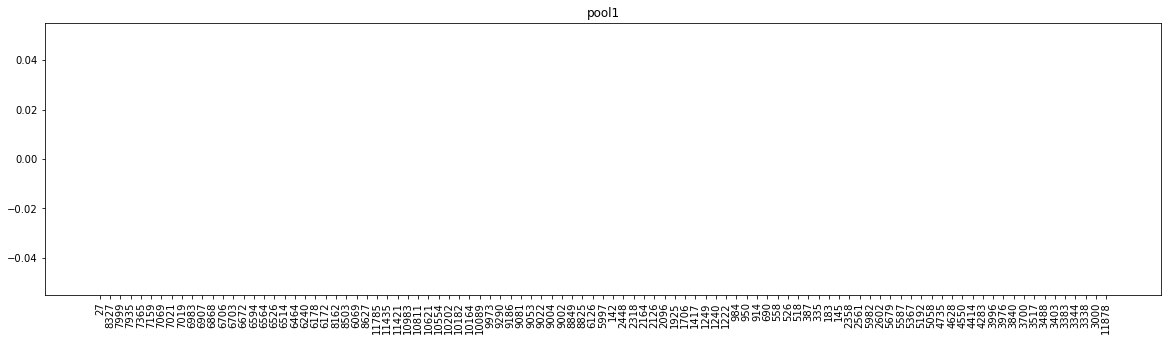

<Figure size 432x288 with 0 Axes>

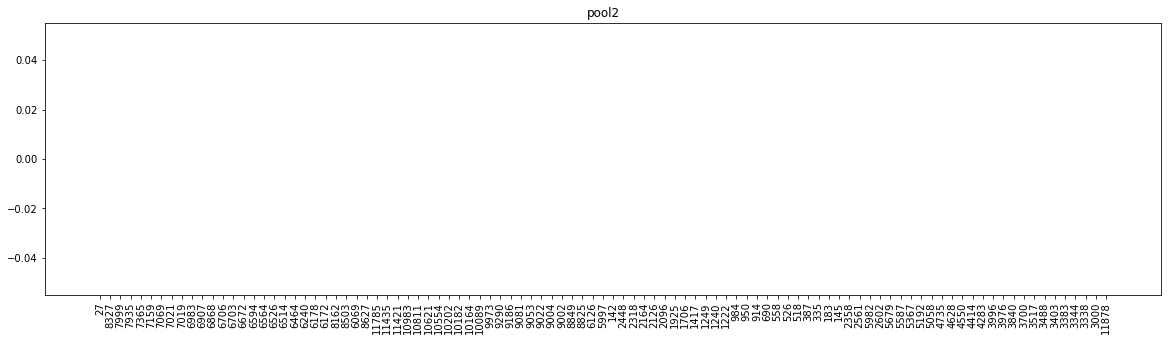

<Figure size 432x288 with 0 Axes>

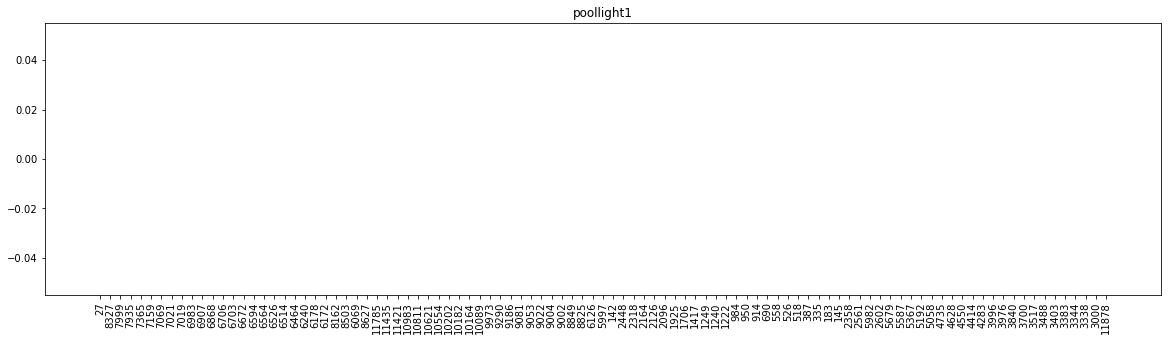

<Figure size 432x288 with 0 Axes>

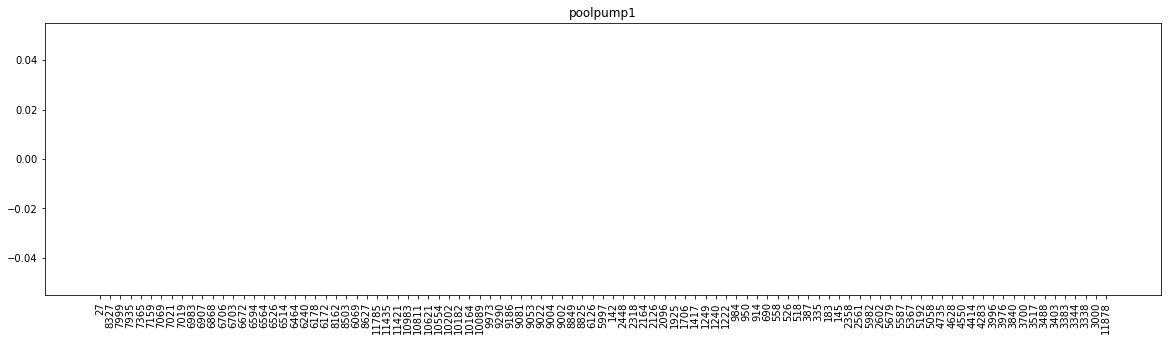

<Figure size 432x288 with 0 Axes>

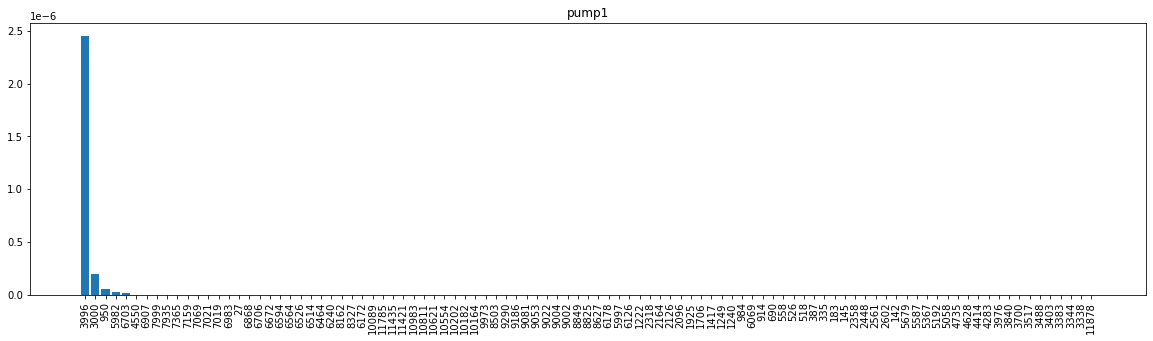

<Figure size 432x288 with 0 Axes>

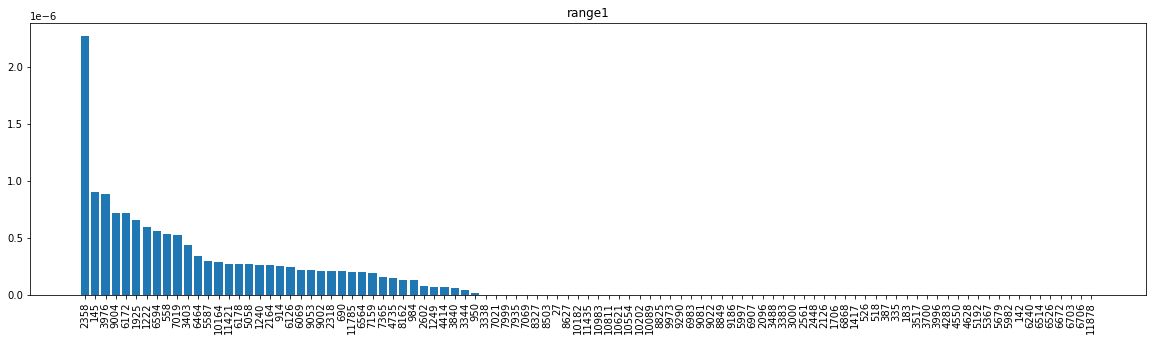

<Figure size 432x288 with 0 Axes>

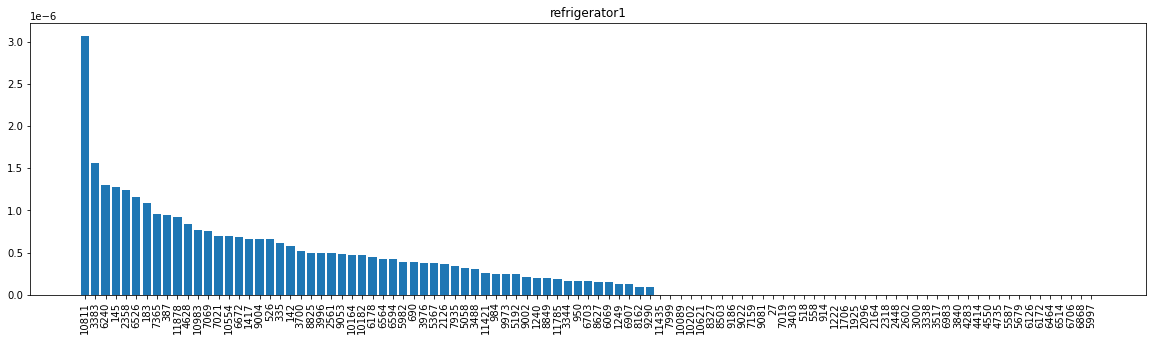

<Figure size 432x288 with 0 Axes>

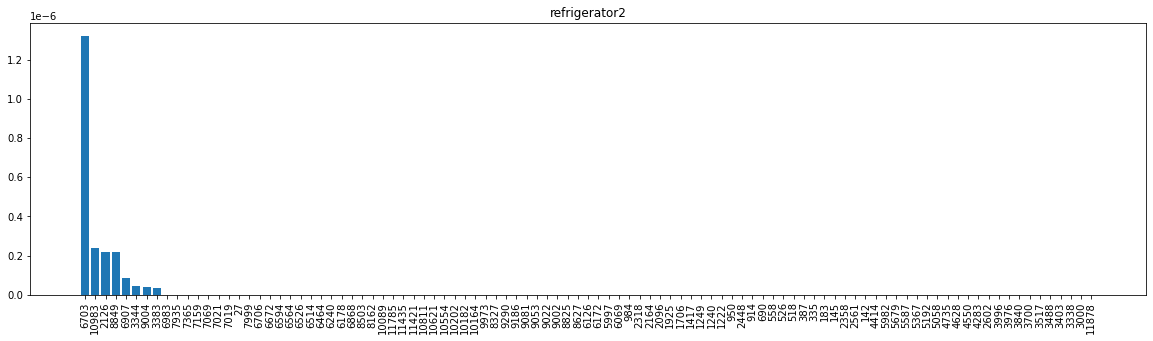

<Figure size 432x288 with 0 Axes>

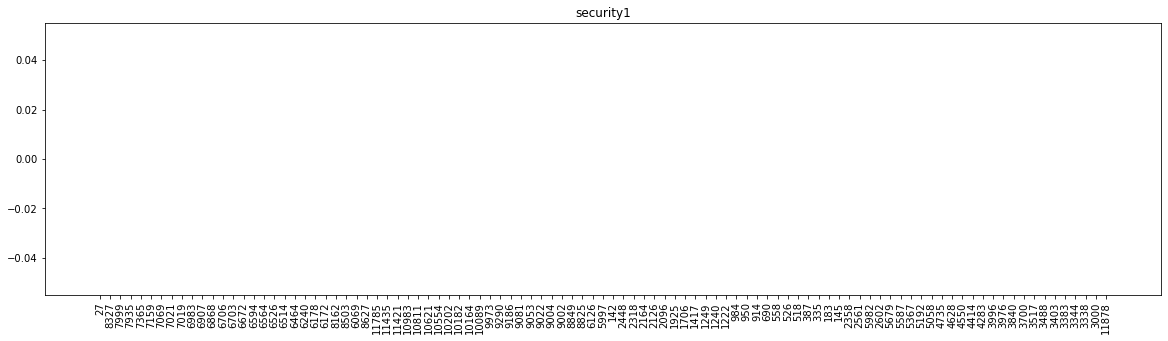

<Figure size 432x288 with 0 Axes>

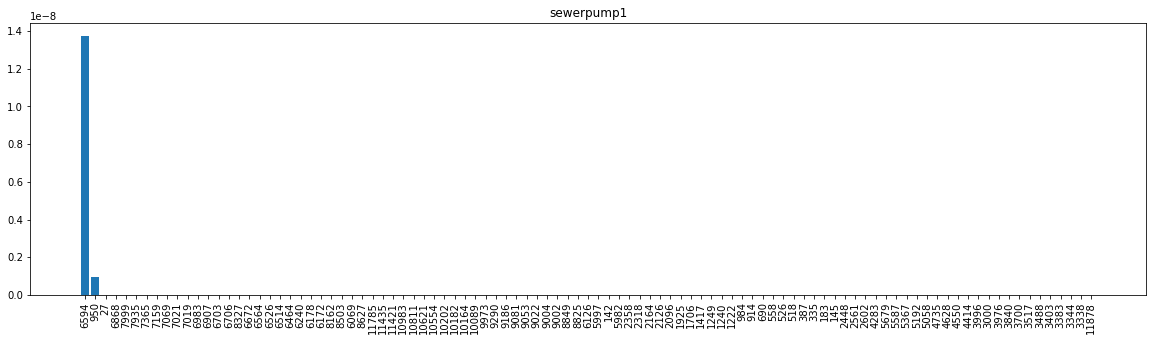

<Figure size 432x288 with 0 Axes>

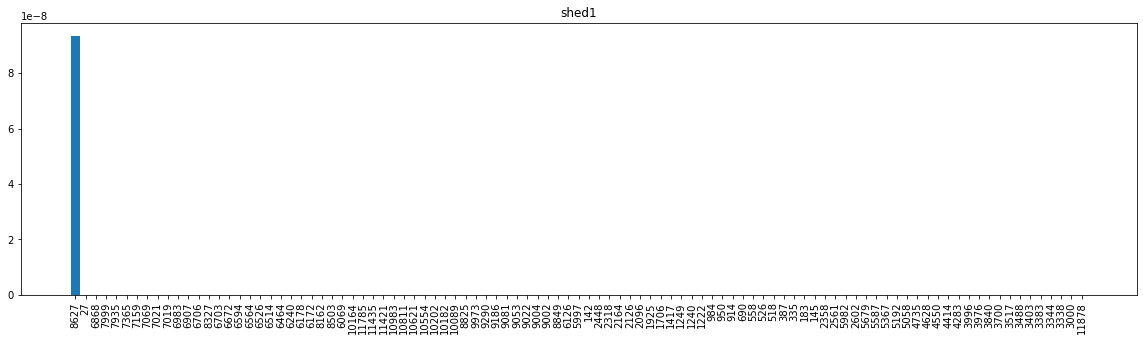

<Figure size 432x288 with 0 Axes>

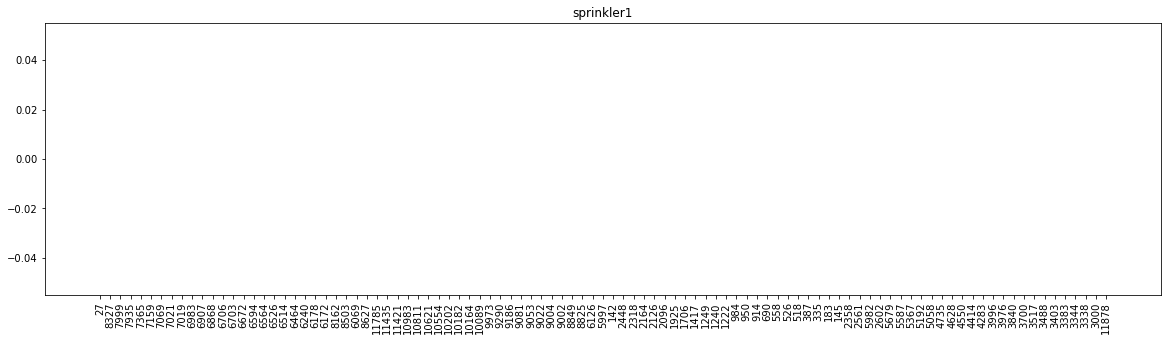

<Figure size 432x288 with 0 Axes>

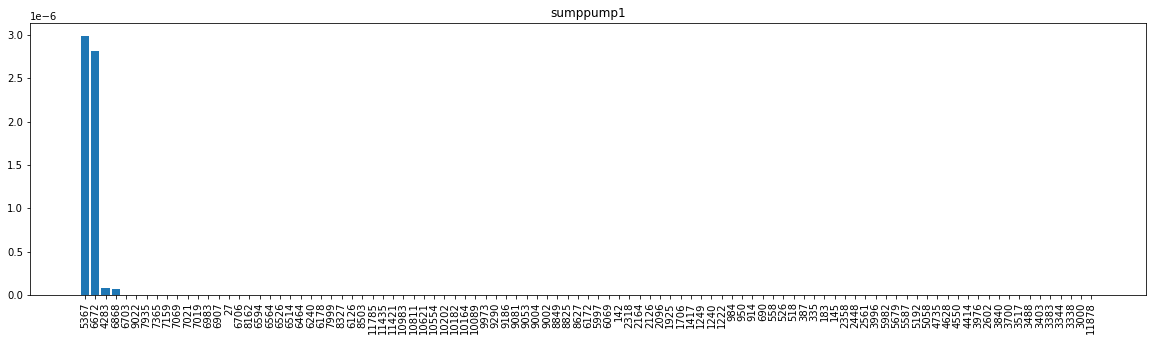

<Figure size 432x288 with 0 Axes>

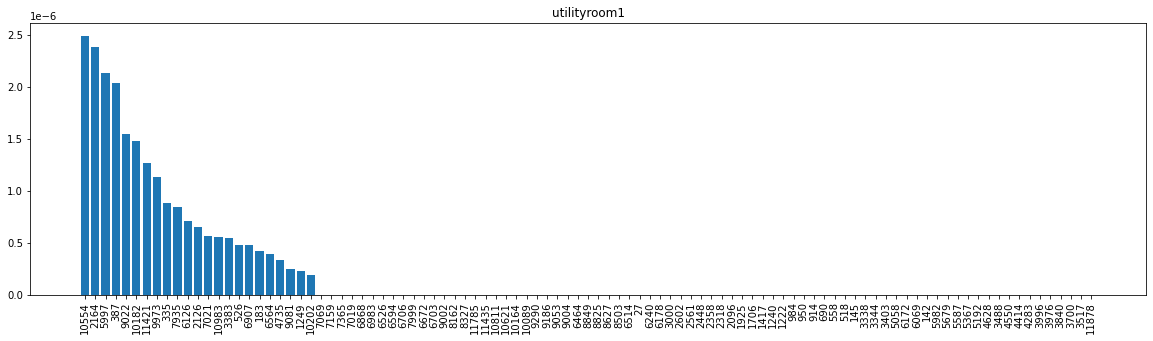

<Figure size 432x288 with 0 Axes>

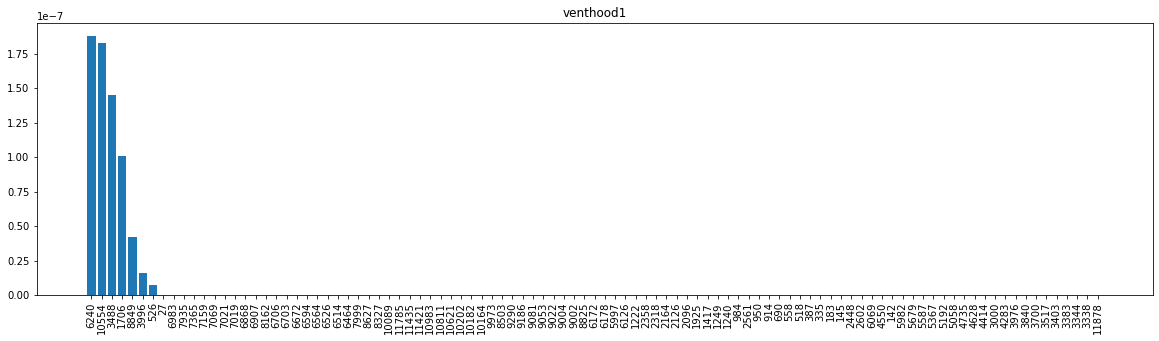

<Figure size 432x288 with 0 Axes>

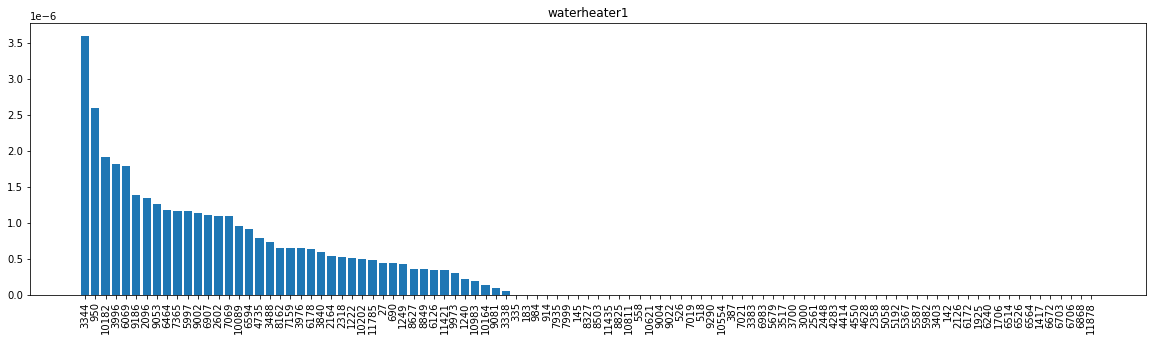

<Figure size 432x288 with 0 Axes>

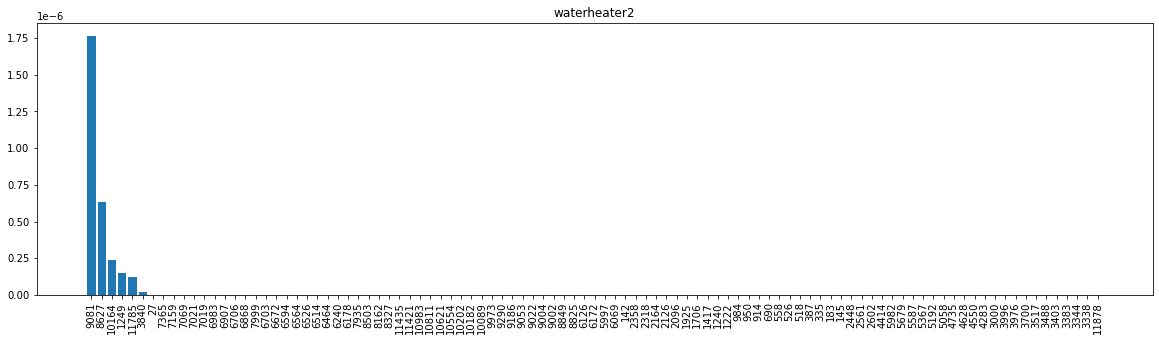

<Figure size 432x288 with 0 Axes>

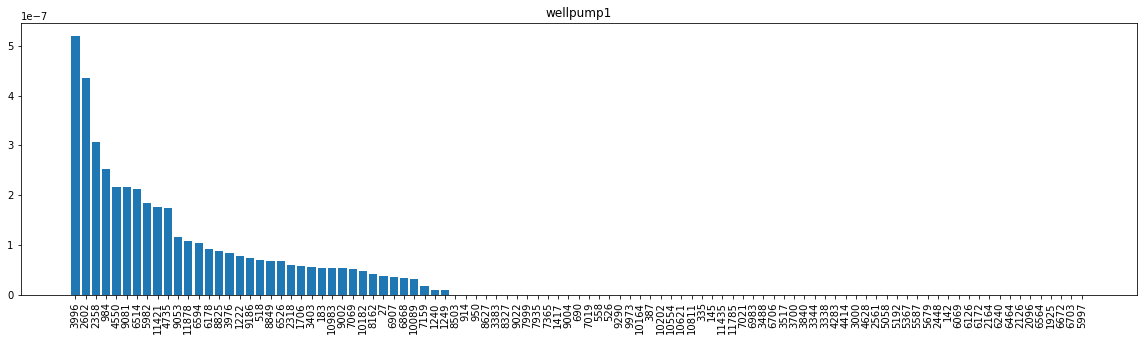

<Figure size 432x288 with 0 Axes>

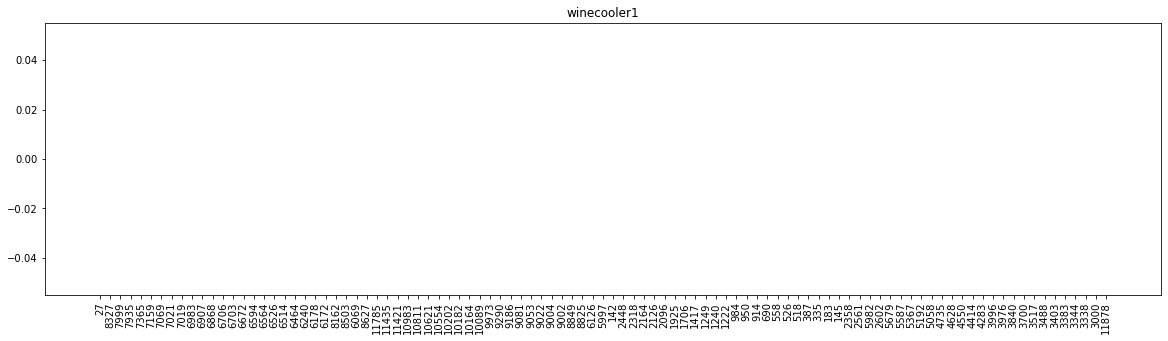

In [60]:
#plots for appliance/mains power consumption for each home (relative to entire home)
for column in appliance_over_mains.columns:
    appliance = appliance_over_mains.sort_values(by=str(column), ascending=False)
    plt.figure()
    plt.figure(figsize=(20,5))
    plt.bar(appliance.index.astype('str'), appliance[str(column)].values)
    plt.xticks(rotation=90)
    plt.title(str(column))

In [61]:
df_time_lengths = pd.read_csv(path, usecols = ['dataid', 'localminute'])

In [62]:
df_time_lengths['localminute']= pd.to_datetime(df_time_lengths['localminute'])

In [63]:
df_time_lengths_ids = df_time_lengths.dataid.unique()

In [64]:
min_max_times = {}
for i in df_time_lengths_ids:
    df_temp = df_time_lengths.loc[df_time_lengths.dataid == i]
    min_max_times.update({i:[min(df_temp.localminute), max(df_temp.localminute)]})

In [65]:
df_time_lengths_new = pd.DataFrame(min_max_times).transpose()

In [66]:
df_time_lengths_new['time_differences'] = df_time_lengths_new[1] - df_time_lengths_new[0]

In [67]:
df_time_lengths_new = df_time_lengths_new.sort_values(by='time_differences', ascending=True)

(array([18140., 18154., 18170., 18184., 18201., 18215., 18231.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

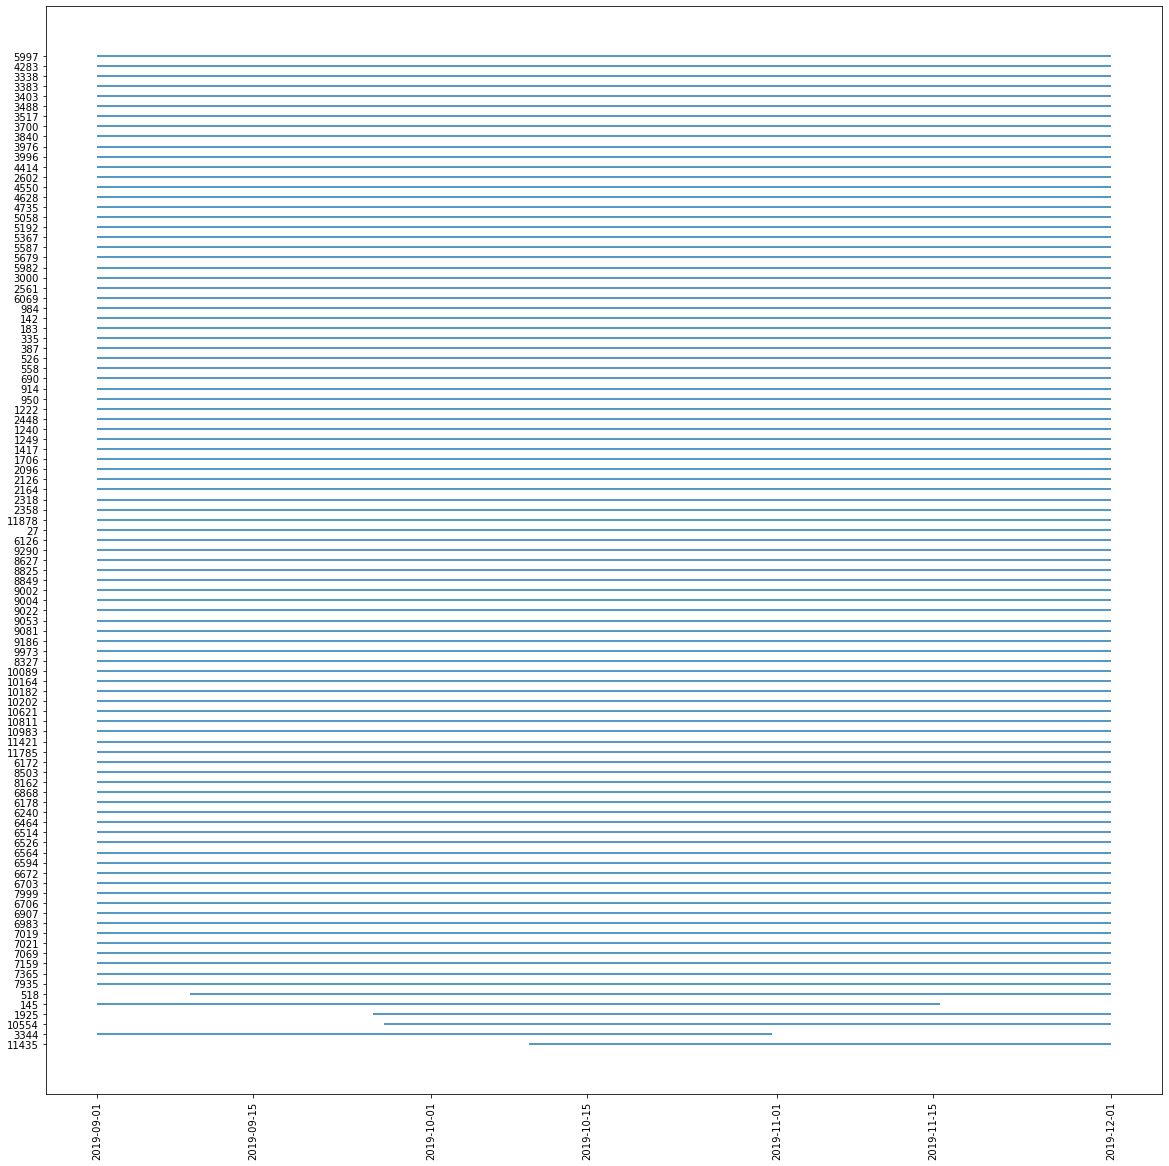

In [68]:
plt.figure(figsize=(20,20))
plt.hlines(df_time_lengths_new.index.astype(str), df_time_lengths_new[0], df_time_lengths_new[1])
plt.xticks(rotation=90)

In [69]:
path_dec = r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\input\1min_real_dec2019.csv"

In [70]:
df_dec = pd.read_csv(path_dec, usecols = ['dataid', 'localminute'])

In [71]:
df_dec['localminute']= pd.to_datetime(df_dec['localminute'])

In [72]:
df_dec_ids = df_dec.dataid.unique()

In [73]:
min_max_times_dec = {}
for i in df_dec_ids:
    df_temp = df_dec.loc[df_dec.dataid == i]
    min_max_times_dec.update({i:[min(df_temp.localminute), max(df_temp.localminute)]})

In [74]:
df_dec_new = pd.DataFrame(min_max_times_dec).transpose()

In [75]:
df_dec_new['time_differences'] = df_dec_new[1] - df_dec_new[0]

In [76]:
df_dec_new = df_dec_new.sort_values(by='time_differences', ascending=True)

(array([18231., 18235., 18239., 18243., 18247., 18251., 18255., 18259.,
        18262.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

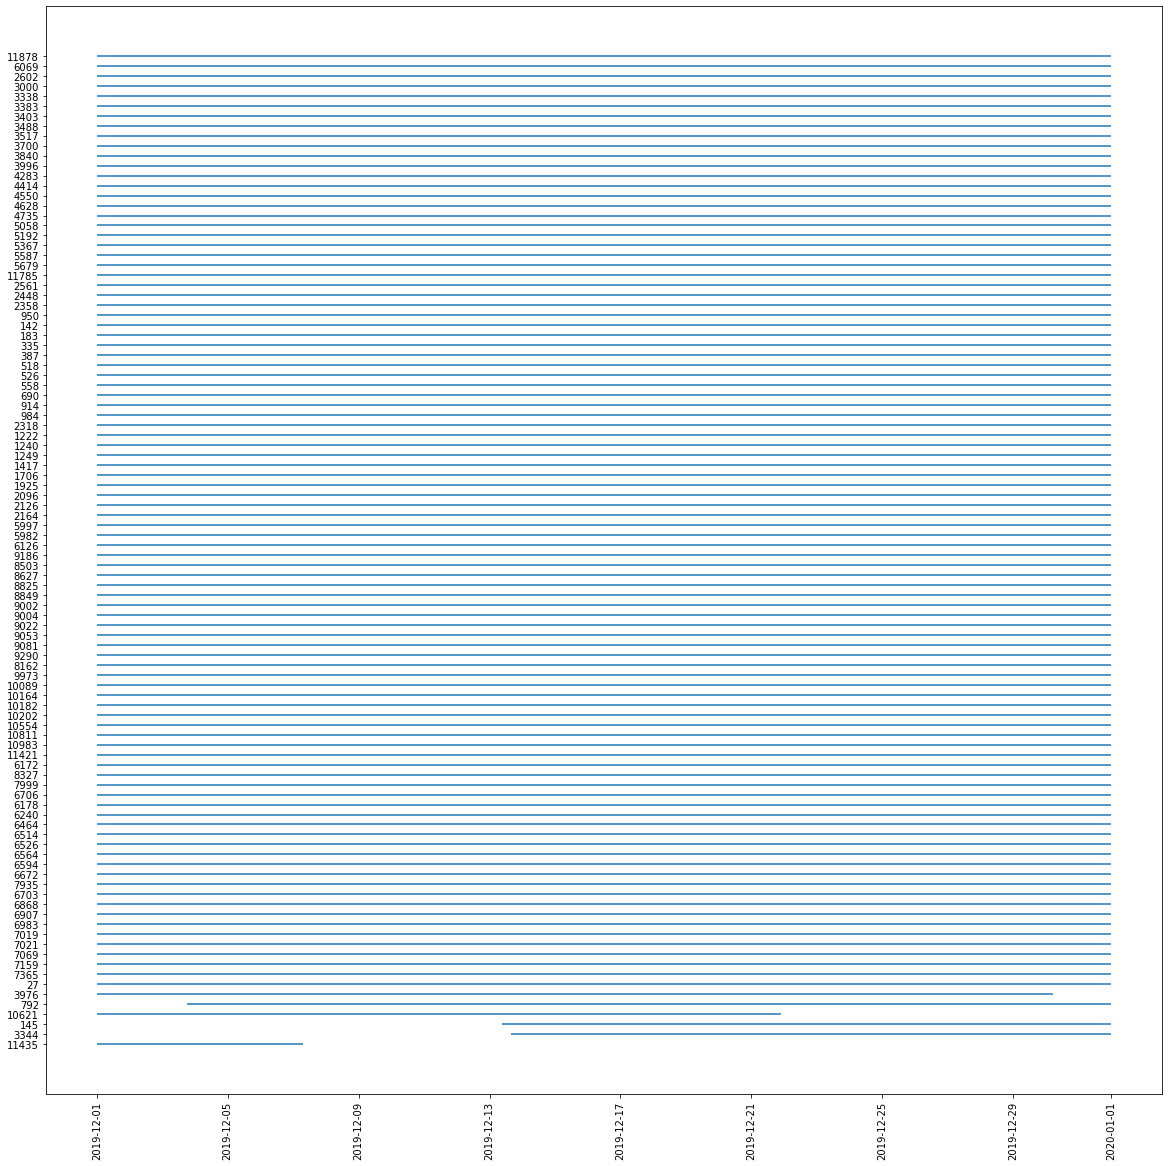

In [77]:
plt.figure(figsize=(20,20))
plt.hlines(df_dec_new.index.astype(str), df_dec_new[0], df_dec_new[1])
plt.xticks(rotation=90)

In [78]:
list1 = df_dec_new.index

In [79]:
list2 = df_time_lengths_new.index

In [80]:
df.groupby(df.dataid)

In [81]:
df[df < 10].groupby(df.dataid).count()

dataid    air1    air2    air3  airwindowunit1  aquarium1  bathroom1  \
dataid                                                                         
27           0   44787   66748  131100          131100     131100     131100   
142          0  131100  131100  131100          131100     131100     131100   
145          0  102600  102600  102600          102600     102600     102600   
183          0  131100  131100  131100          131100     131100     131100   
335          0  131100  131100  131100          131100     131100     131100   
...        ...     ...     ...     ...             ...        ...        ...   
10983        0  131100  131086  129820          131100     131100     131100   
11421        0   57459  131046  131046          131046     131046     131046   
11435        0   75240   75240   75240           75240      75240      75240   
11785        0  131100  131100  131100          131100     131100     131100   
11878        0  131100  131100  131100          131100     131100     131100   

        bathroom2  bedroom1  bedroom2  ...  sewerpump1   shed1  sprinkler1  \
dataid                                 ...                                   
27         131100    131100    131100  ...      131100  131100      131100   
142        131100    131100    131100  ...      131100  131100      131100   
145        102600    102600    102600  ...      102600  102600      102600   
183        131100    131100    131100  ...      131100  131100      131100   
335        131100    131100    131100  ...      131100  131100      131100   
...           ...       ...       ...  ...         ...     ...         ...   
10983      131100    131100    131100  ...      131100  131100      131100   
11421      131046    131046    131046  ...      131046  131046      131046   
11435       75240     75240     75240  ...       75240   75240       75240   
11785      131100    131100    131100  ...      131100  131100      131100   
11878      131100    131100    131100  ...      131100  131100      131100   

        sumppump1  utilityroom1  venthood1  waterheater1  waterheater2  \
dataid                                                                   
27         131100        131100     131100        109925        131100   
142        131100        131100     131100        131100        131100   
145        102600        102600     102600        102600        102600   
183        131100        115240     131100        131100        131100   
335        131100         90588     131100        131100        131100   
...           ...           ...        ...           ...           ...   
10983      131100        121778     131100        118273        131100   
11421      131046             2     131046        103466        131046   
11435       75240         75240      75240         75240         75240   
11785      131100        131100     131100        108940        130333   
11878      131100        131100     131100        131100        131100   

        wellpump1  winecooler1  
dataid                          
27         129619       131100  
142        131100       131100  
145        102600       102600  
183        129729       131100  
335        131100       131100  
...           ...          ...  
10983      129184       131100  
11421      125065       131046  
11435       75240        75240  
11785      131100       131100  
11878      128532       131100  

[99 rows x 73 columns]

In [82]:
#time spent on for each appliance
df[df > 100].groupby(df.dataid).count().div(df.groupby(df.dataid).count())

air1      air2      air3  airwindowunit1  aquarium1  bathroom1  \
dataid                                                                       
27      0.346918  0.049825  0.000000             0.0        0.0        0.0   
142     0.000000  0.000000  0.000000             0.0        0.0        0.0   
145     0.000000  0.000000  0.000000             0.0        0.0        0.0   
183     0.000000  0.000000  0.000000             0.0        0.0        0.0   
335     0.000000  0.000000  0.000000             0.0        0.0        0.0   
...          ...       ...       ...             ...        ...        ...   
10983   0.000000  0.000000  0.004012             0.0        0.0        0.0   
11421   0.132297  0.000000  0.000000             0.0        0.0        0.0   
11435   0.000000  0.000000  0.000000             0.0        0.0        0.0   
11785   0.000000  0.000000  0.000000             0.0        0.0        0.0   
11878   0.000000  0.000000  0.000000             0.0        0.0        0.0   

        bathroom2  battery1  bedroom1  bedroom2  ...  sewerpump1  shed1  \
dataid                                           ...                      
27            0.0       0.0       0.0       0.0  ...         0.0    0.0   
142           0.0       0.0       0.0       0.0  ...         0.0    0.0   
145           0.0       0.0       0.0       0.0  ...         0.0    0.0   
183           0.0       0.0       0.0       0.0  ...         0.0    0.0   
335           0.0       0.0       0.0       0.0  ...         0.0    0.0   
...           ...       ...       ...       ...  ...         ...    ...   
10983         0.0       0.0       0.0       0.0  ...         0.0    0.0   
11421         0.0       0.0       0.0       0.0  ...         0.0    0.0   
11435         0.0       0.0       0.0       0.0  ...         0.0    0.0   
11785         0.0       0.0       0.0       0.0  ...         0.0    0.0   
11878         0.0       0.0       0.0       0.0  ...         0.0    0.0   

        sprinkler1  sumppump1  utilityroom1  venthood1  waterheater1  \
dataid                                                                 
27             0.0        0.0      0.000000        0.0      0.155927   
142            0.0        0.0      0.000000        0.0      0.000000   
145            0.0        0.0      0.000000        0.0      0.000000   
183            0.0        0.0      0.088429        0.0      0.000000   
335            0.0        0.0      0.233288        0.0      0.000000   
...            ...        ...           ...        ...           ...   
10983          0.0        0.0      0.059314        0.0      0.090168   
11421          0.0        0.0      0.249859        0.0      0.205668   
11435          0.0        0.0      0.000000        0.0      0.000000   
11785          0.0        0.0      0.000000        0.0      0.168108   
11878          0.0        0.0      0.000000        0.0      0.000000   

        waterheater2  wellpump1  winecooler1  
dataid                                        
27          0.000000   0.010465          0.0  
142         0.000000   0.000000          0.0  
145         0.000000   0.000000          0.0  
183         0.000000   0.009237          0.0  
335         0.000000   0.000000          0.0  
...              ...        ...          ...  
10983       0.000000   0.012700          0.0  
11421       0.000000   0.043420          0.0  
11435       0.000000   0.000000          0.0  
11785       0.005782   0.000000          0.0  
11878       0.000000   0.017254          0.0  

[99 rows x 73 columns]

## Aggregate power summary

In [83]:
#Max aggregate power per home
max_grid_power = grid.groupby(grid.dataid).max().sort_values(by='total_grid',ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

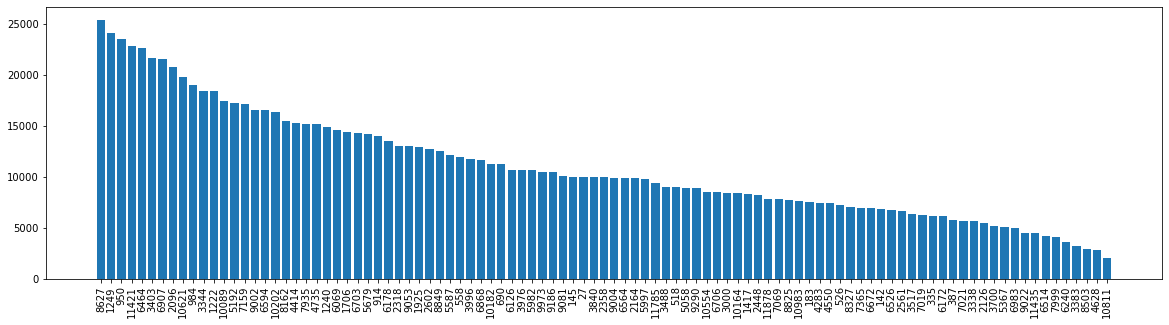

In [84]:
plt.figure(figsize=(20,5))
plt.bar(max_grid_power.index.astype('str'), max_grid_power.total_grid.values)
plt.xticks(rotation=90)

In [85]:
#Min aggregate power per home
min_grid_power = grid.groupby(grid.dataid).min().sort_values(by='total_grid',ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

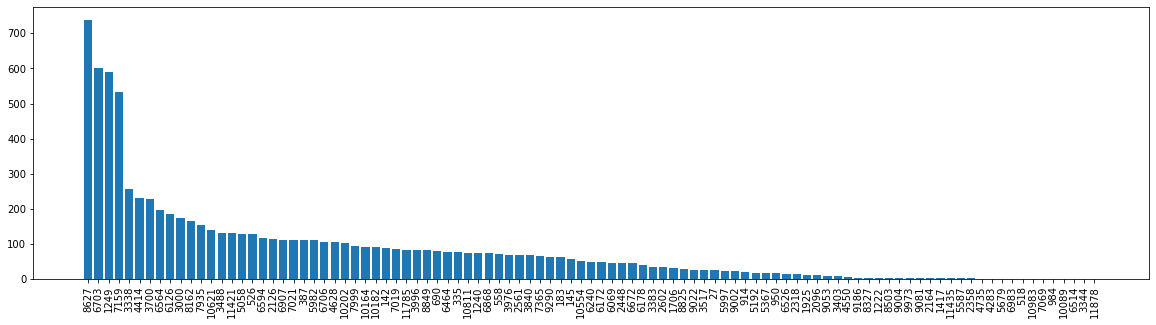

In [86]:
plt.figure(figsize=(20,5))
plt.bar(min_grid_power.index.astype('str'), min_grid_power.total_grid.values)
plt.xticks(rotation=90)

In [87]:
#Max - min aggregate power per home (range)
range_grid_power = grid.groupby(grid.dataid).max() - grid.groupby(grid.dataid).min()

In [88]:
range_grid_power = range_grid_power.sort_values(by='total_grid',ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

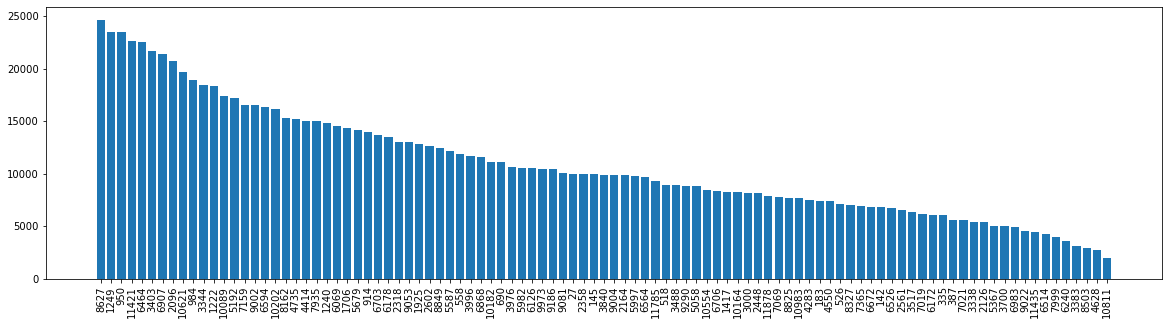

In [89]:
plt.figure(figsize=(20,5))
plt.bar(range_grid_power.index.astype('str'), range_grid_power.total_grid.values)
plt.xticks(rotation=90)

In [90]:
#Avg aggregate power per home
avg_grid_power = grid.groupby(grid.dataid).mean().sort_values(by='total_grid',ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
 

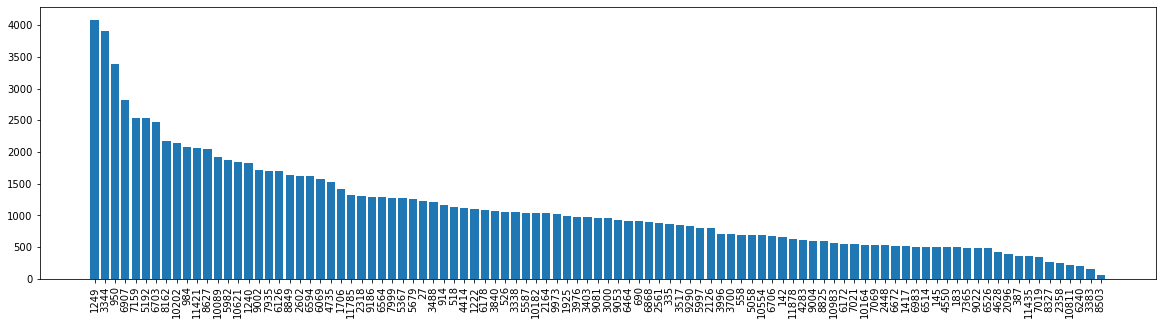

In [91]:
plt.figure(figsize=(20,5))
plt.bar(avg_grid_power.index.astype('str'), avg_grid_power.total_grid.values)
plt.xticks(rotation=90)

In [92]:
data_ids = grid.dataid.unique()

Home:  27 Skew:  2.0730779997537483
Home:  142 Skew:  2.847743915378042
Home:  145 Skew:  5.15181069309888
Home:  183 Skew:  3.1751894160336134
Home:  335 Skew:  1.7028048430848544
Home:  387 Skew:  5.496555895276385
Home:  518 Skew:  2.271418549106767
Home:  526 Skew:  1.939263127343279
Home:  558 Skew:  4.546528193351611
Home:  690 Skew:  2.4140947596658737
Home:  914 Skew:  2.996843356874314
Home:  950 Skew:  0.951225621366809
Home:  984 Skew:  1.8330873962546859
Home:  1222 Skew:  2.7758828542787835
Home:  1240 Skew:  1.9304478153968172
Home:  1249 Skew:  1.618873531182694
Home:  1417 Skew:  5.61277705170602
Home:  1706 Skew:  2.643462939462556
Home:  1925 Skew:  2.947514685865526
Home:  2096 Skew:  13.606335631152605
Home:  2126 Skew:  1.0530601491745586


<ipython-input-93-dd15d675478e>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Home:  2164 Skew:  2.95847793098042
Home:  2318 Skew:  3.2574496907295285
Home:  2358 Skew:  5.673299061953638
Home:  2448 Skew:  6.554983866149629
Home:  2561 Skew:  1.4150981833687937
Home:  2602 Skew:  2.3472946400529953
Home:  3000 Skew:  2.618800850016075
Home:  3338 Skew:  1.2144500151536808
Home:  3344 Skew:  0.9247537362733217
Home:  3383 Skew:  5.751768674741465
Home:  3403 Skew:  6.202350219688983
Home:  3488 Skew:  2.8200174295059415
Home:  3517 Skew:  2.615529599246339
Home:  3700 Skew:  2.915185521774533
Home:  3840 Skew:  1.2943291112437547
Home:  3976 Skew:  1.842159304397792
Home:  3996 Skew:  3.8946400599527515
Home:  4283 Skew:  3.8573296523726475
Home:  4414 Skew:  3.448842501032235
Home:  4550 Skew:  3.7877421393261774
Home:  4628 Skew:  1.5561911485505
Home:  4735 Skew:  2.6394358097138877
Home:  5058 Skew:  2.5539942399226954
Home:  5192 Skew:  1.9694316529921365
Home:  5367 Skew:  1.1108315136393812
Home:  5587 Skew:  2.320500370511344
Home:  5679 Skew:  3.056023

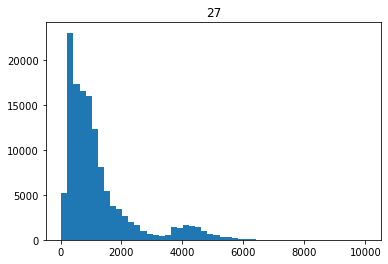

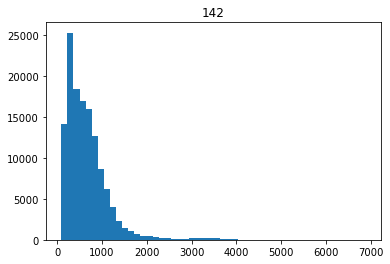

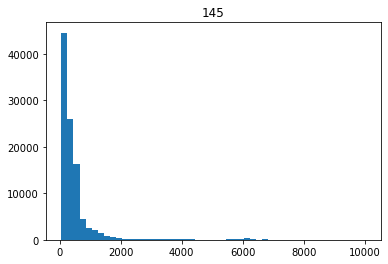

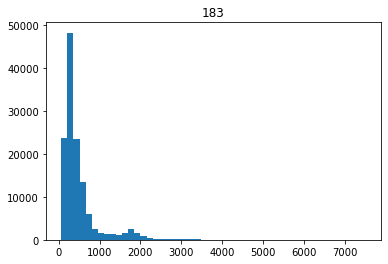

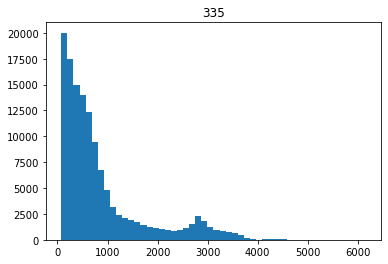

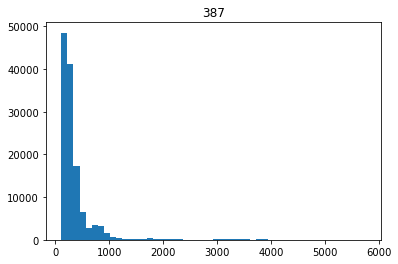

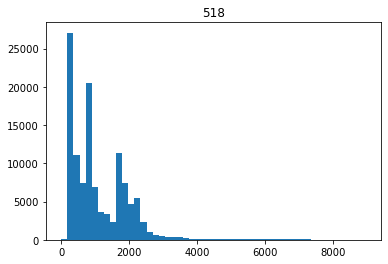

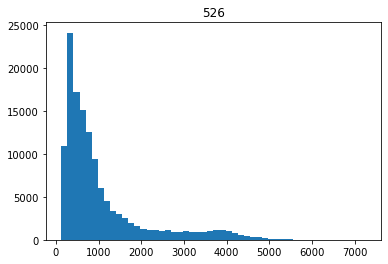

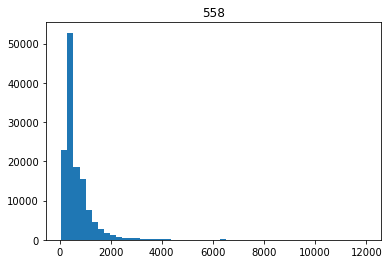

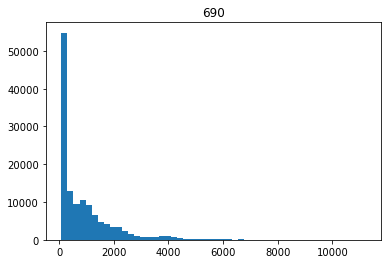

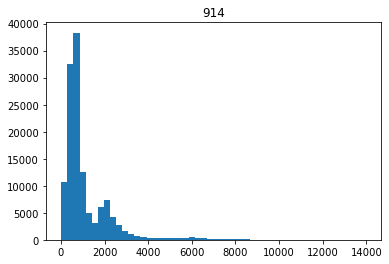

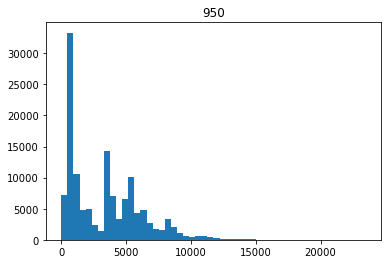

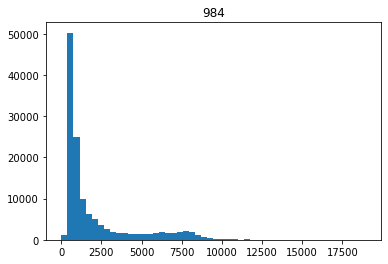

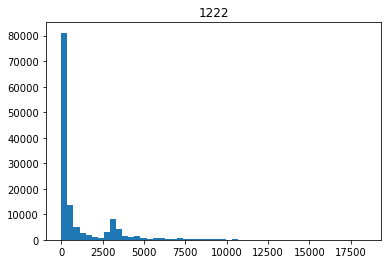

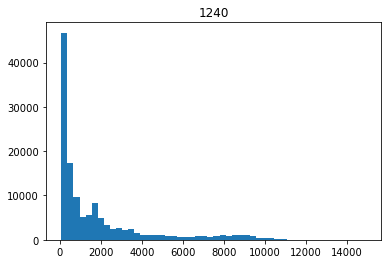

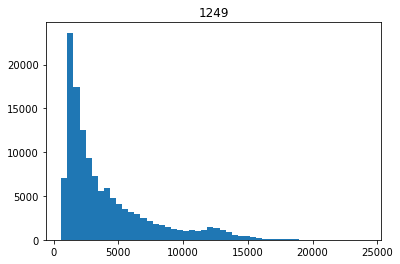

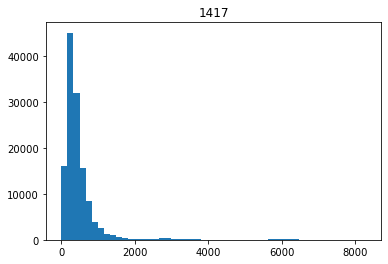

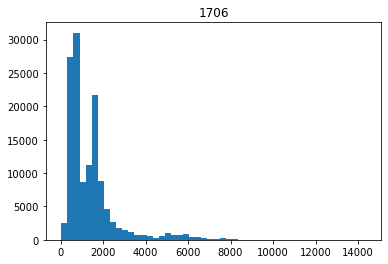

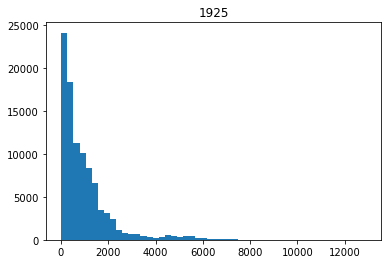

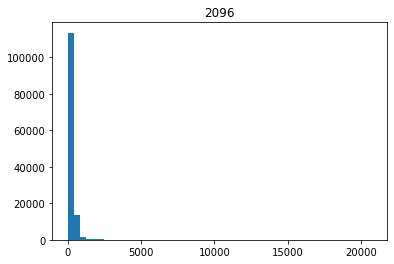

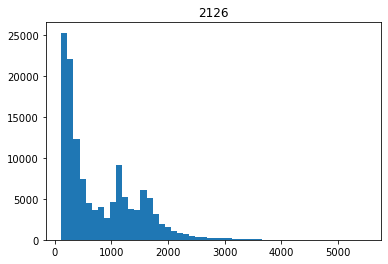

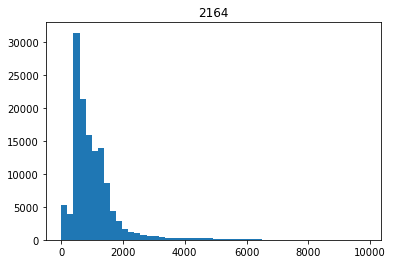

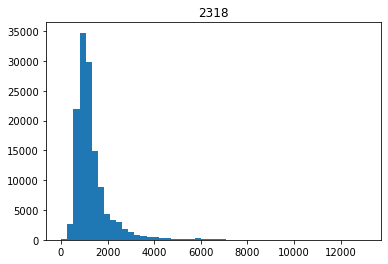

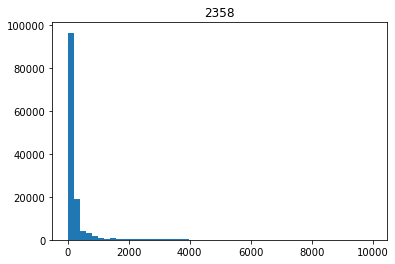

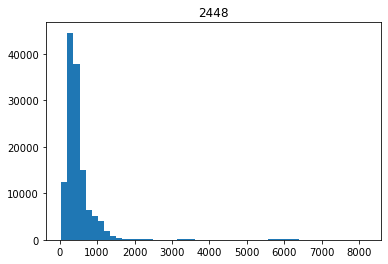

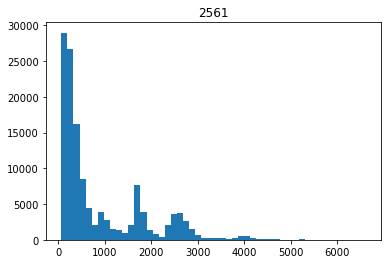

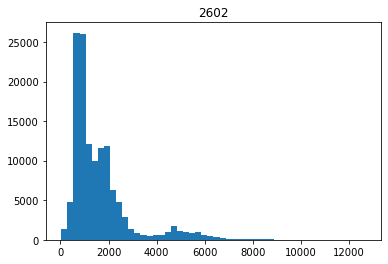

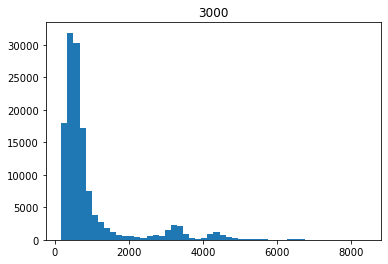

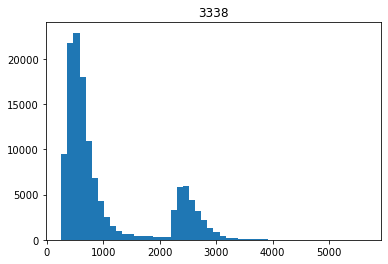

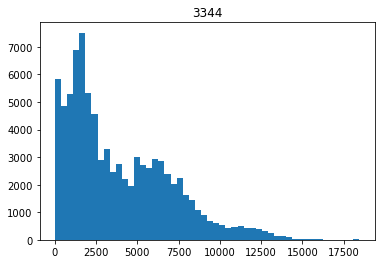

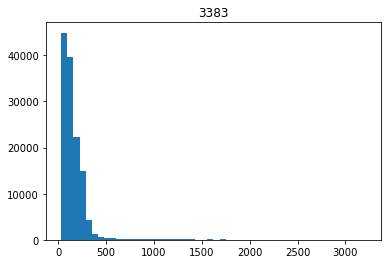

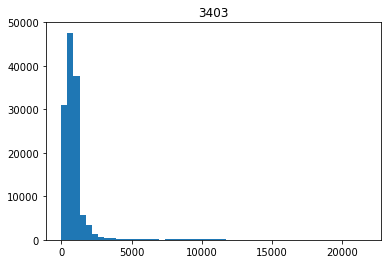

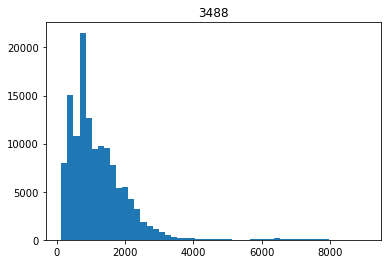

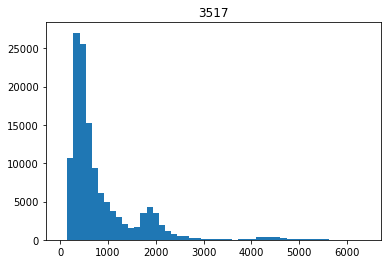

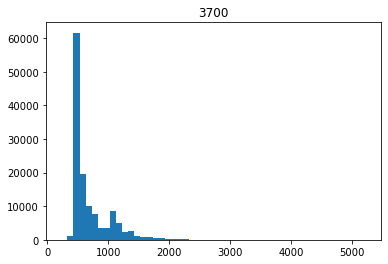

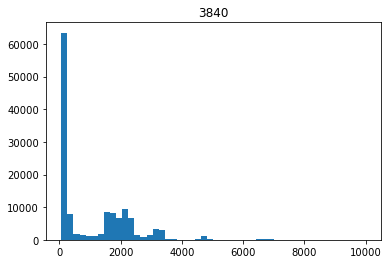

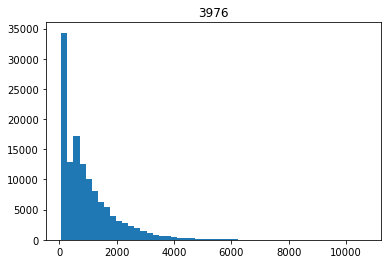

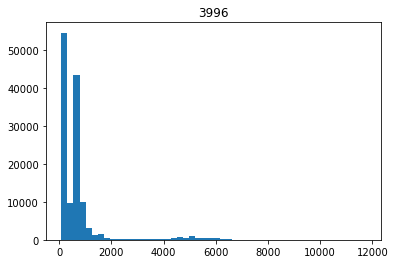

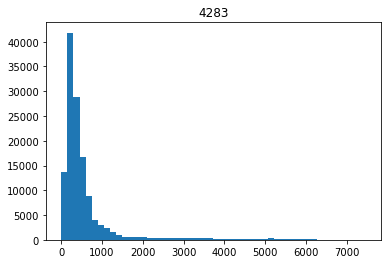

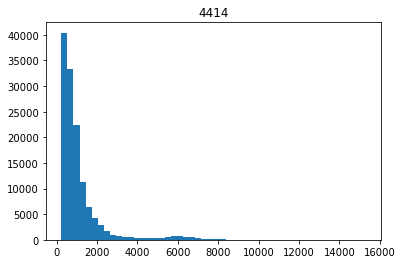

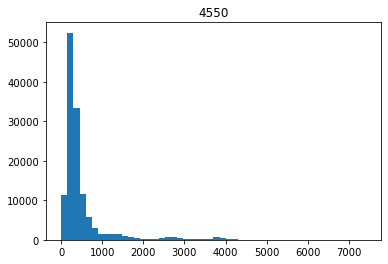

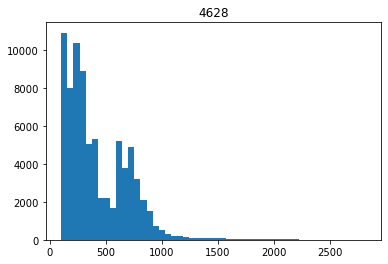

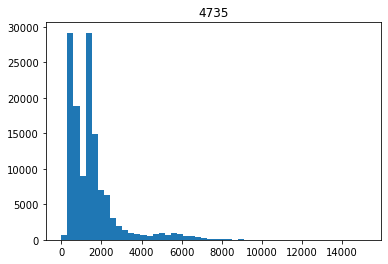

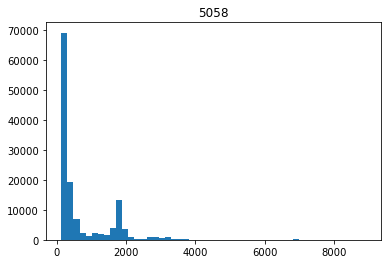

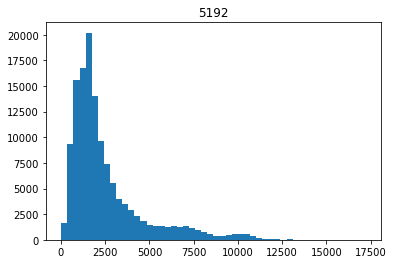

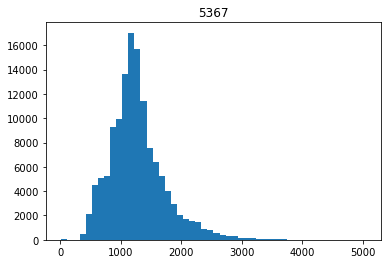

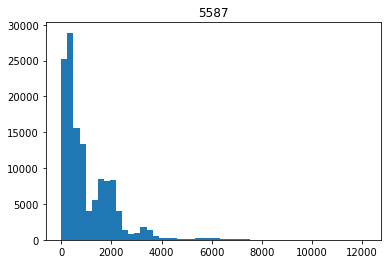

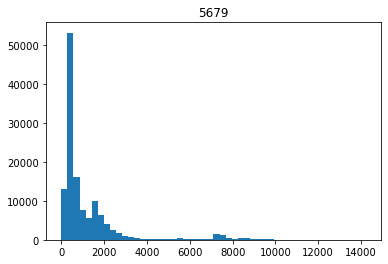

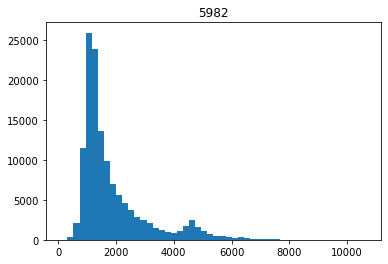

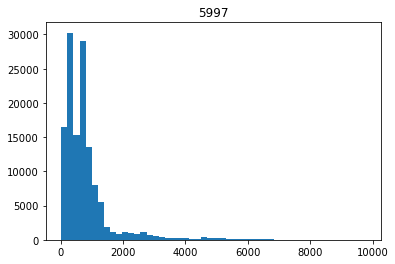

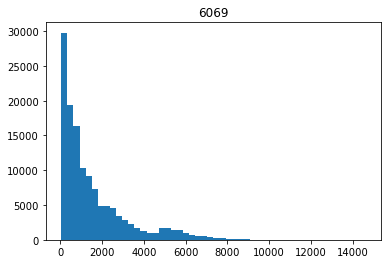

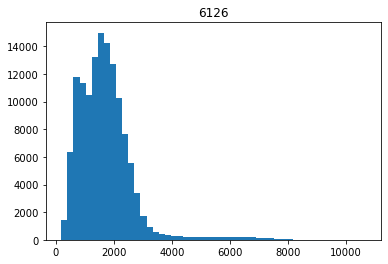

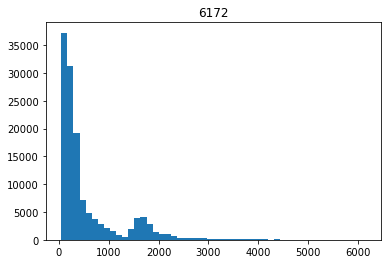

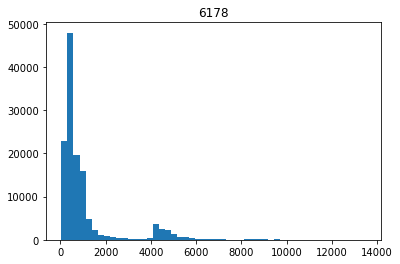

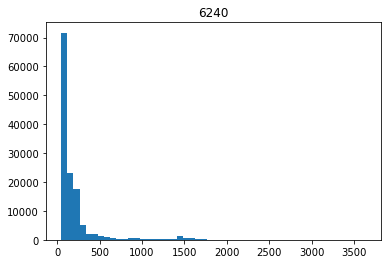

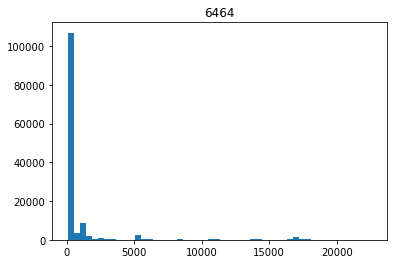

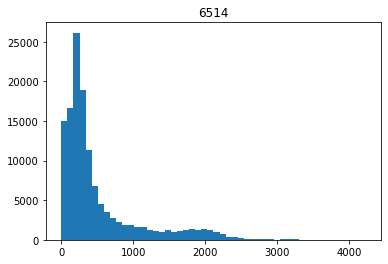

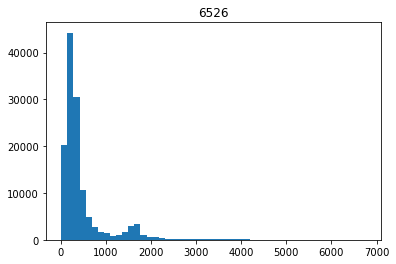

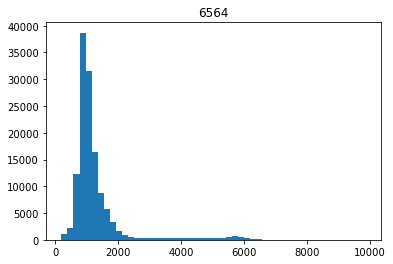

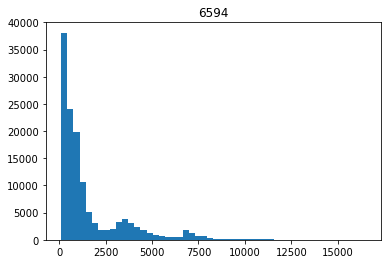

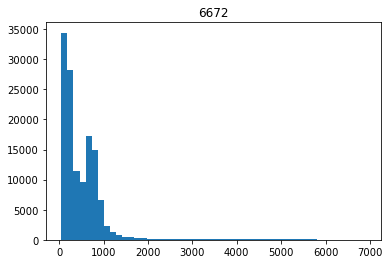

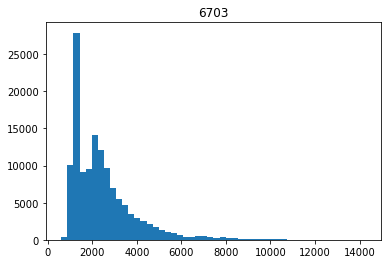

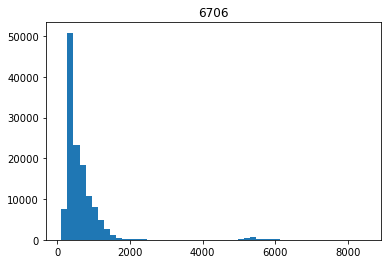

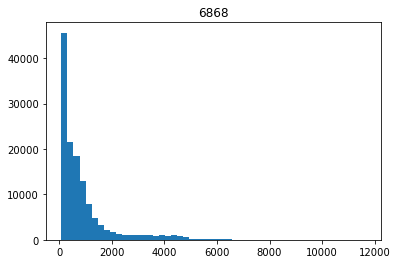

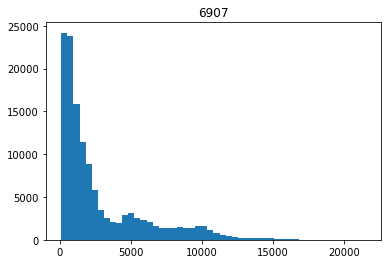

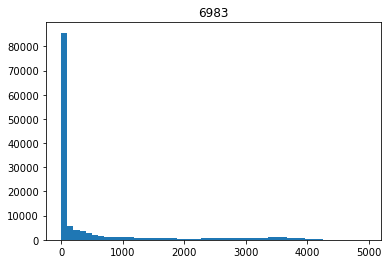

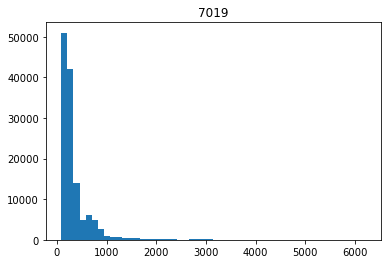

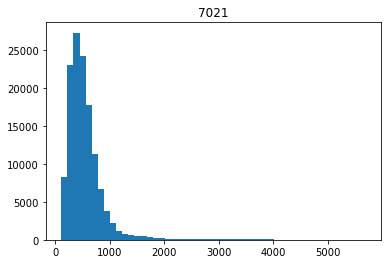

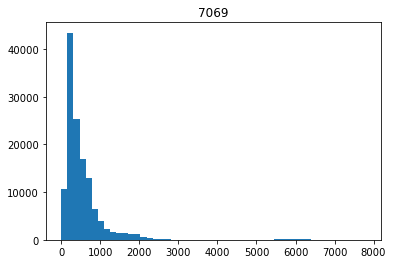

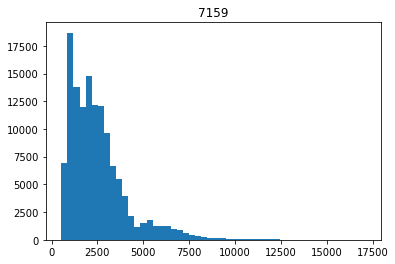

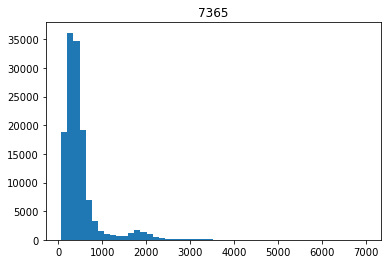

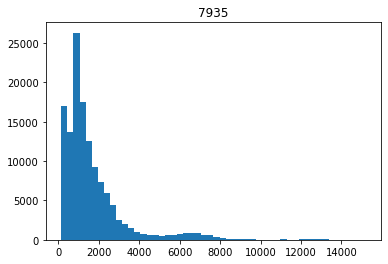

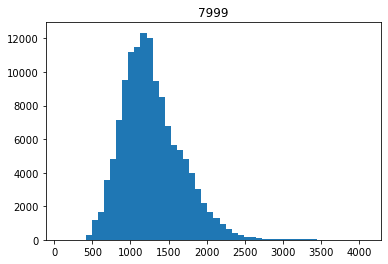

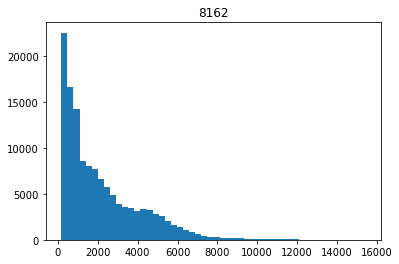

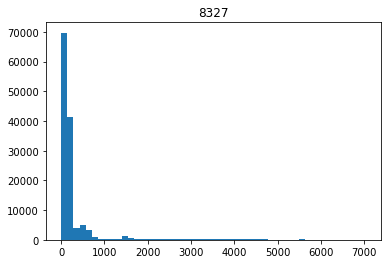

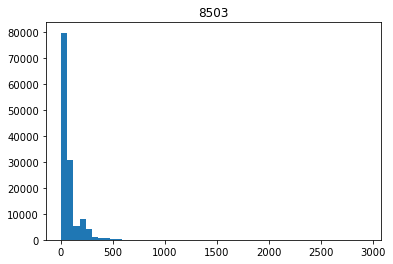

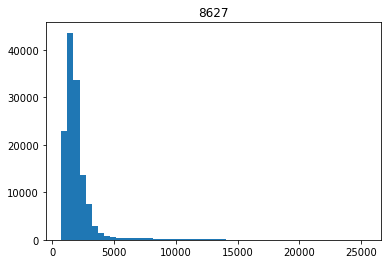

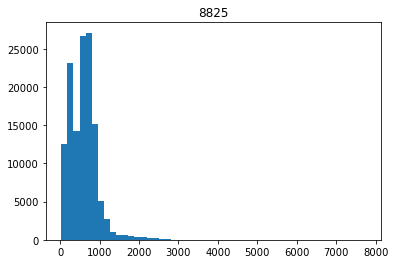

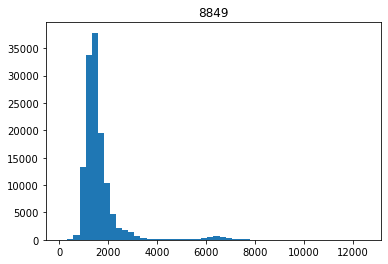

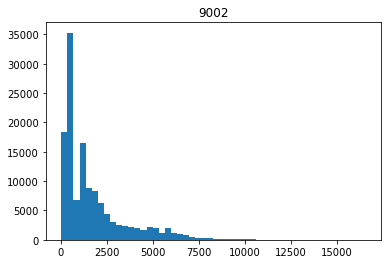

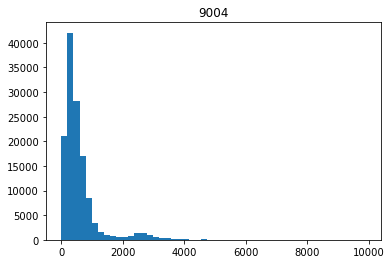

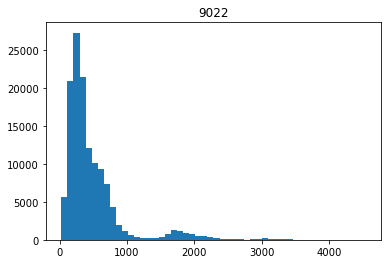

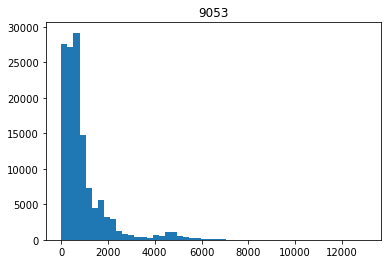

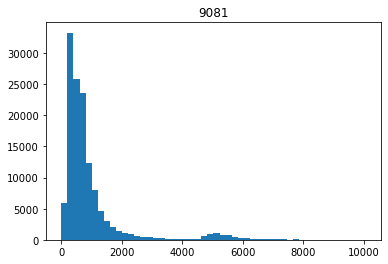

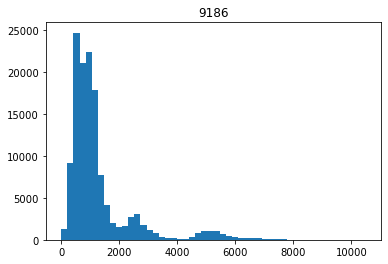

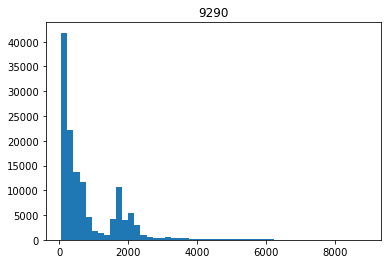

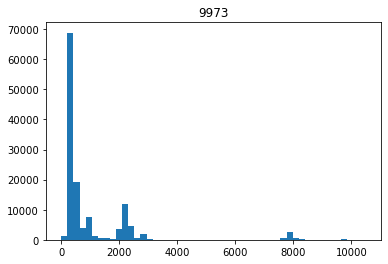

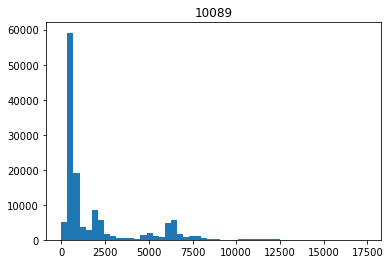

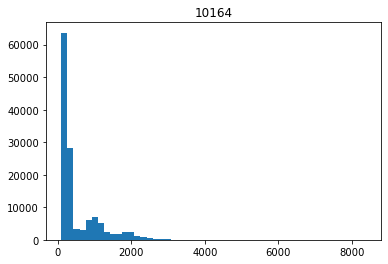

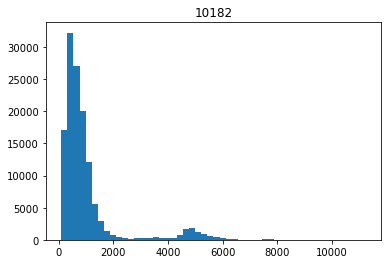

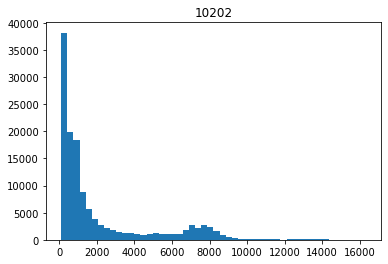

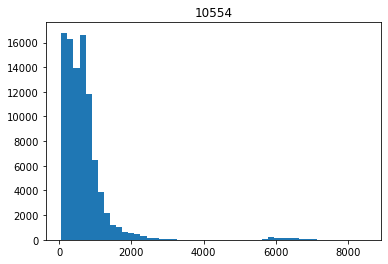

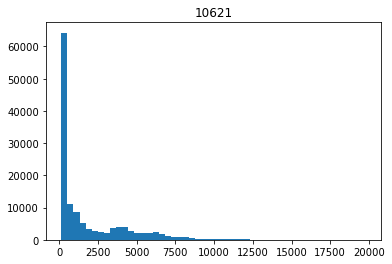

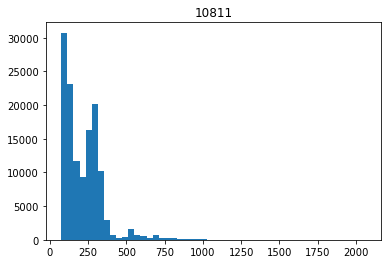

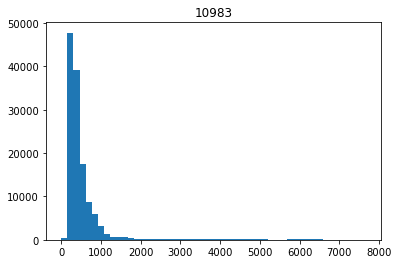

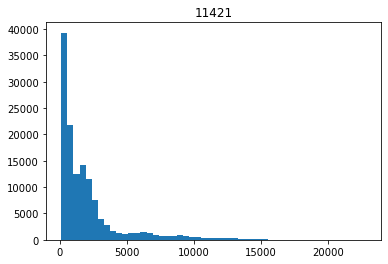

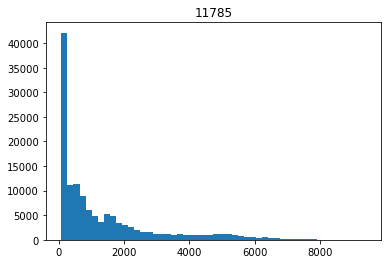

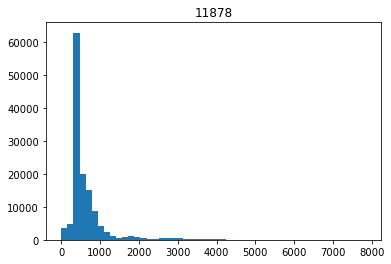

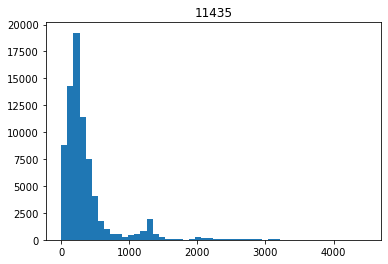

In [93]:
#aggregate distributions for each home
original_skew = []
for home in data_ids:
    plt.figure()
    plt.hist(grid.loc[grid.dataid == home].total_grid.values, bins = 50)
    plt.title(home)
    original_skew.append(skew(grid.loc[grid.dataid == home].total_grid.values))
    print("Home: ", home, "Skew: ", skew(grid.loc[grid.dataid == home].total_grid.values))

<ipython-input-94-5dcc4595f9b5>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


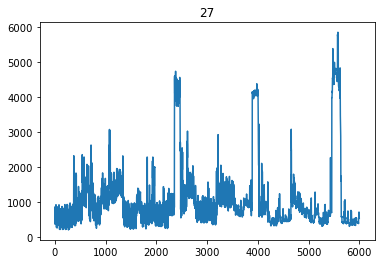

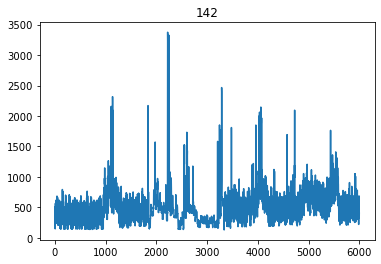

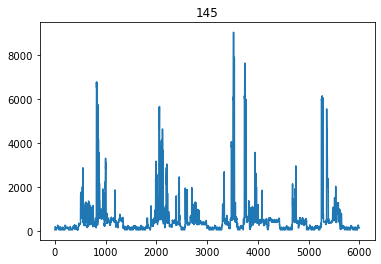

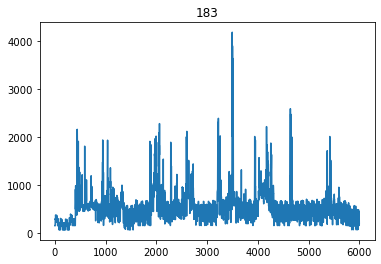

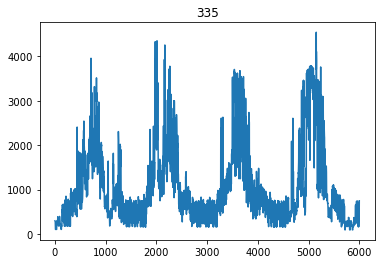

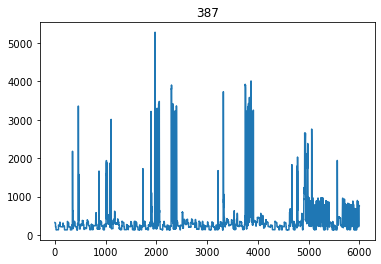

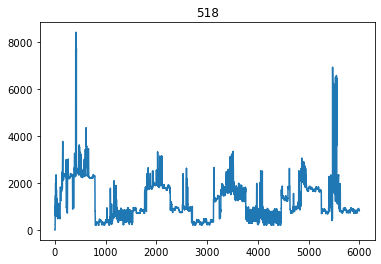

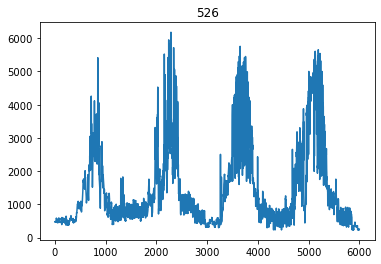

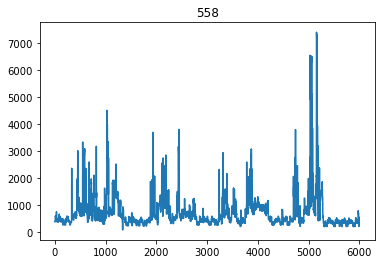

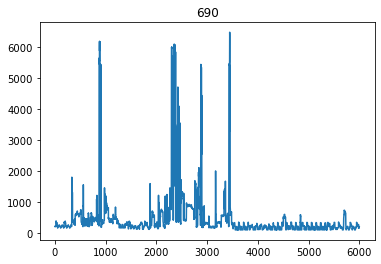

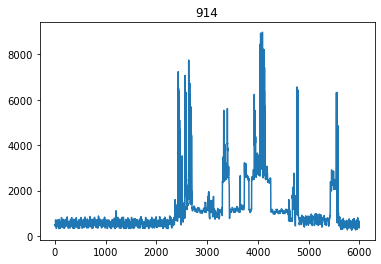

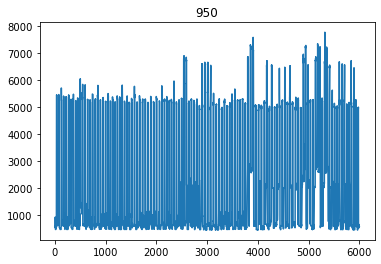

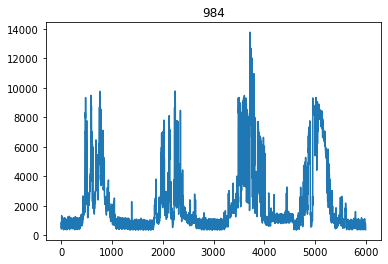

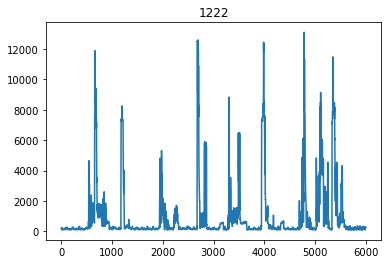

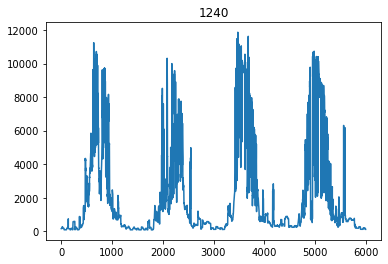

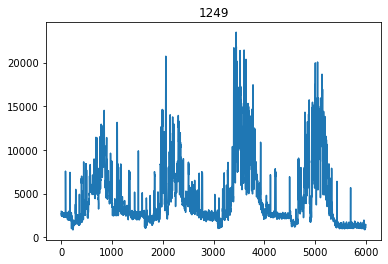

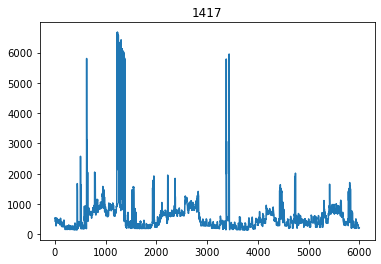

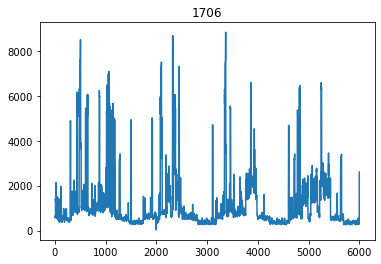

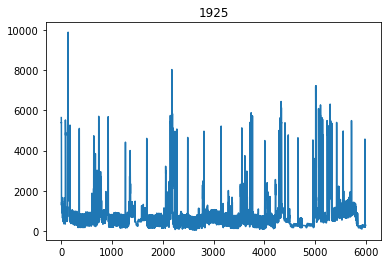

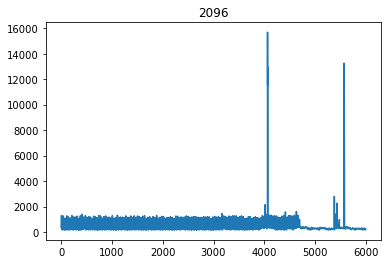

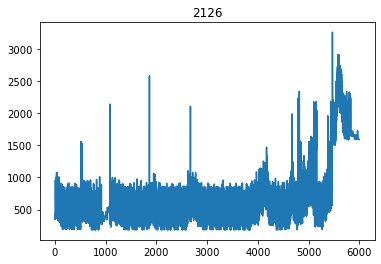

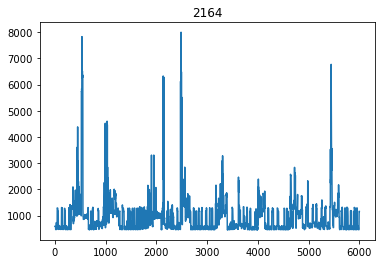

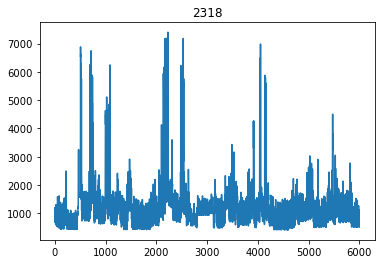

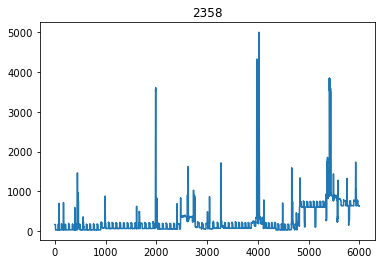

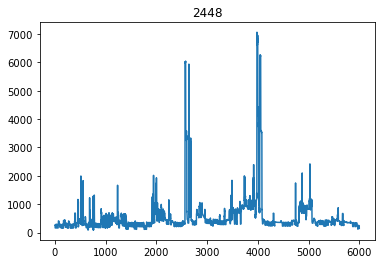

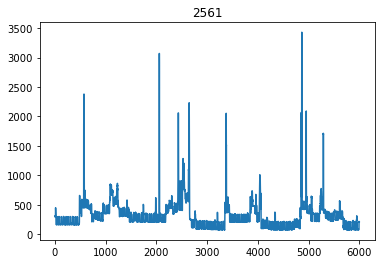

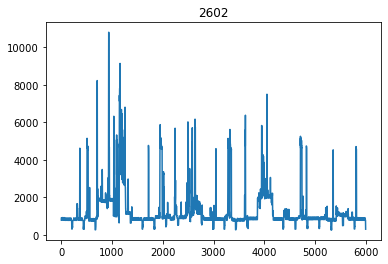

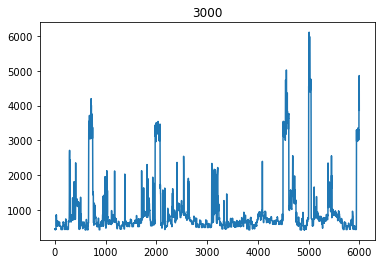

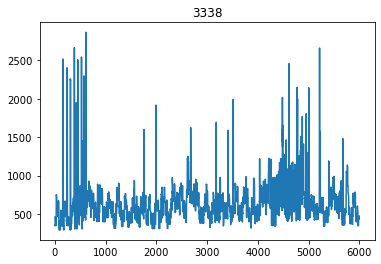

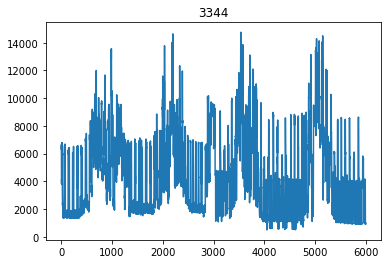

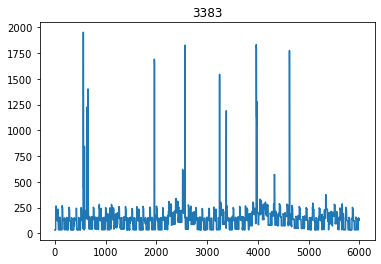

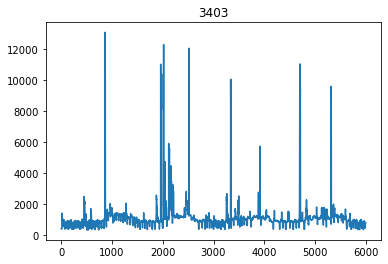

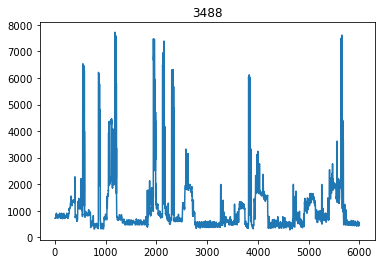

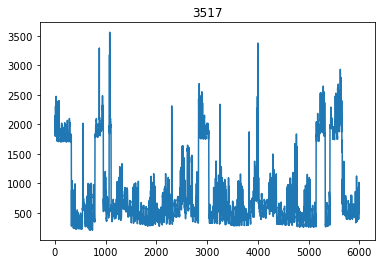

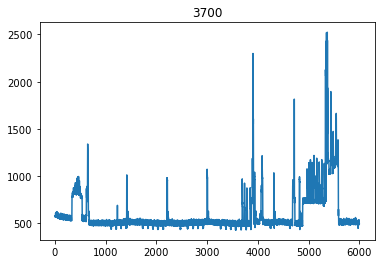

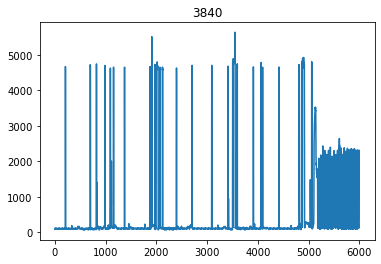

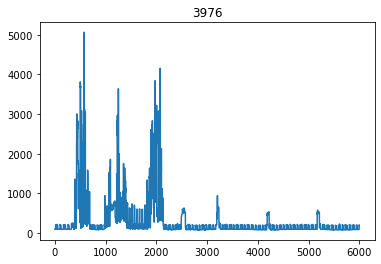

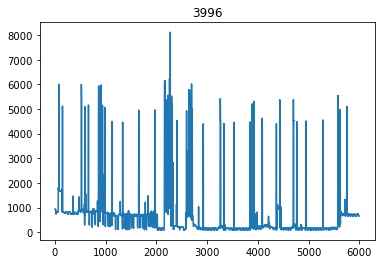

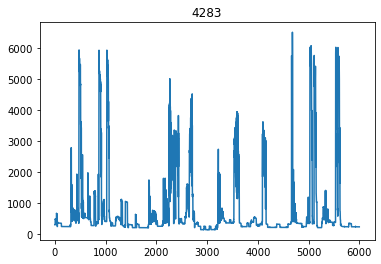

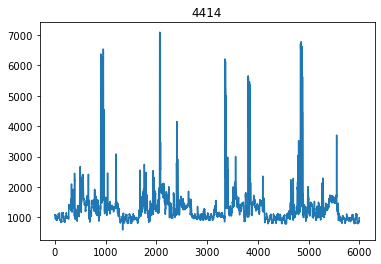

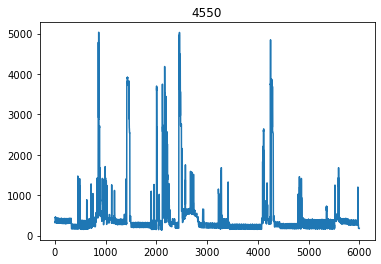

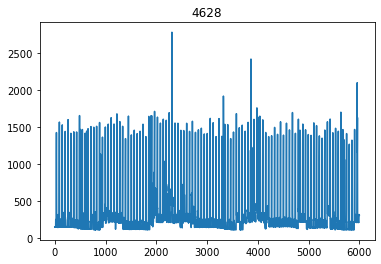

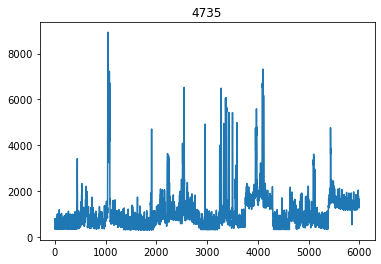

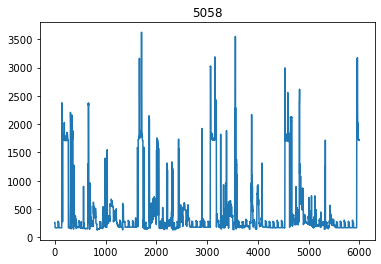

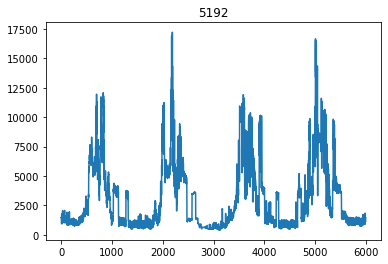

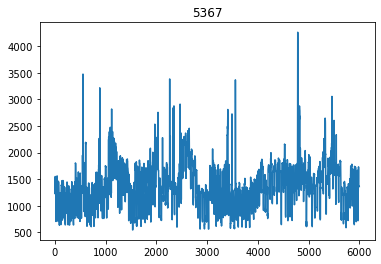

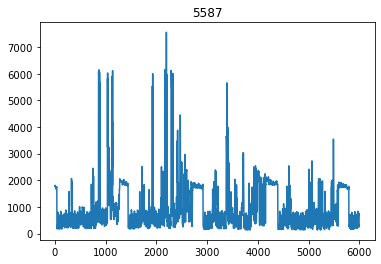

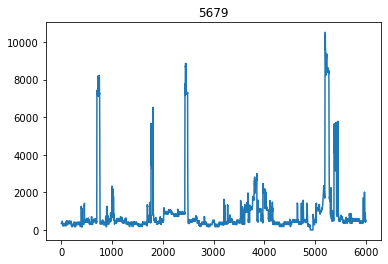

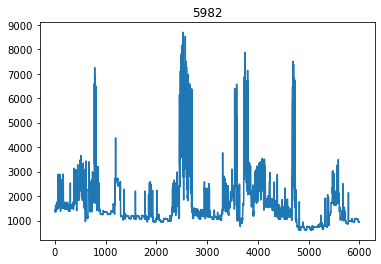

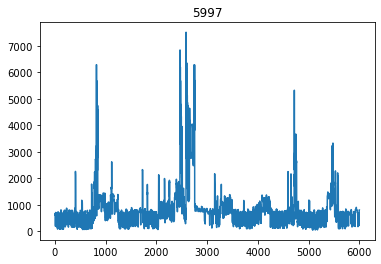

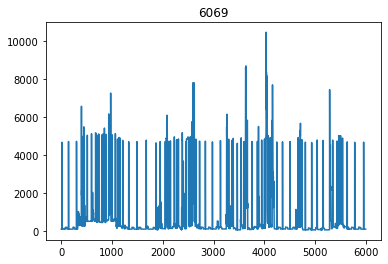

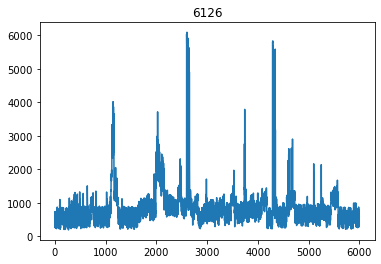

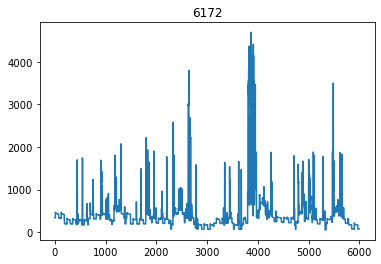

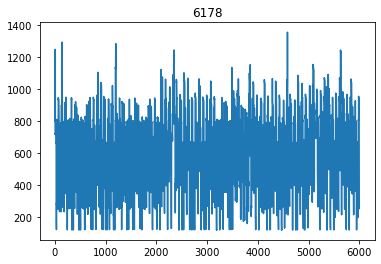

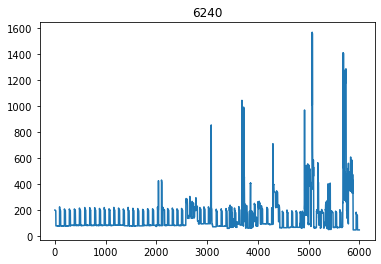

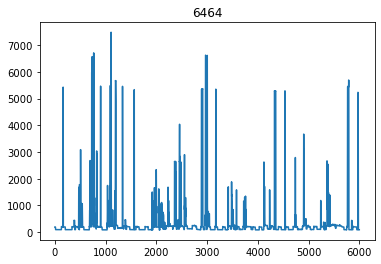

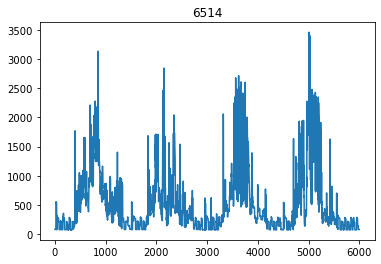

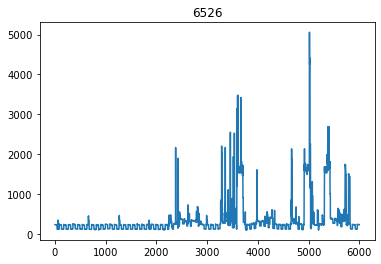

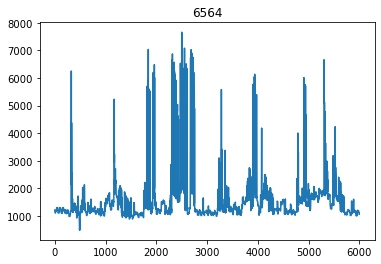

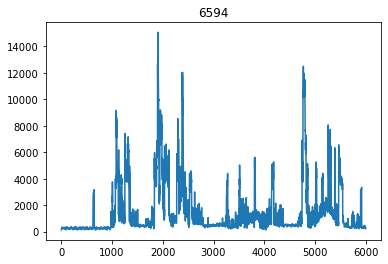

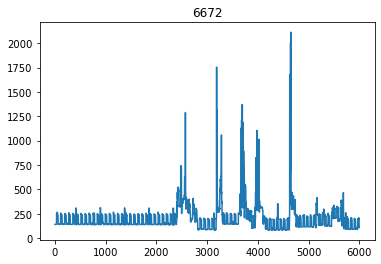

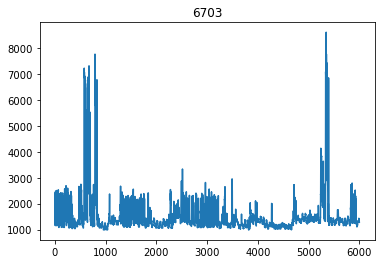

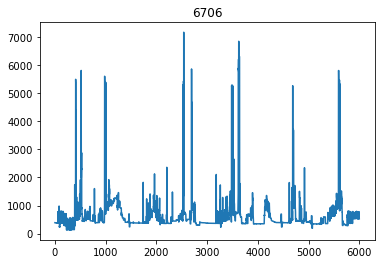

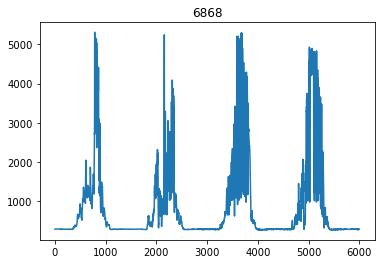

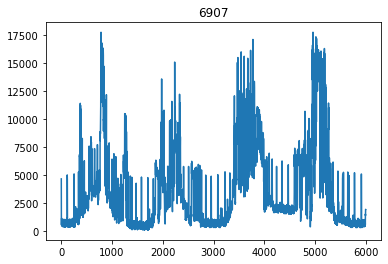

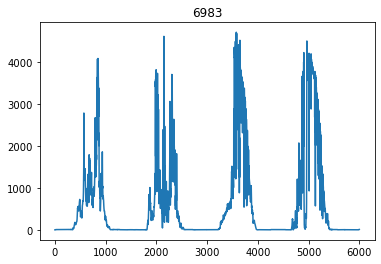

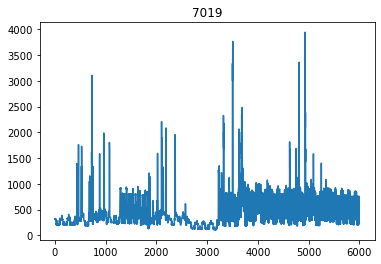

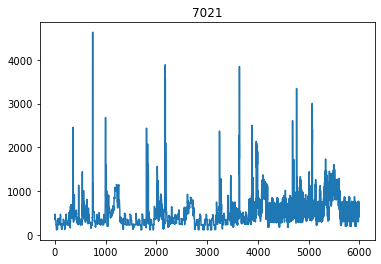

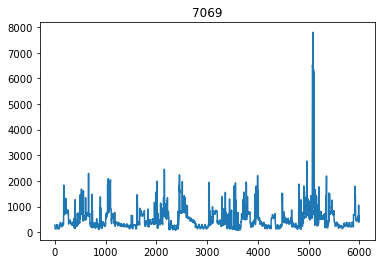

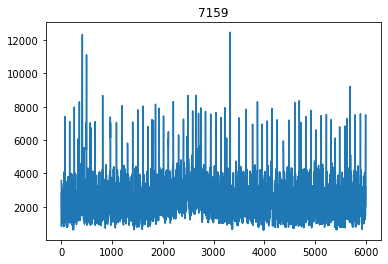

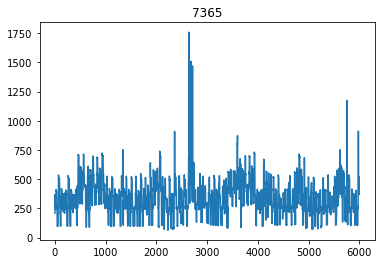

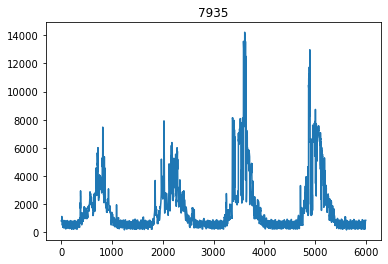

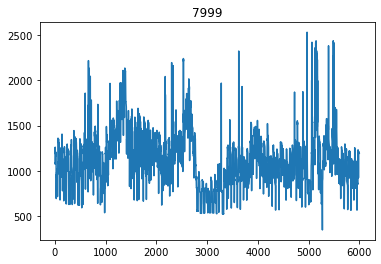

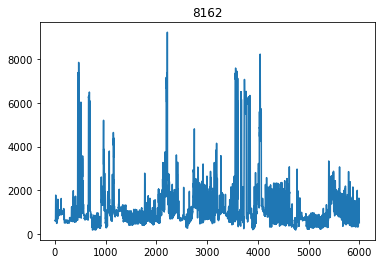

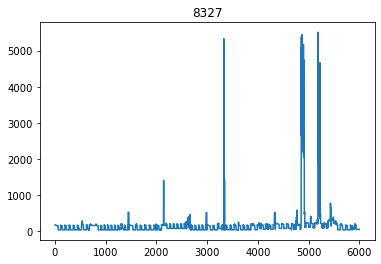

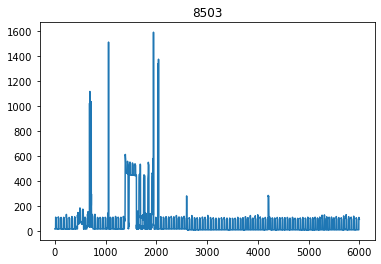

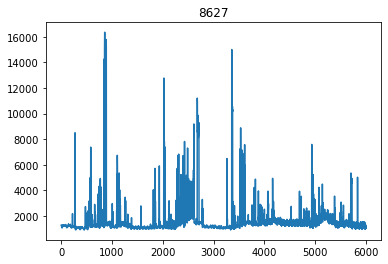

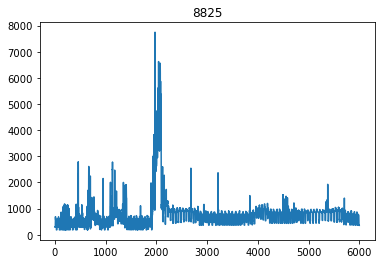

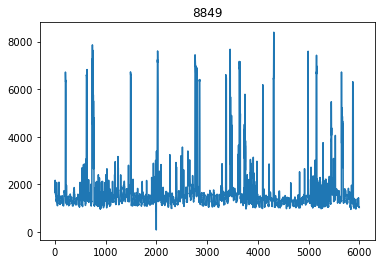

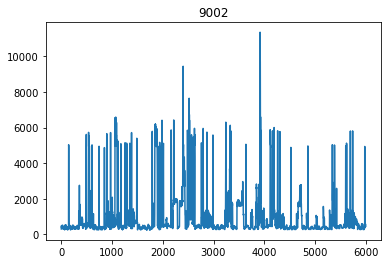

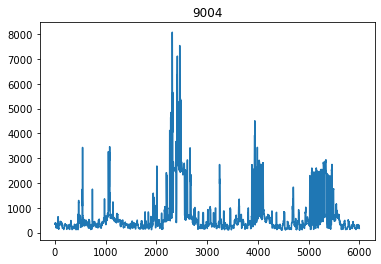

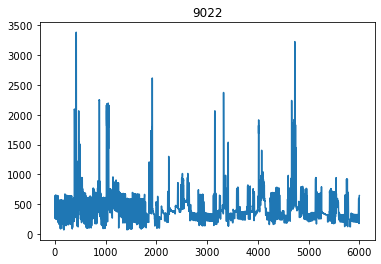

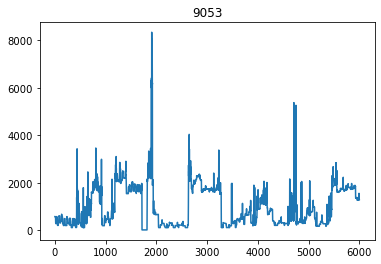

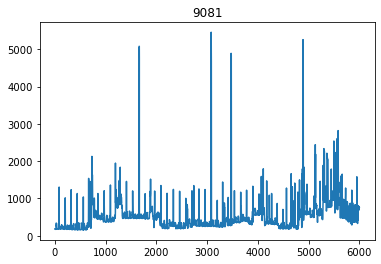

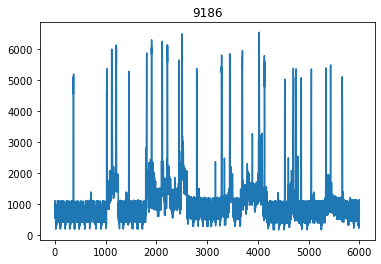

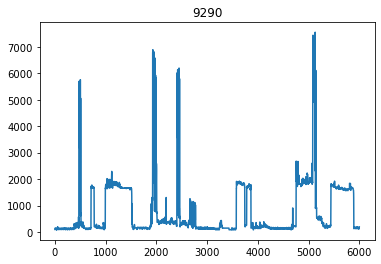

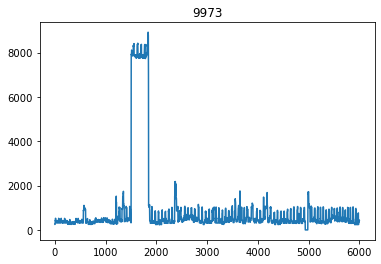

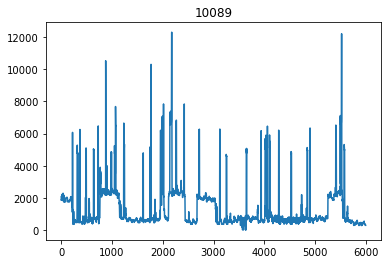

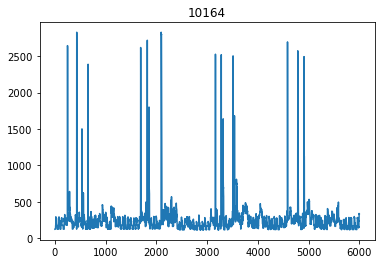

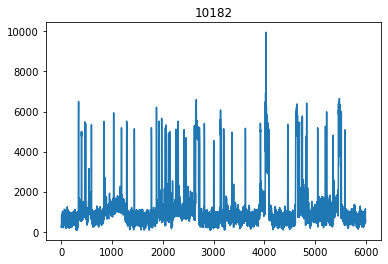

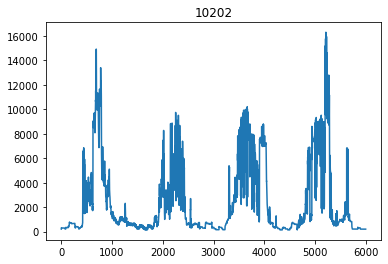

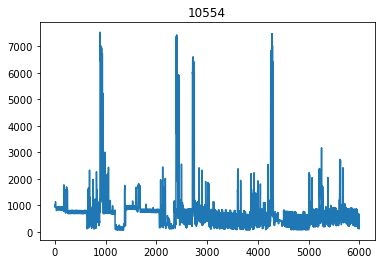

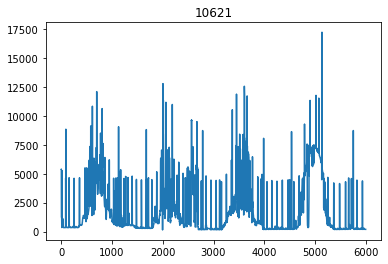

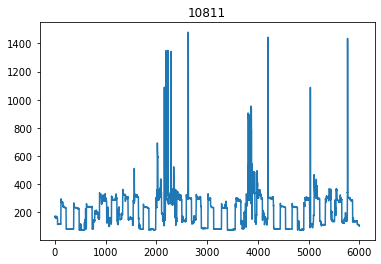

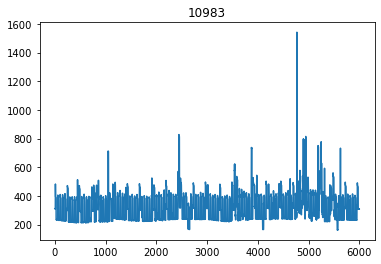

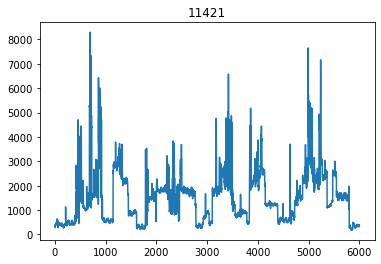

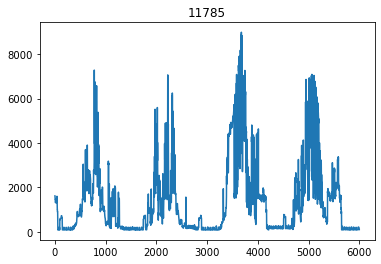

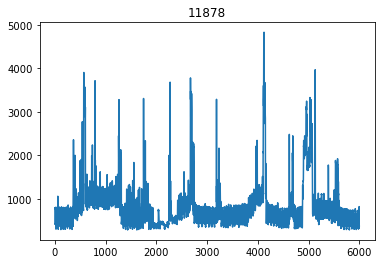

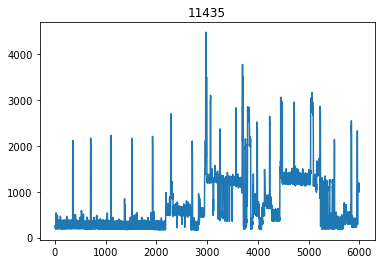

In [94]:
#aggregate time series for each home
for home in data_ids:
    plt.figure()
    plt.plot(grid.loc[grid.dataid == home].total_grid.values[0:6000])
    plt.title(home)

In [95]:
bins = [-1e50]
for i in range(10000+1000):
    if i % 2000 == 0:
        bins.append(i)

In [96]:
bins = bins + ([15000, 20000, 25000, 1e50])

In [97]:
bins

[-1e+50, 0, 2000, 4000, 6000, 8000, 10000, 15000, 20000, 25000, 1e+50]

In [98]:
bin_counts = []
labels = []
for home in data_ids:
    test_df = grid.loc[grid.dataid == home]
    test_df['binned'] = pd.cut(test_df['total_grid'], bins)
    labels.append(home)
    bin_counts.append(test_df.binned.values.value_counts().values)

<ipython-input-98-c9de27d9cb1c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['binned'] = pd.cut(test_df['total_grid'], bins)


In [99]:
labels = [str(i) for i in labels]

In [100]:
ranges = [str(i) for i in sorted(test_df.binned.value_counts().index)]

In [101]:
bin_counts = list(map(list, zip(*bin_counts)))

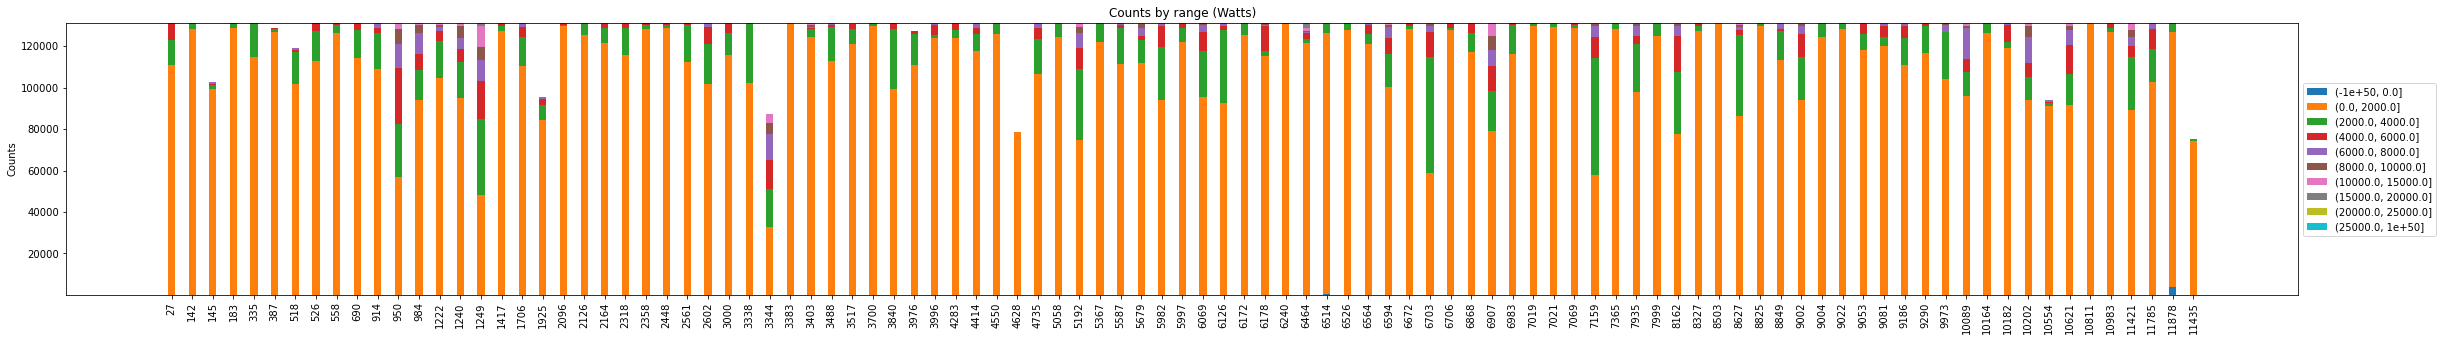

In [102]:
#comparing aggregate power histograms for each home
fig, ax = plt.subplots(figsize=(40,5))
width = 0.35
ax.bar(labels, bin_counts[0], width, label=ranges[0])
bottom = np.zeros(len(labels)).astype('int64')
for i in range(len(bin_counts)-1):
    bottom = np.add(bottom, bin_counts[i])
    ax.bar(labels, bin_counts[i+1], width, bottom=bottom, label=ranges[i+1])
ax.set_ylabel('Counts')
ax.set_title('Counts by range (Watts)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.show()

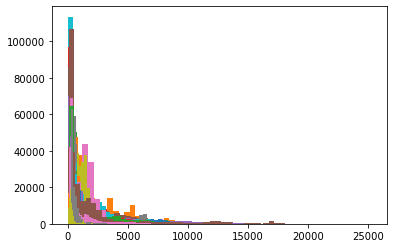

In [103]:
#overlapping aggregate power histograms
for home in data_ids:
    plt.hist(grid.loc[grid.dataid==home].total_grid.values, bins = 50)

Home:  27 Skew:  0.22931418194015044
Home:  142 Skew:  0.01846465658548209
Home:  145 Skew:  0.45146038606301
Home:  183 Skew:  0.596439660222451
Home:  335 Skew:  0.03125931520101812
Home:  387 Skew:  1.0986631935080193
Home:  518 Skew:  -0.07217641865110654
Home:  526 Skew:  0.48120846226025865
Home:  558 Skew:  0.7370473238653127
Home:  690 Skew:  0.19169216625690974
Home:  914 Skew:  0.5426045885513487
Home:  950 Skew:  -0.19207937337056918
Home:  984 Skew:  0.7310175534844195
Home:  1222 Skew:  0.7839991155332697
Home:  1240 Skew:  0.1598782948052158
Home:  1249 Skew:  0.36590384226900224
Home:  1417 Skew:  0.7803707418990936
Home:  1706 Skew:  0.4624176260127948
Home:  1925 Skew:  -0.1391161741321674
Home:  2096 Skew:  3.144366503484906
Home:  2126 Skew:  -0.013292799105497907


<ipython-input-104-74fe98f13c40>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Home:  2164 Skew:  -1.8604869809359172
Home:  2318 Skew:  0.3803505618661135
Home:  2358 Skew:  0.8757649548106972
Home:  2448 Skew:  0.9882128757588431
Home:  2561 Skew:  0.17618573926504424
Home:  2602 Skew:  0.3790883674048832
Home:  3000 Skew:  1.0918352365962636
Home:  3338 Skew:  0.6910685626222219
Home:  3344 Skew:  -0.8584985498051175
Home:  3383 Skew:  0.277902847919608
Home:  3403 Skew:  0.7533079205956716
Home:  3488 Skew:  -0.12529720343690684
Home:  3517 Skew:  0.6812517470951186
Home:  3700 Skew:  1.2501953697294192
Home:  3840 Skew:  0.14955082268881748
Home:  3976 Skew:  -0.26716129990633325
Home:  3996 Skew:  0.4410312317580621
Home:  4283 Skew:  0.20328444068927942
Home:  4414 Skew:  0.9173921880440655
Home:  4550 Skew:  1.0270738342379366
Home:  4628 Skew:  0.04701792332751185
Home:  4735 Skew:  -1.405395092716968
Home:  5058 Skew:  0.8222842516493178
Home:  5192 Skew:  0.051811299160973885
Home:  5367 Skew:  -0.91824685778476
Home:  5587 Skew:  0.03567255537364233
H

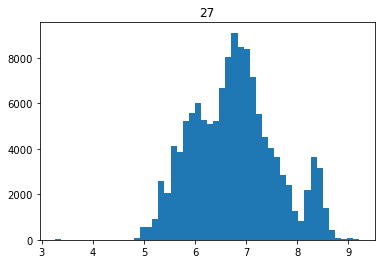

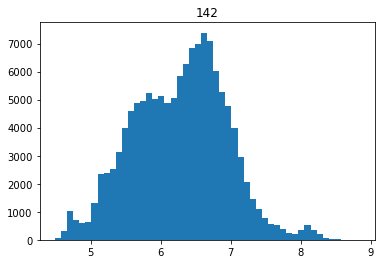

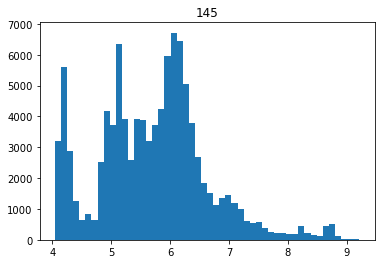

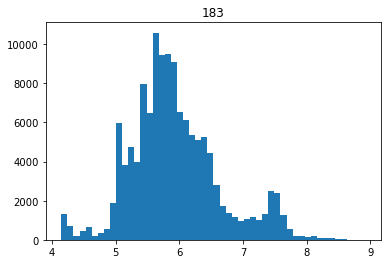

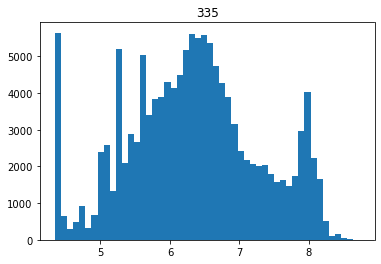

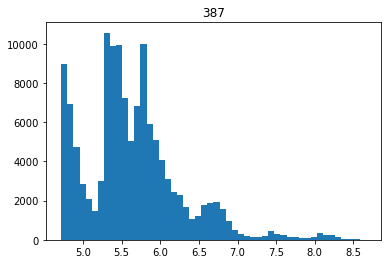

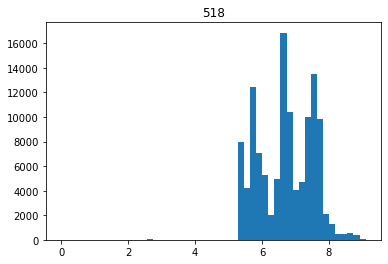

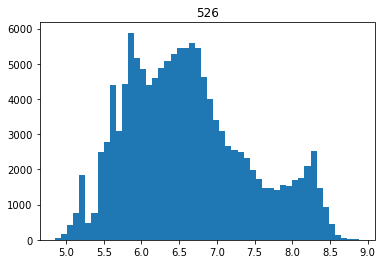

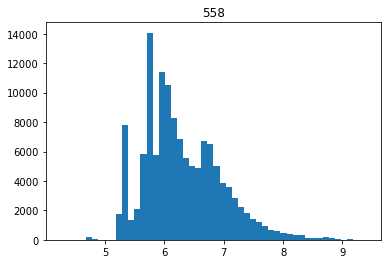

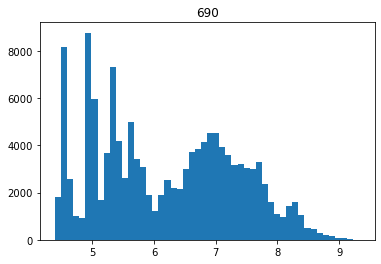

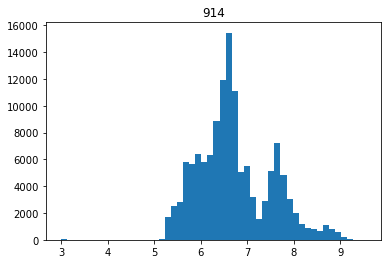

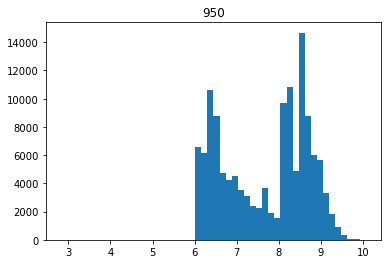

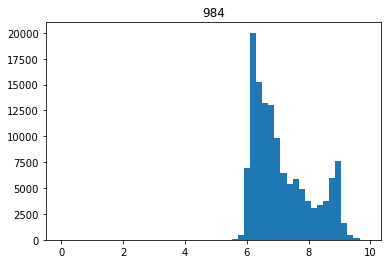

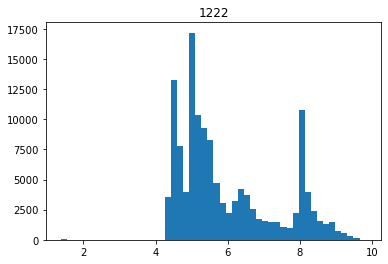

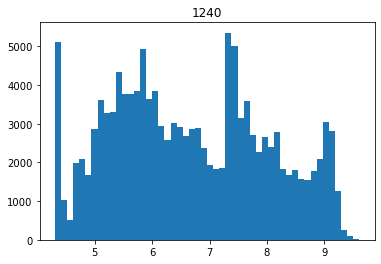

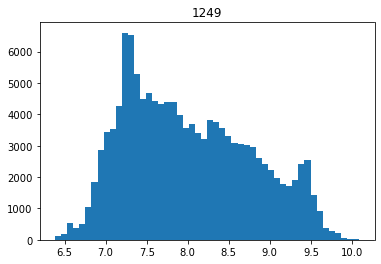

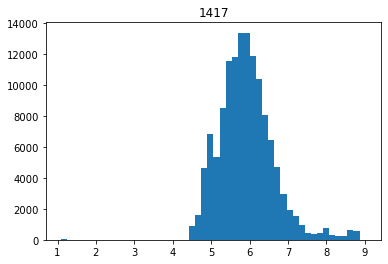

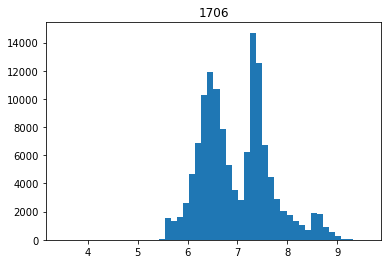

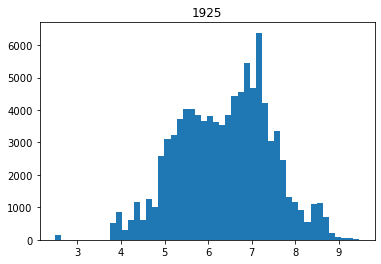

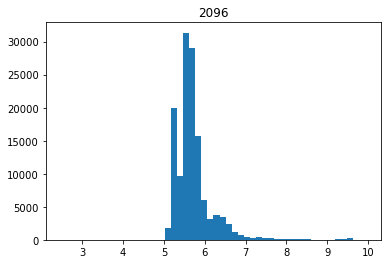

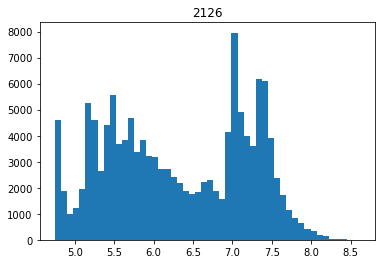

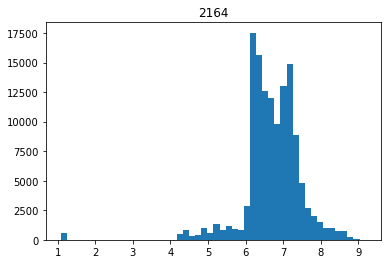

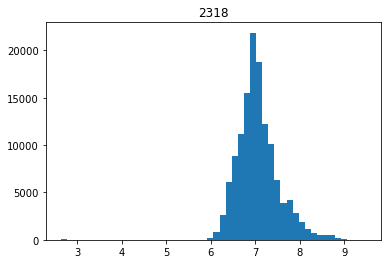

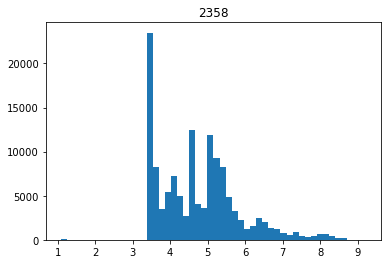

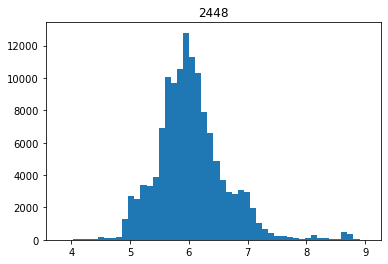

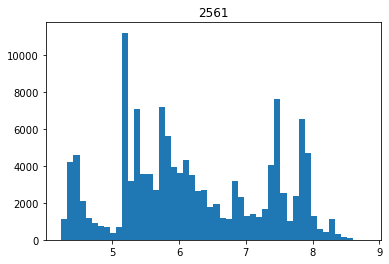

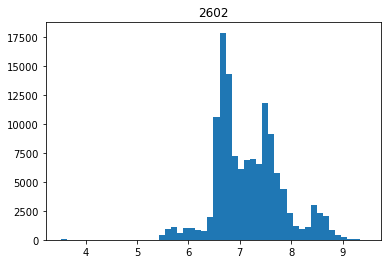

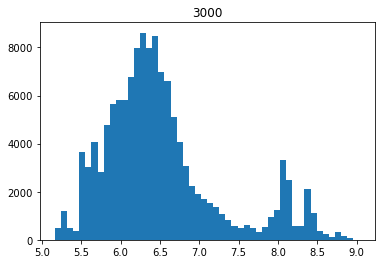

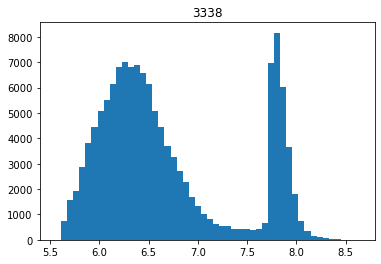

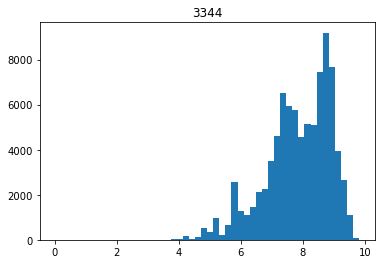

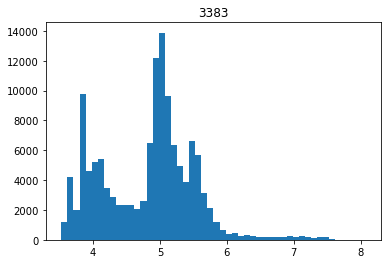

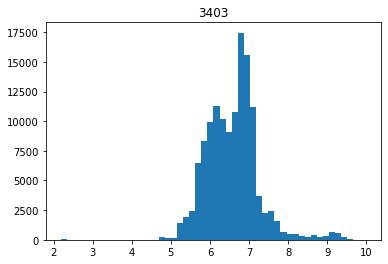

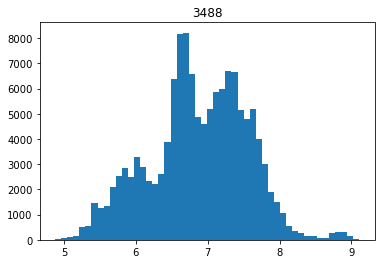

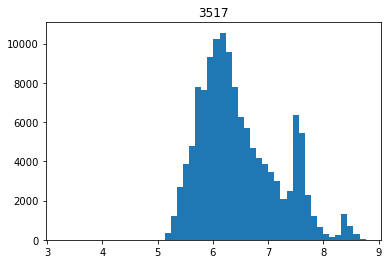

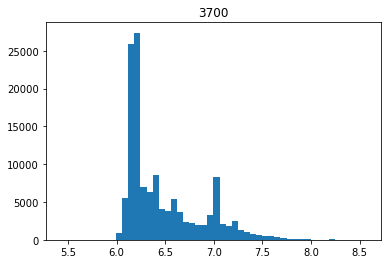

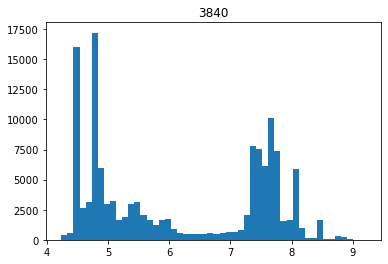

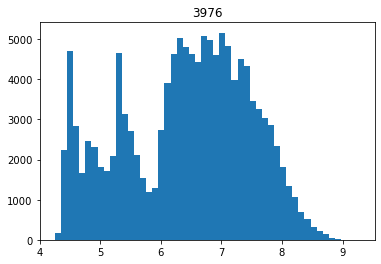

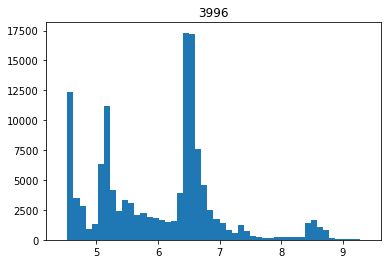

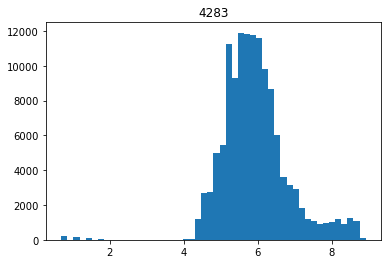

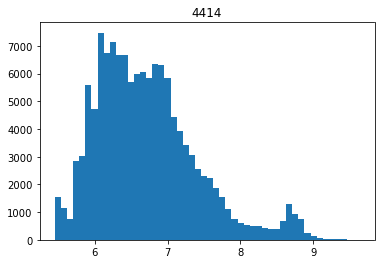

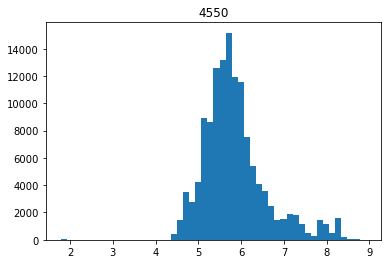

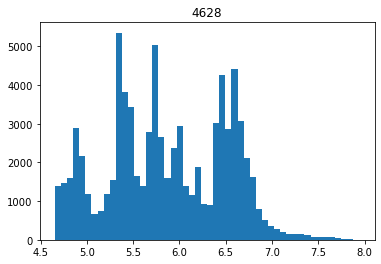

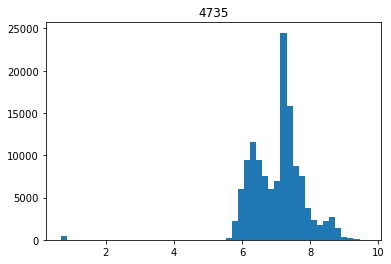

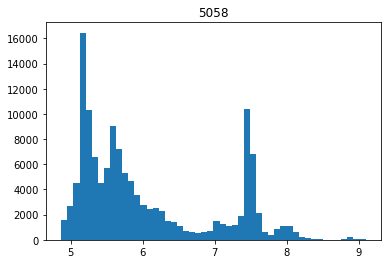

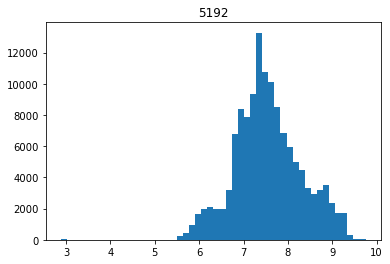

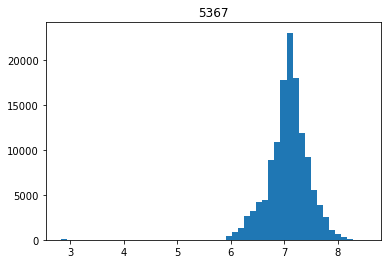

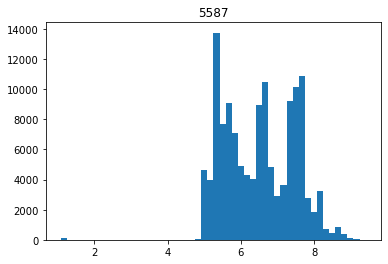

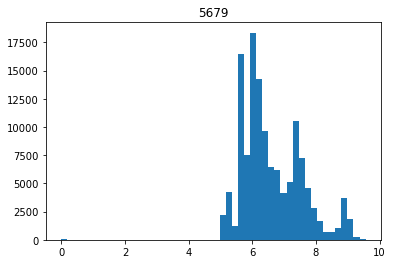

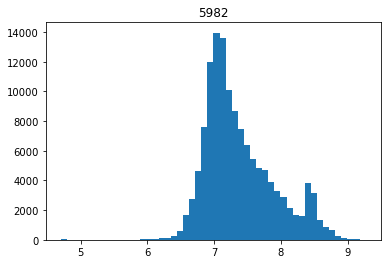

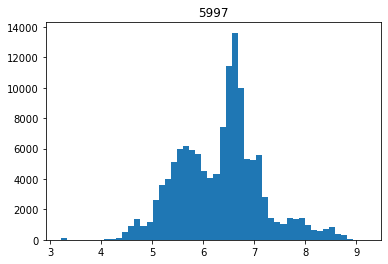

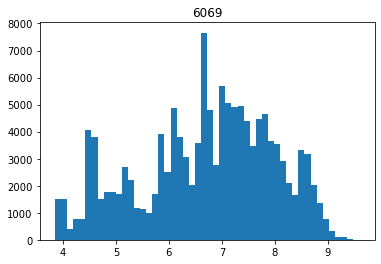

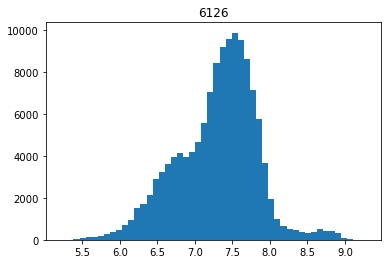

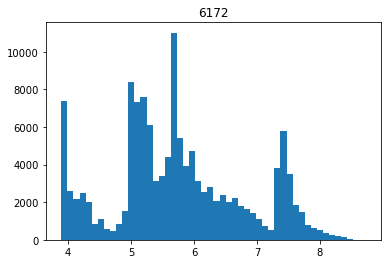

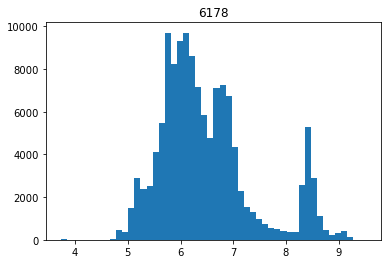

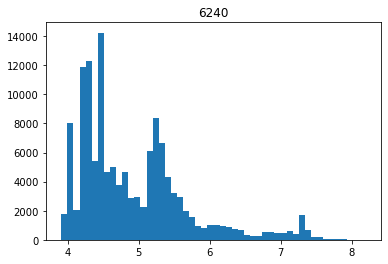

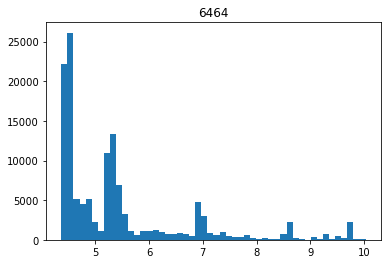

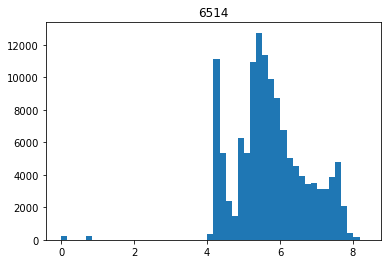

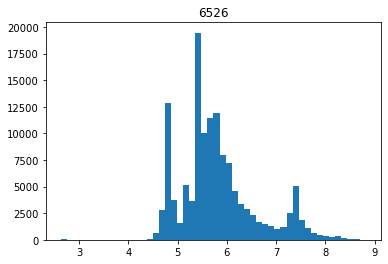

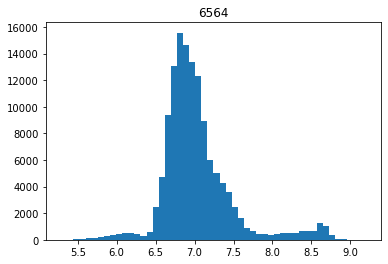

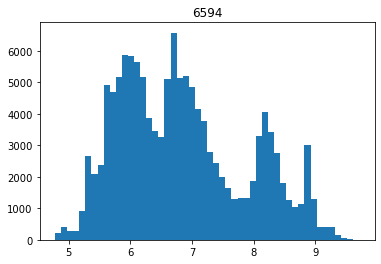

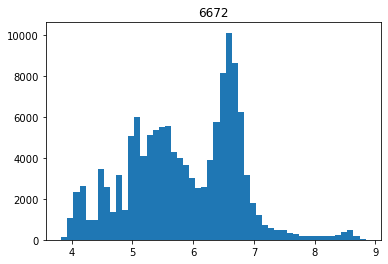

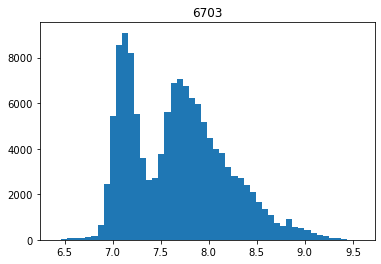

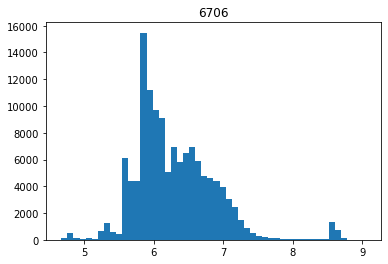

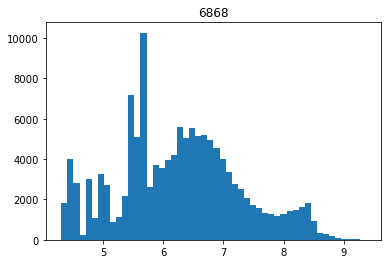

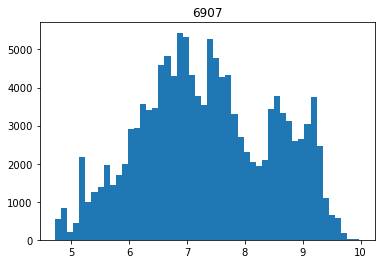

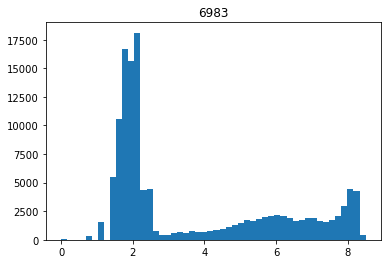

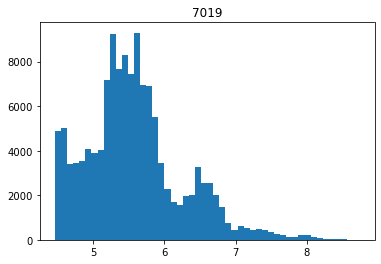

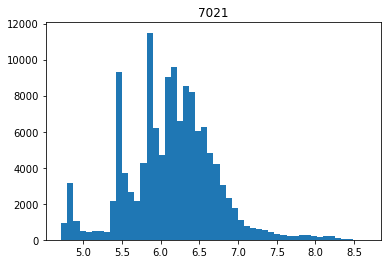

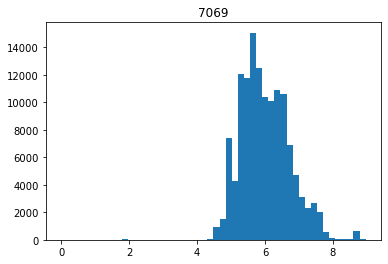

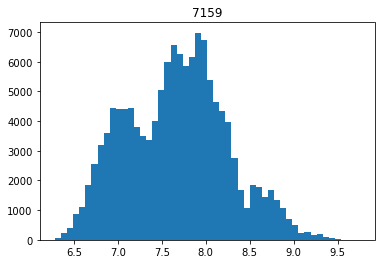

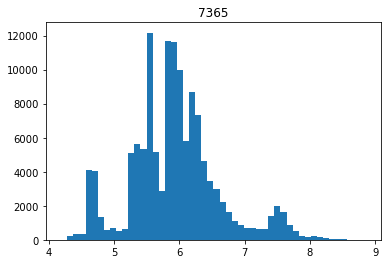

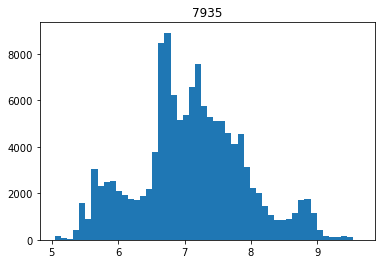

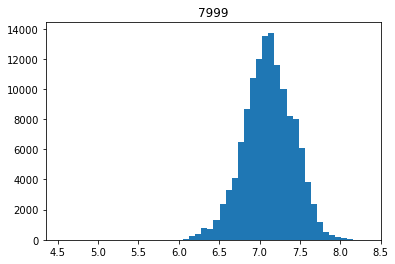

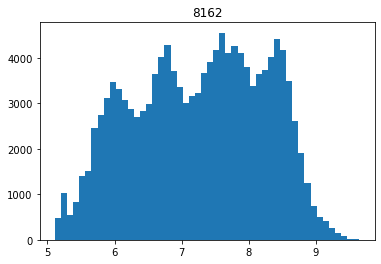

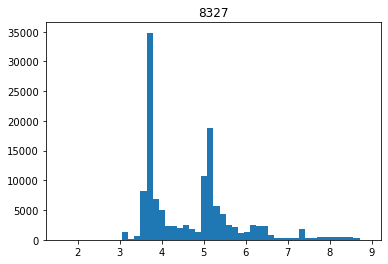

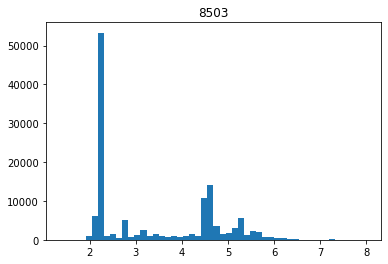

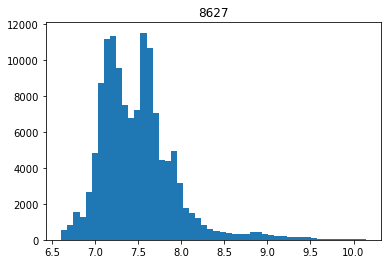

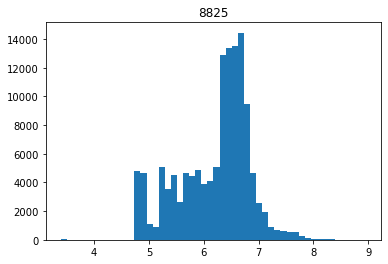

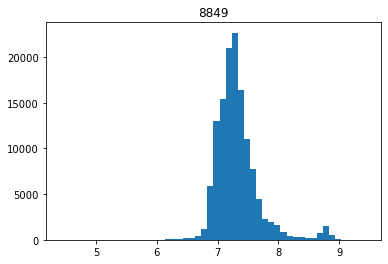

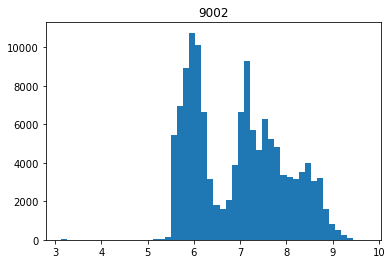

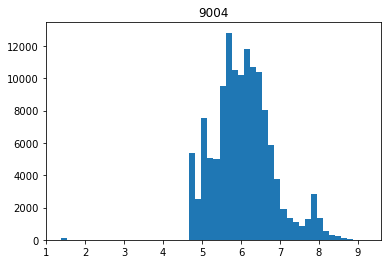

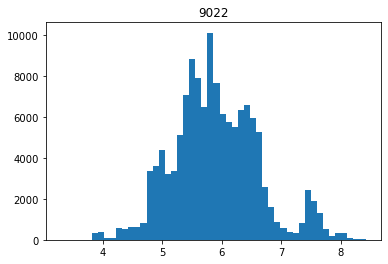

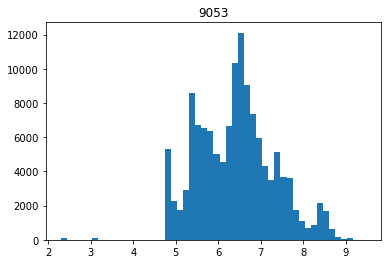

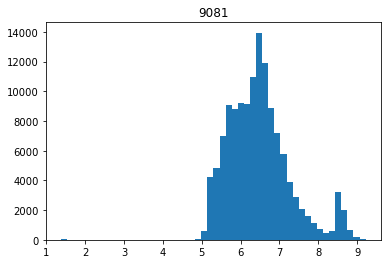

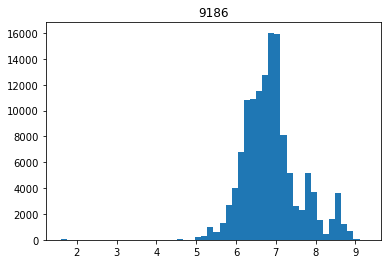

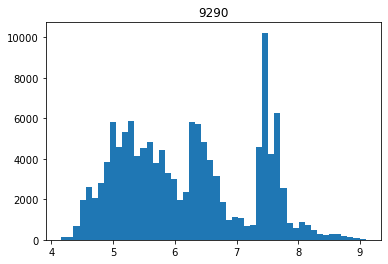

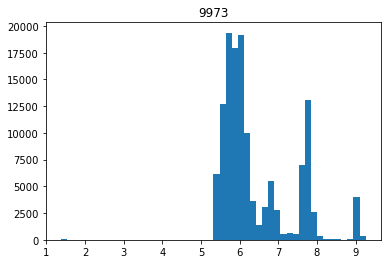

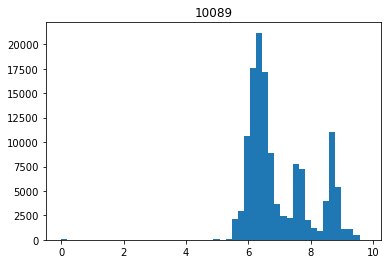

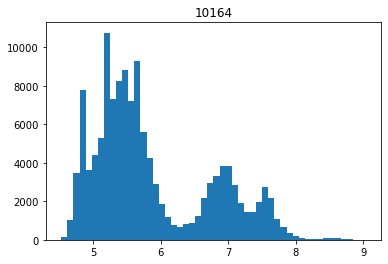

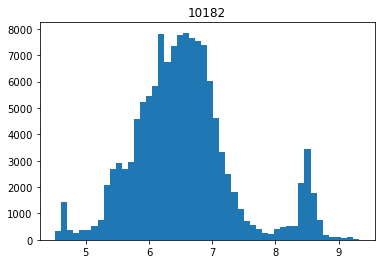

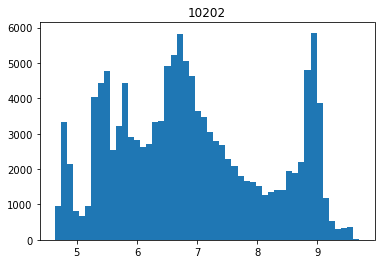

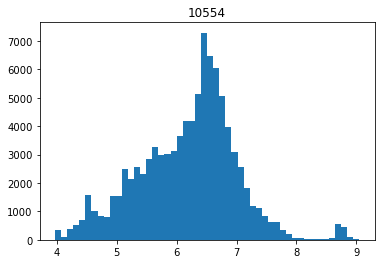

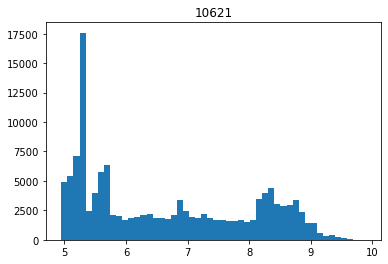

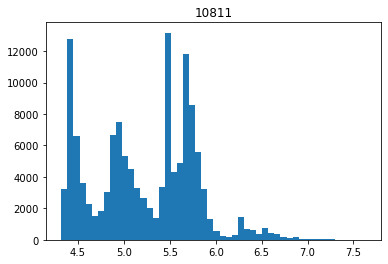

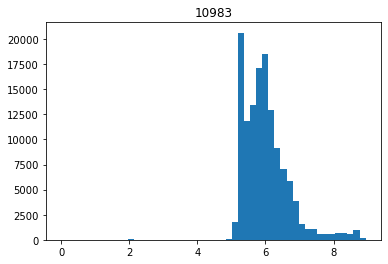

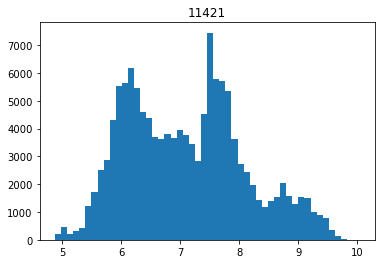

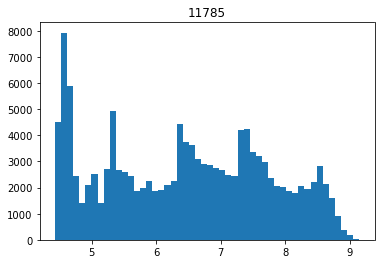

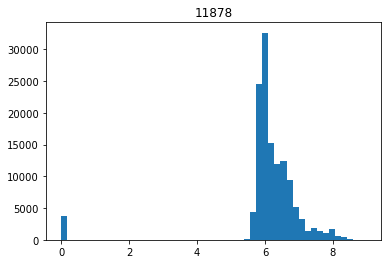

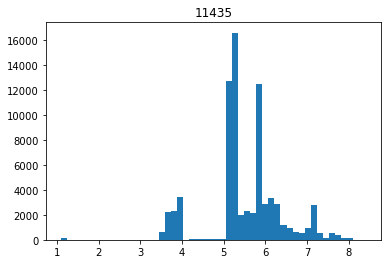

In [104]:
#Fixing skewness: log for each home
skew_after_log = []
for home in data_ids:
    plt.figure()
    plt.hist(np.log(grid.loc[grid.dataid == home].total_grid.values + 1), bins = 50)
    plt.title(home)
    skew_after_log.append(skew(np.log(grid.loc[grid.dataid == home].total_grid.values + 1)))
    print("Home: ", home, "Skew: ", skew(np.log(grid.loc[grid.dataid == home].total_grid.values + 1)))

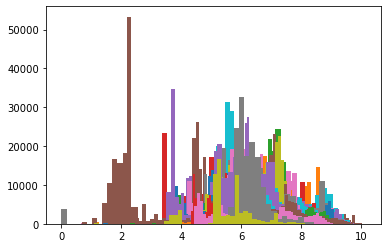

In [105]:
#Fixing skewness: log overlapping histograms
for home in data_ids:
    plt.hist(np.log(grid.loc[grid.dataid==home].total_grid.values + 1), bins=50)

Home:  27 Skew:  0.01110470233654188 Mean:  4.752395843431514
Home:  142 Skew:  0.0003059752046008797 Mean:  6.086547126381241
Home:  145 Skew:  0.0028164245349269167 Mean:  3.796039490718441
Home:  183 Skew:  -0.025353825750047475 Mean:  3.1018983978477
Home:  335 Skew:  0.0023115317813079232 Mean:  6.05009145782465
Home:  387 Skew:  0.03167034562712129 Mean:  1.822294161357564
Home:  518 Skew:  -0.007240991801735942 Mean:  7.719533795192688
Home:  526 Skew:  0.050912943598041153 Mean:  3.0629920280016427
Home:  558 Skew:  0.03917318359331145 Mean:  2.2498172243896297
Home:  690 Skew:  0.046210336261075104 Mean:  4.545464112210027
Home:  914 Skew:  -0.00432069765440608 Mean:  3.261391143805878
Home:  950 Skew:  -0.07045918259665367 Mean:  14.442266714315087
Home:  984 Skew:  -0.3758100771518694 Mean:  3.1826778810582126
Home:  1222 Skew:  0.1238999817126805 Mean:  2.462985459099576
Home:  1240 Skew:  0.030900857547655185 Mean:  5.351984859082955
Home:  1249 Skew:  0.0645731388426041 M

<ipython-input-106-699d07217bb7>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Home:  2126 Skew:  -0.0039499429201197145 Mean:  6.525141470327644
Home:  2164 Skew:  0.17730027381162192 Mean:  18.48804627028017
Home:  2318 Skew:  -0.09857182222241259 Mean:  5.345014048108365
Home:  2358 Skew:  0.0767096705920749 Mean:  2.4379515386326274
Home:  2448 Skew:  -0.06076484213405408 Mean:  2.4396768629584464
Home:  2561 Skew:  0.036084843781172535 Mean:  4.6897360359609905
Home:  2602 Skew:  -0.027424101681435928 Mean:  4.191973071500736
Home:  3000 Skew:  0.0625239495096725 Mean:  1.7049515677956122
Home:  3338 Skew:  0.17837895172619728 Mean:  1.5302178616138444
Home:  3344 Skew:  -0.09393652735427212 Mean:  39.32163281582377
Home:  3383 Skew:  0.002900589268488801 Mean:  3.5983382415683005
Home:  3403 Skew:  -0.14563208714800122 Mean:  3.9142419957140206
Home:  3488 Skew:  -0.0017410420245229236 Mean:  8.704822945283855
Home:  3517 Skew:  0.0582142095624645 Mean:  2.1717181947299555
Home:  3700 Skew:  0.3444355196716823 Mean:  0.5323705602329981
Home:  3840 Skew:  0.

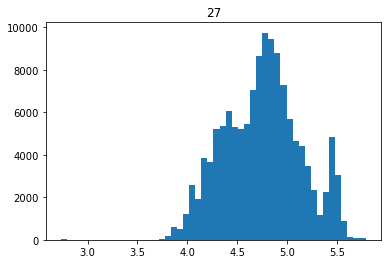

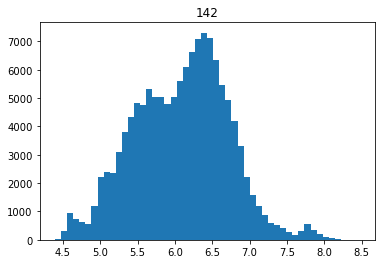

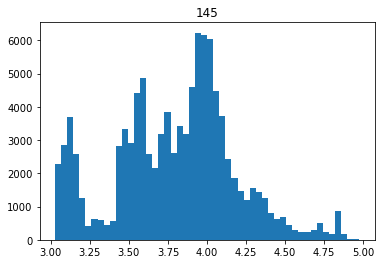

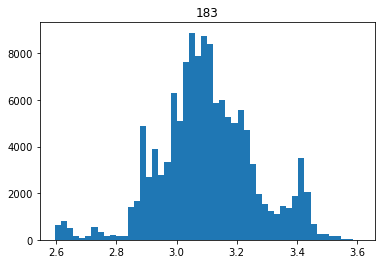

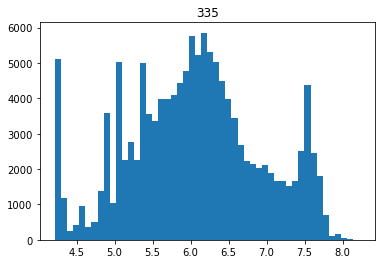

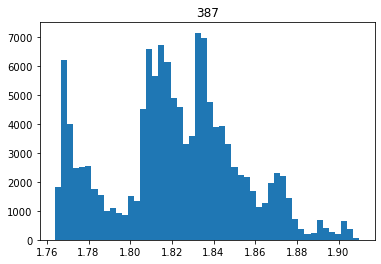

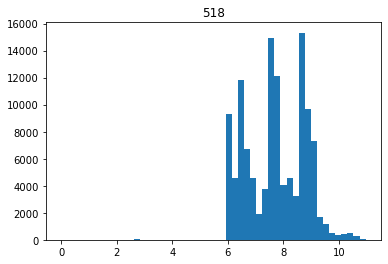

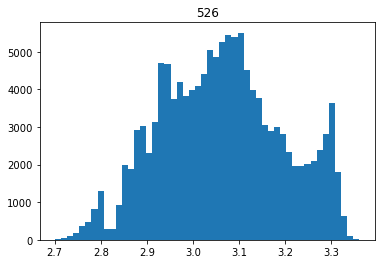

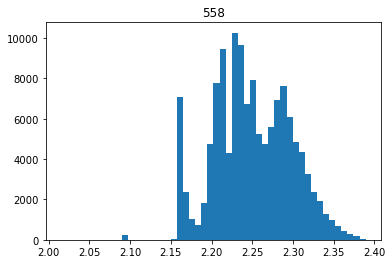

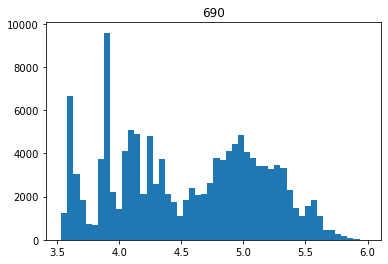

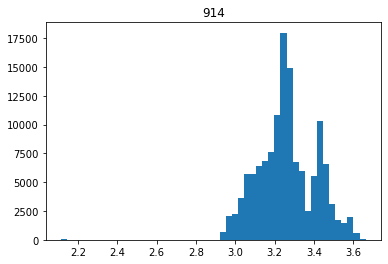

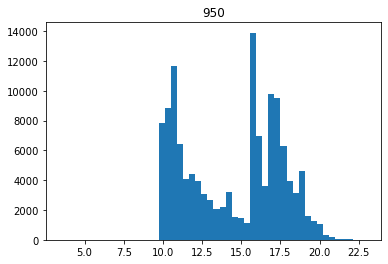

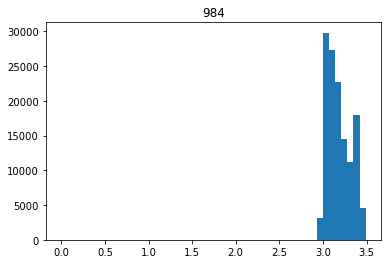

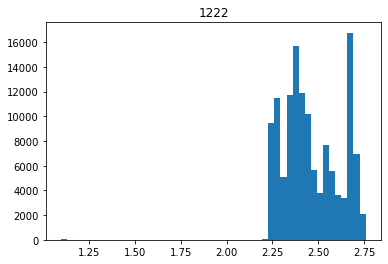

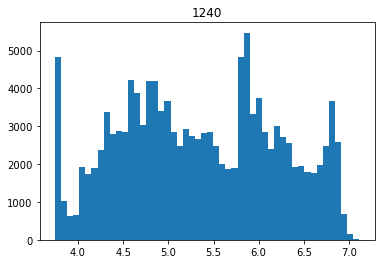

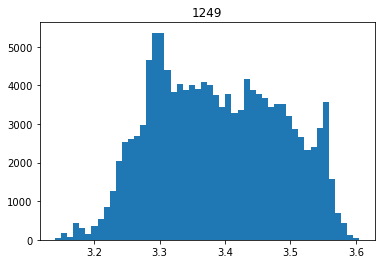

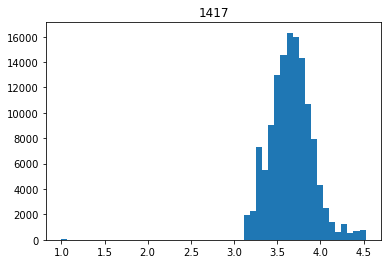

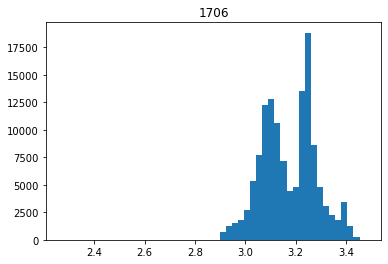

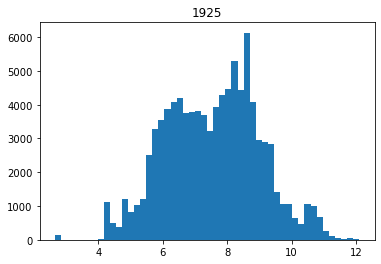

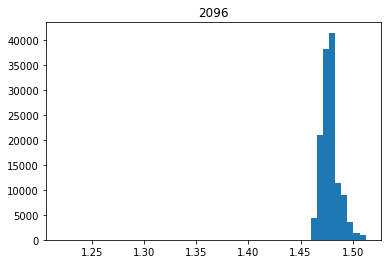

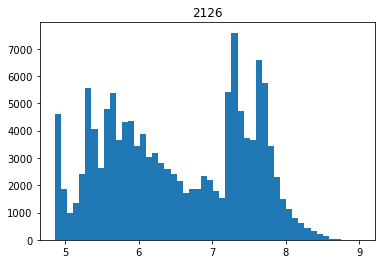

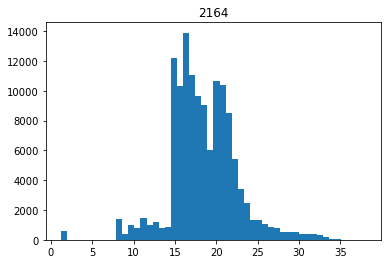

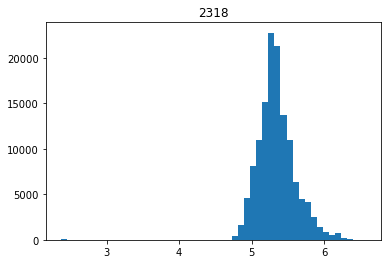

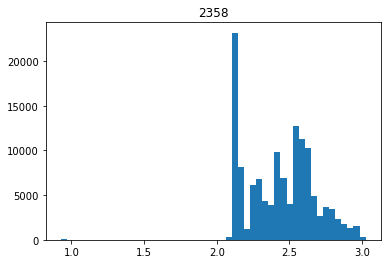

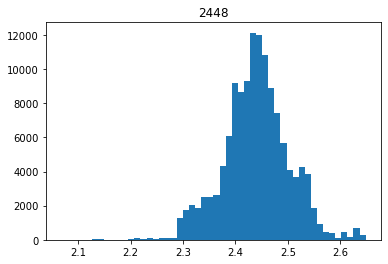

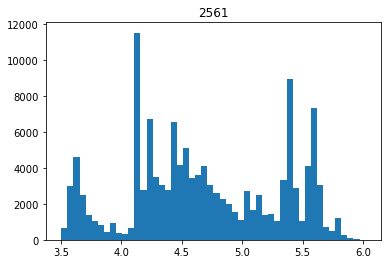

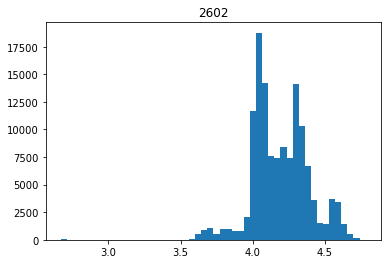

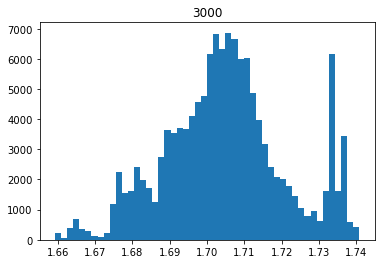

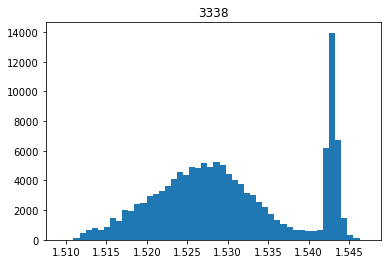

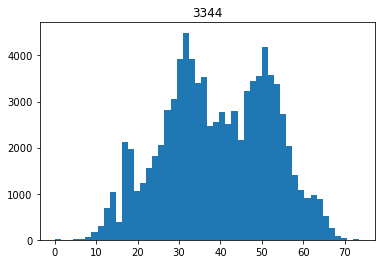

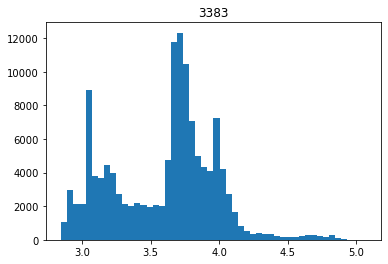

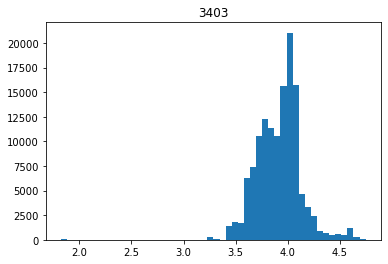

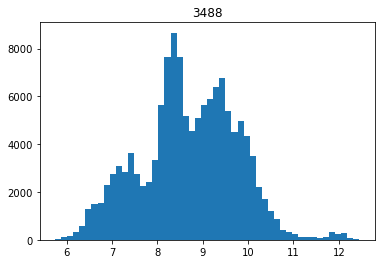

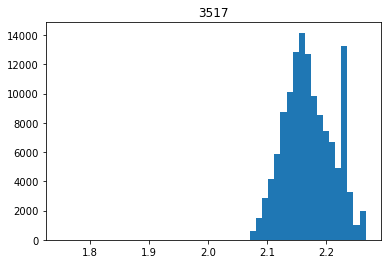

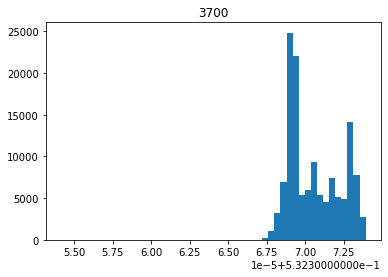

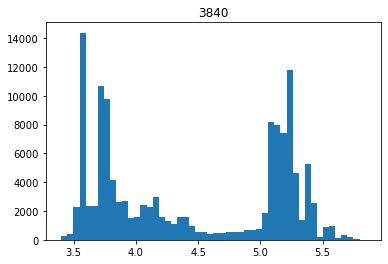

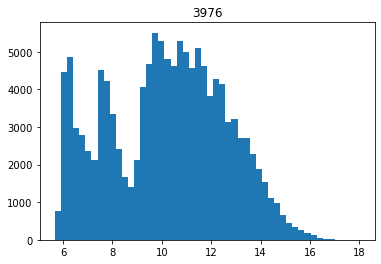

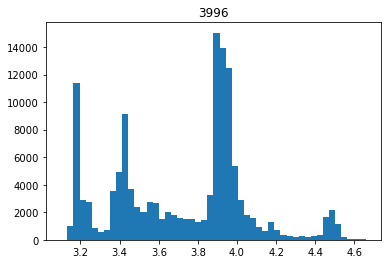

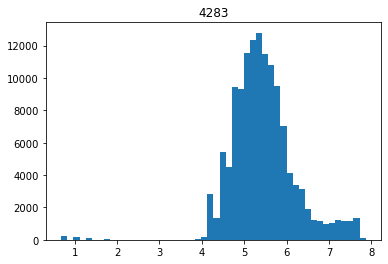

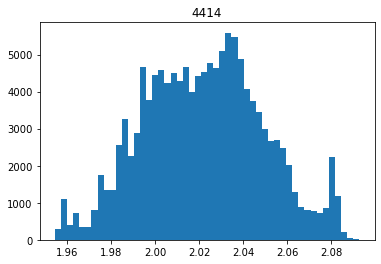

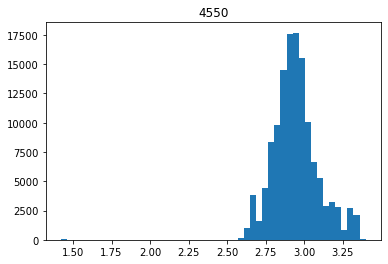

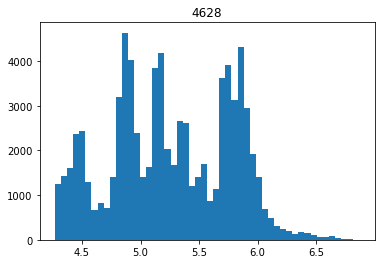

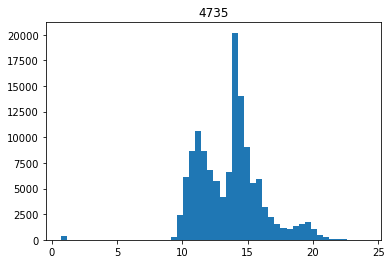

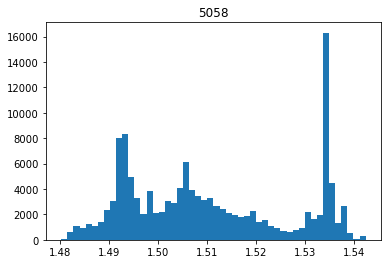

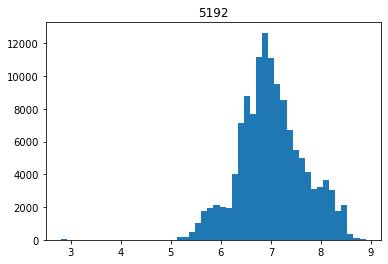

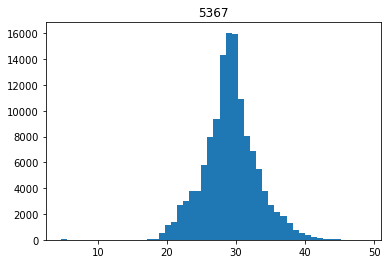

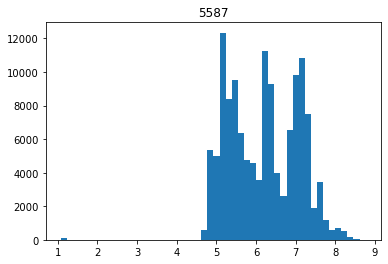

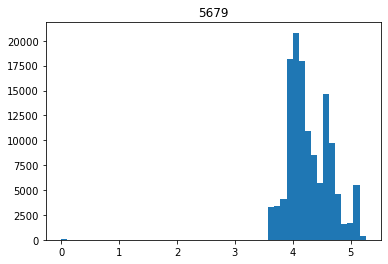

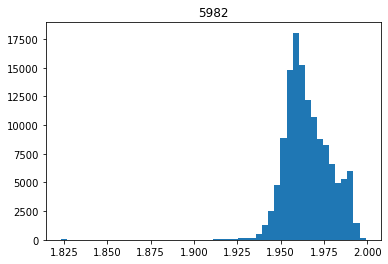

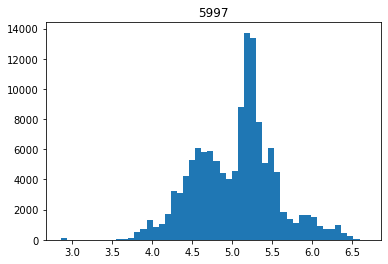

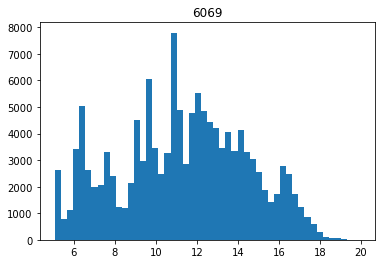

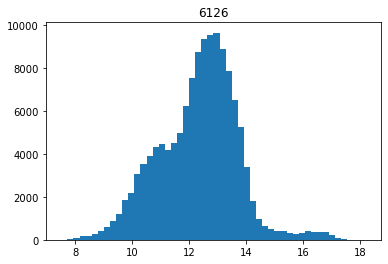

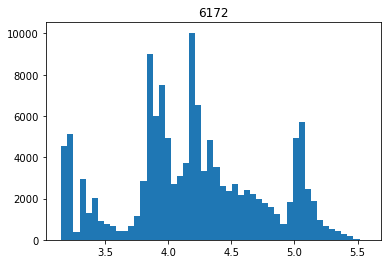

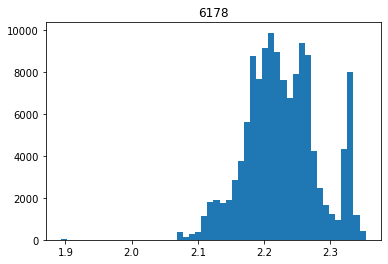

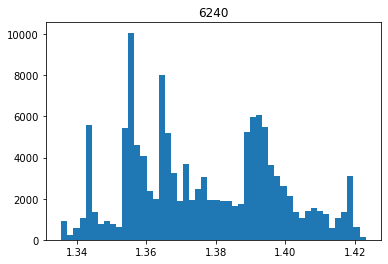

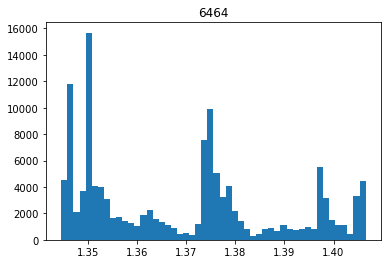

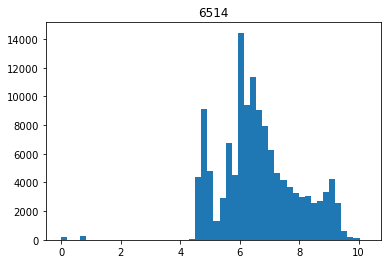

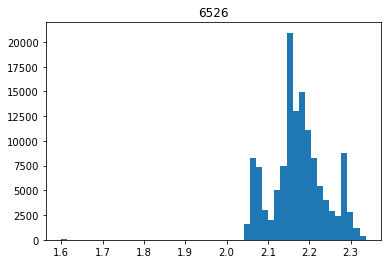

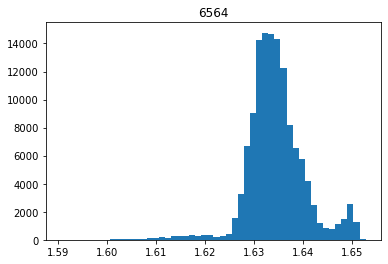

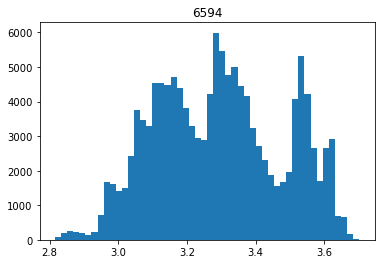

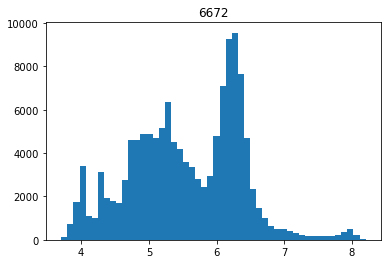

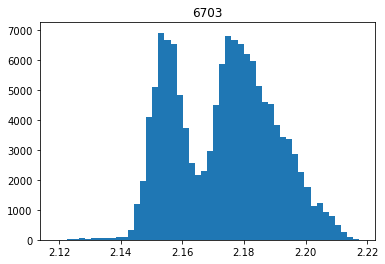

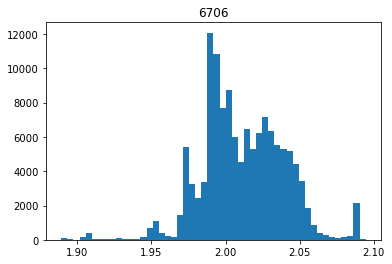

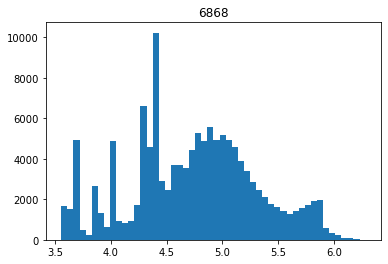

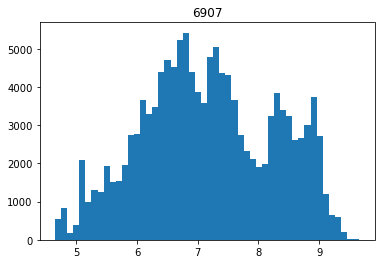

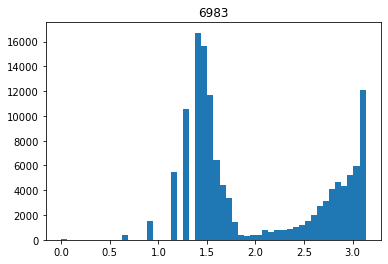

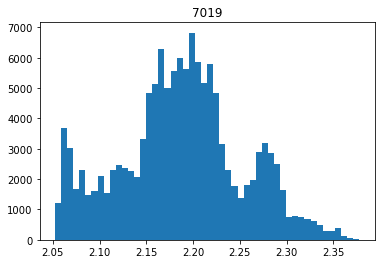

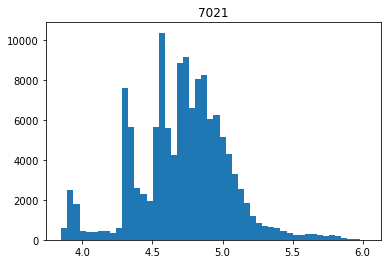

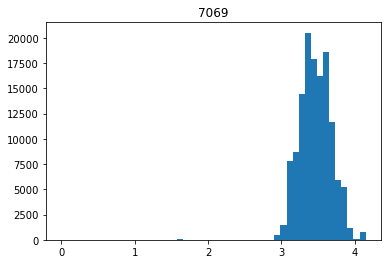

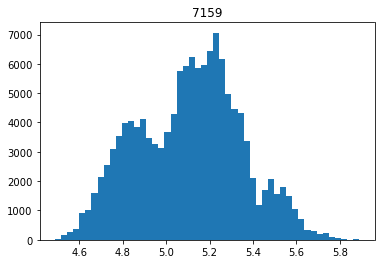

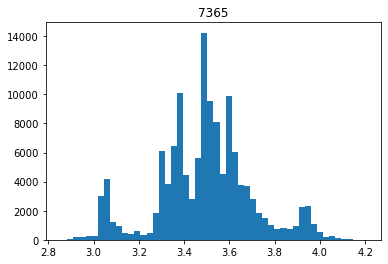

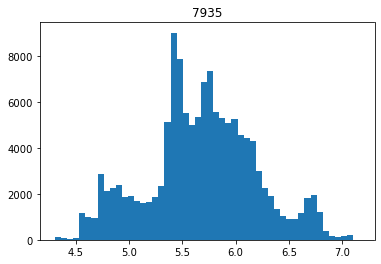

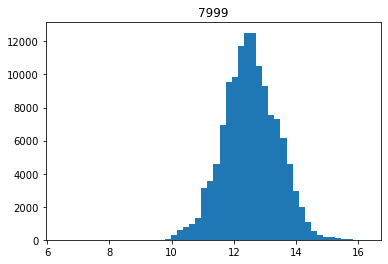

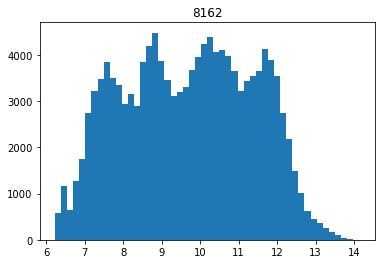

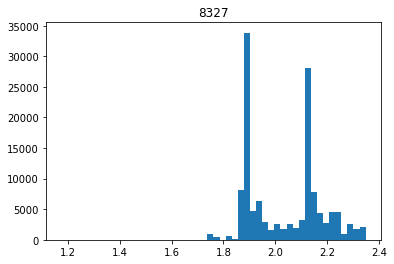

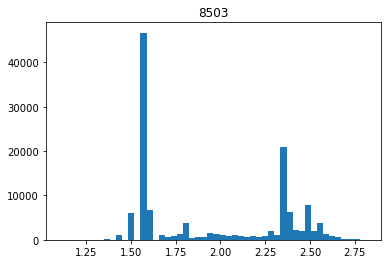

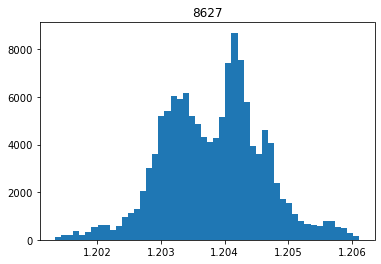

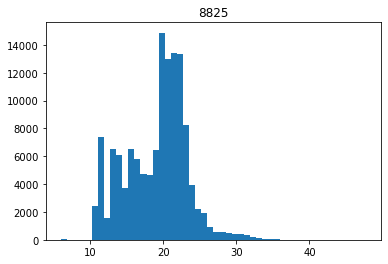

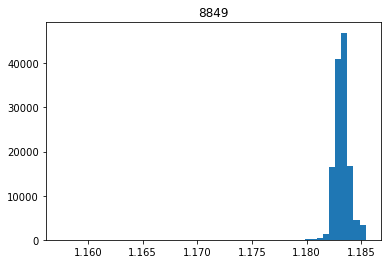

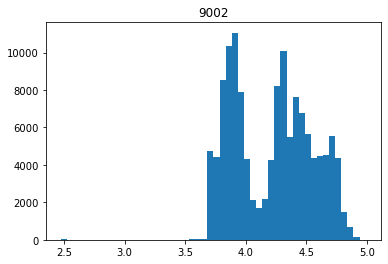

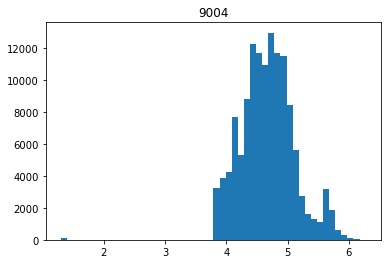

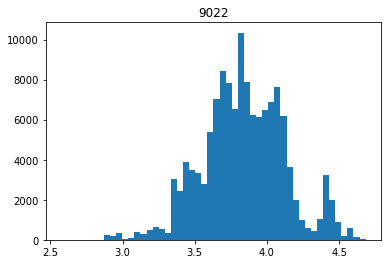

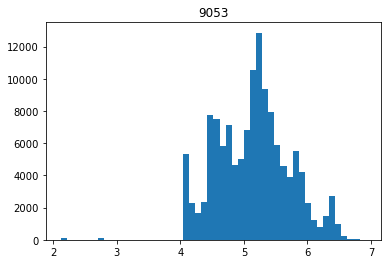

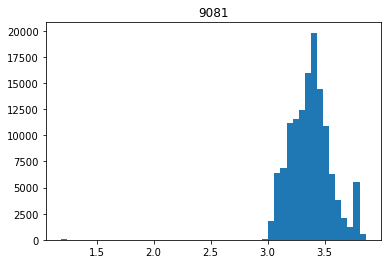

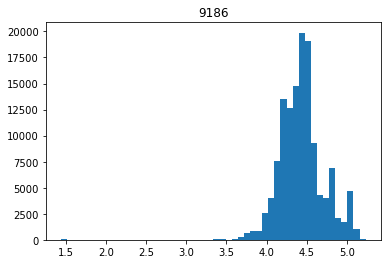

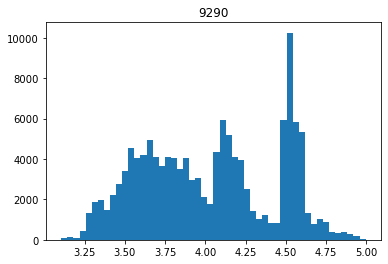

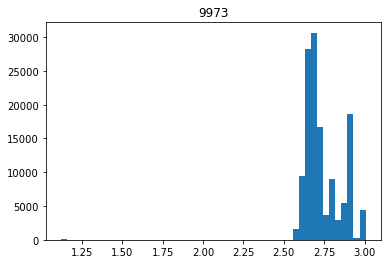

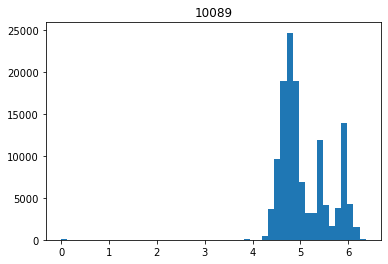

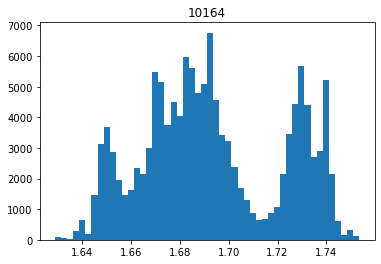

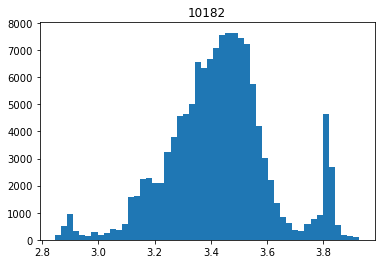

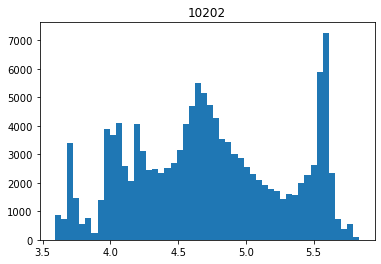

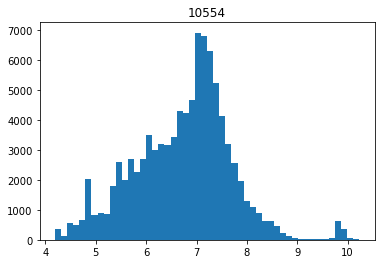

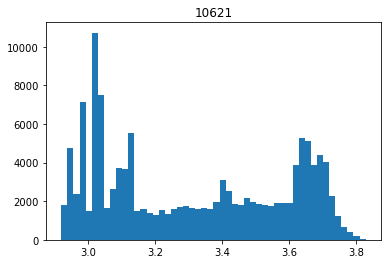

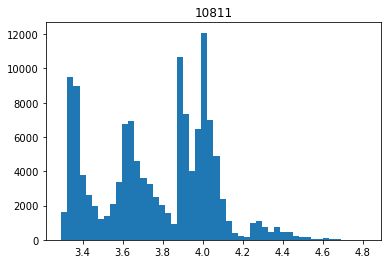

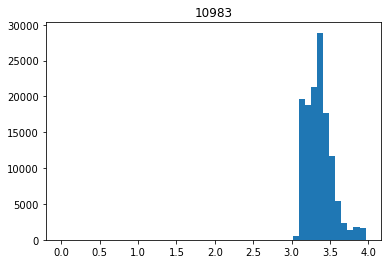

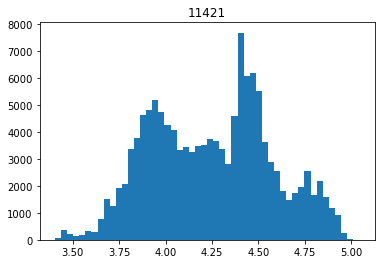

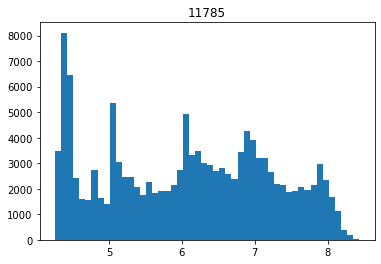

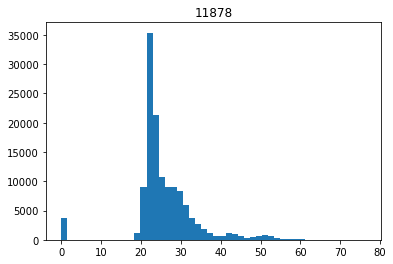

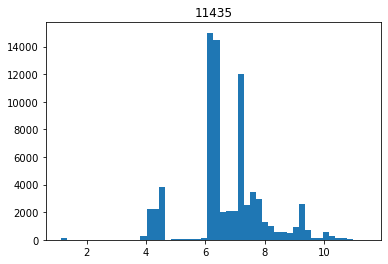

In [106]:
#Fixing skewness: Box cox for each home
skew_after_box_cox = []
for home in data_ids:
    plt.figure()
    plt.hist(stats.boxcox(grid.loc[grid.dataid == home].total_grid.values + 1)[0], bins = 50)
    plt.title(home)
    skew_after_box_cox.append(skew(pd.Series(stats.boxcox(grid.loc[grid.dataid == home].total_grid.values + 1)[0])))
    print("Home: ",
          home,
          "Skew: ",
          skew(pd.Series(stats.boxcox(grid.loc[grid.dataid == home].total_grid.values + 1)[0])),
          "Mean: ",
          np.mean(stats.boxcox(grid.loc[grid.dataid == home].total_grid.values + 1)[0])
         )

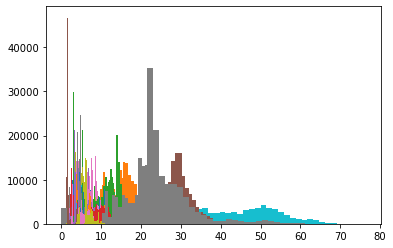

In [107]:
#Fixing skewness: Box cox overlapping histograms
for home in data_ids:
    plt.hist(stats.boxcox(grid.loc[grid.dataid == home].total_grid.values + 1)[0], bins = 50)

## Appliance power summary

In [108]:
df_fridge = load_all_houses_with_device(path, 'refrigerator1')

In [109]:
df_fridge_max = df_fridge.groupby(df_fridge.dataid).max().sort_values(by='appliance_power',ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

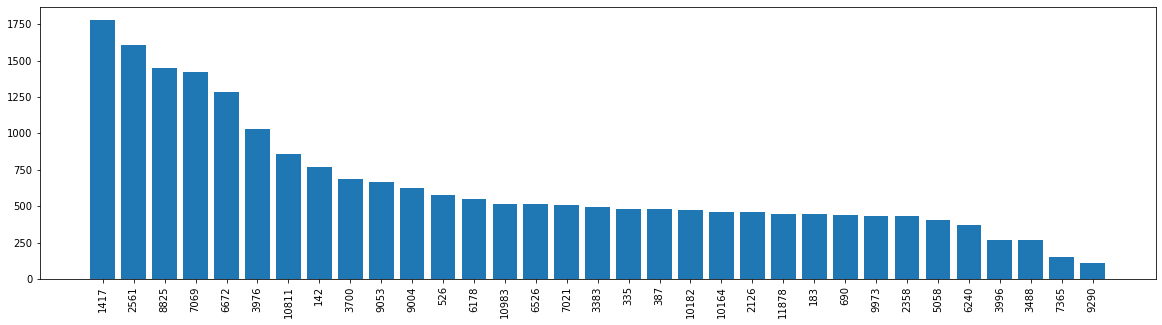

In [110]:
#Refrigerator max power per home
plt.figure(figsize=(20,5))
plt.bar(df_fridge_max.index.astype(str), df_fridge_max.appliance_power.values)
plt.xticks(rotation=90)

In [111]:
df_fridge_min = df_fridge.groupby(df_fridge.dataid).min().sort_values(by='appliance_power',ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

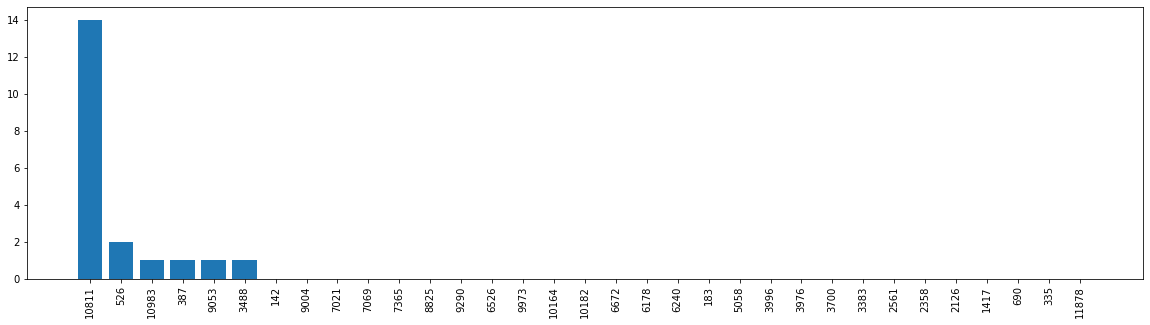

In [112]:
#Refrigerator min power per home
plt.figure(figsize=(20,5))
plt.bar(df_fridge_min.index.astype(str), df_fridge_min.appliance_power.values)
plt.xticks(rotation=90)

In [113]:
df_fridge_avg = df_fridge.groupby(df_fridge.dataid).mean().sort_values(by='appliance_power',ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

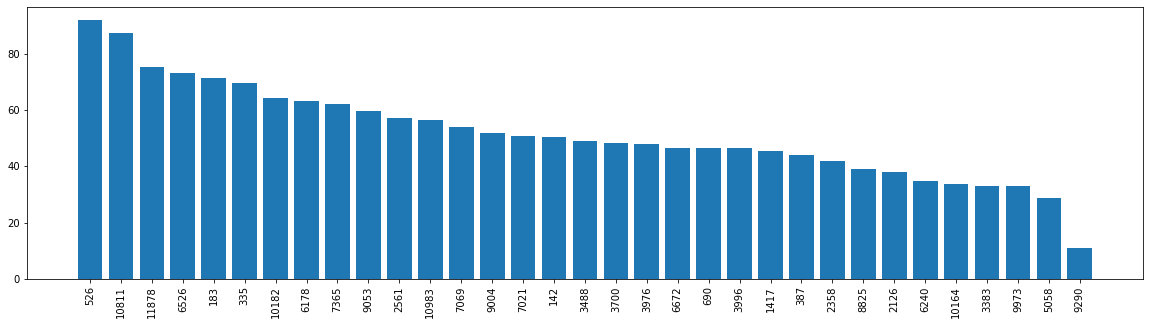

In [114]:
#Refrigerator mean power per home
plt.figure(figsize=(20,5))
plt.bar(df_fridge_avg.index.astype(str), df_fridge_avg.appliance_power.values)
plt.xticks(rotation=90)

In [115]:
fridge_ids = df_fridge.dataid.unique()

<ipython-input-116-3cdd620fc5d9>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


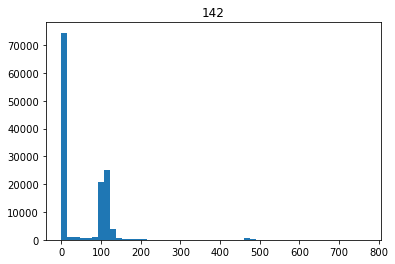

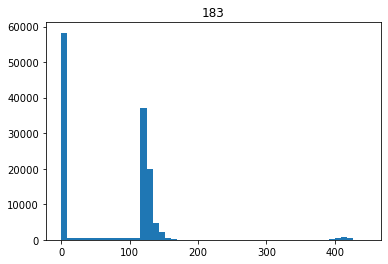

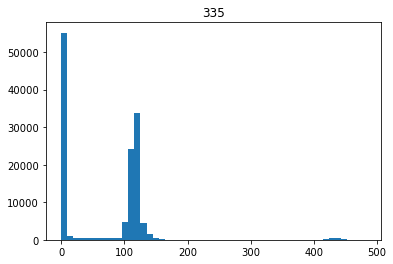

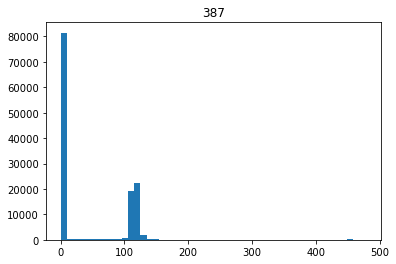

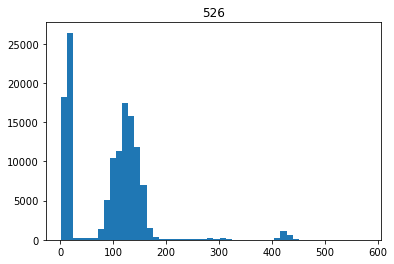

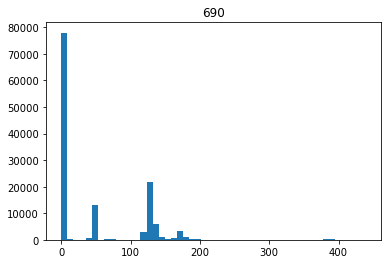

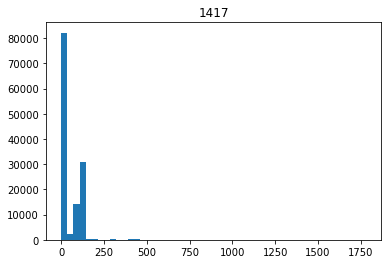

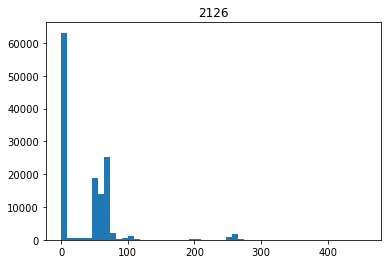

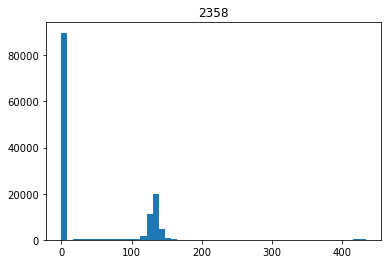

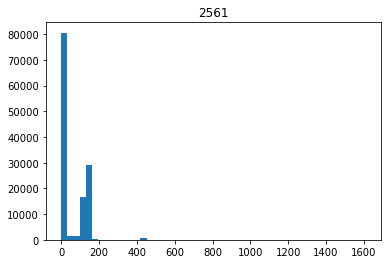

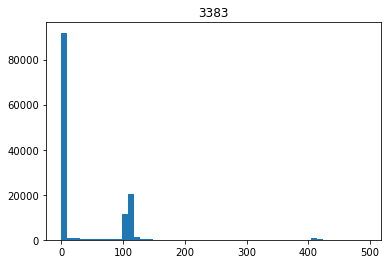

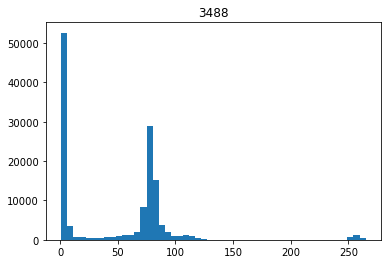

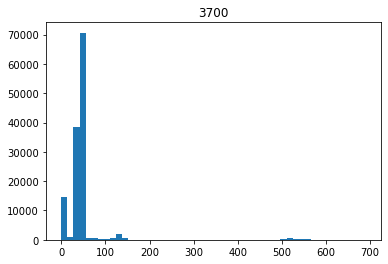

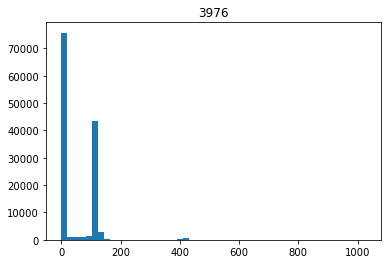

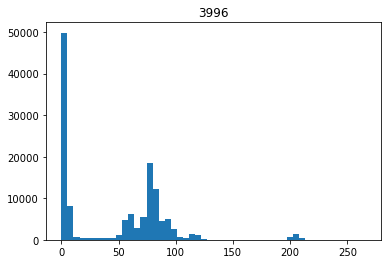

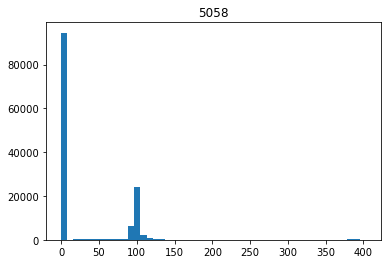

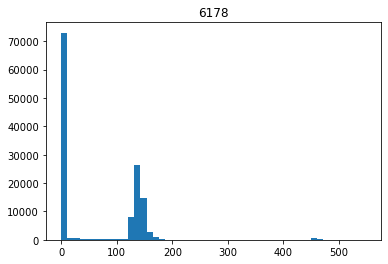

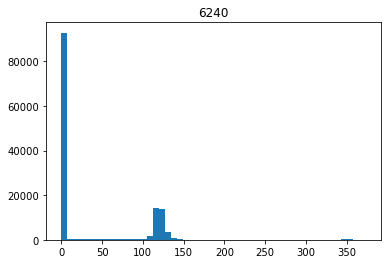

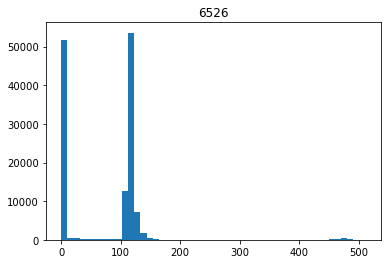

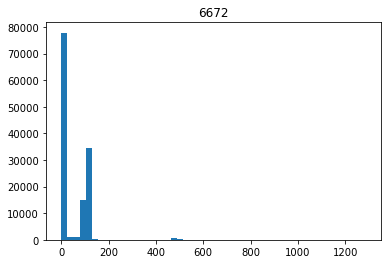

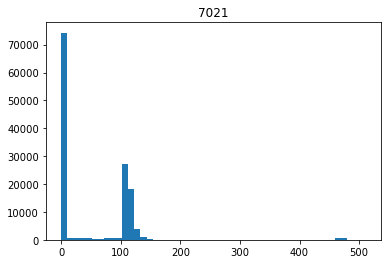

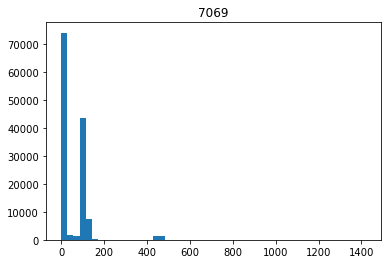

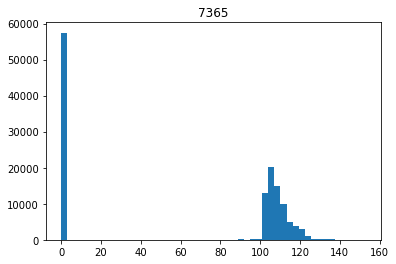

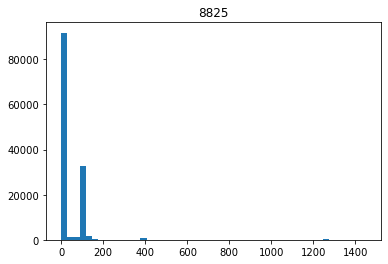

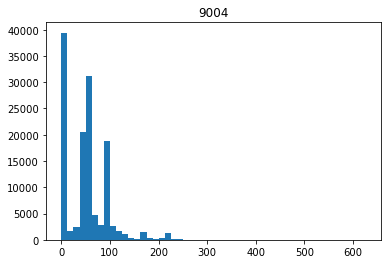

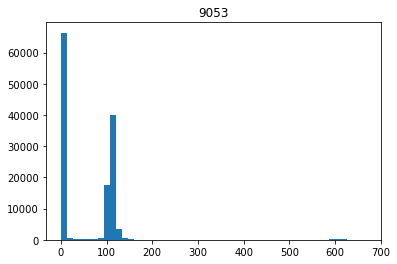

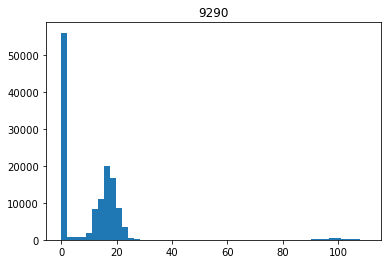

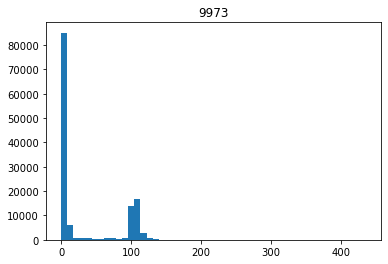

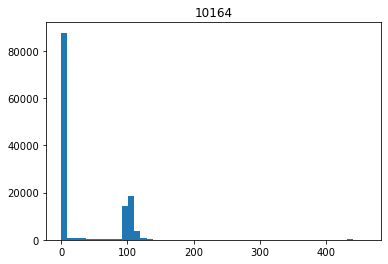

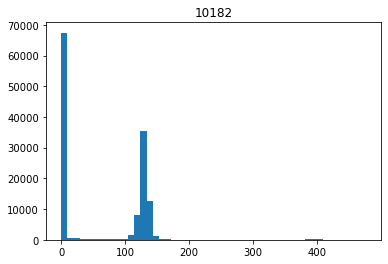

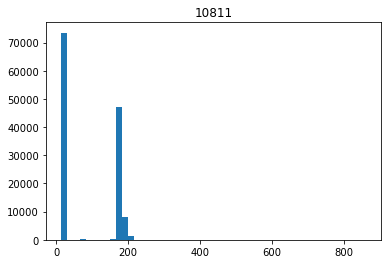

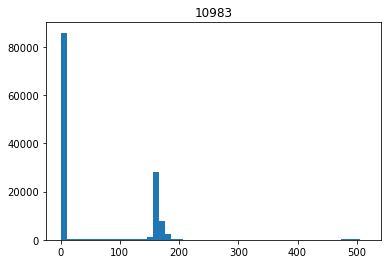

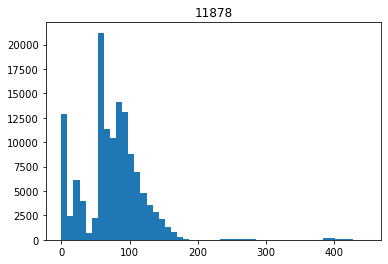

In [116]:
#Refrigerator histogram per home
for home in fridge_ids:
    plt.figure()
    plt.hist(df_fridge.loc[df_fridge.dataid == home].appliance_power.values, bins = 50)
    plt.title(home)

<ipython-input-117-8802bb71c68b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


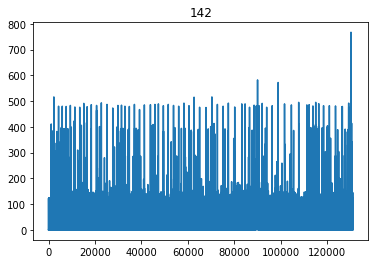

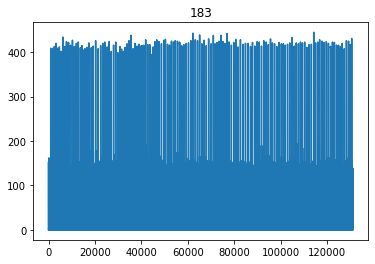

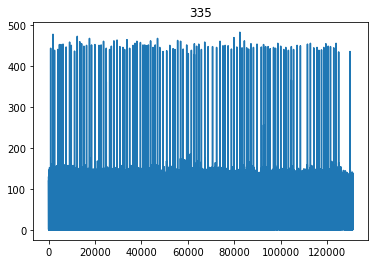

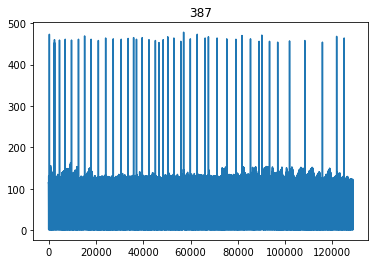

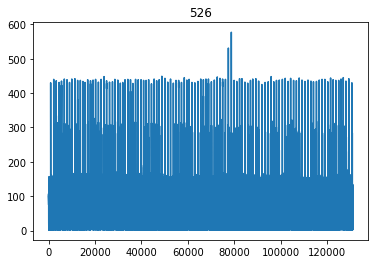

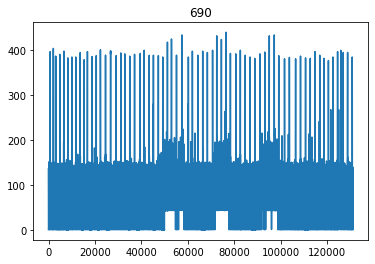

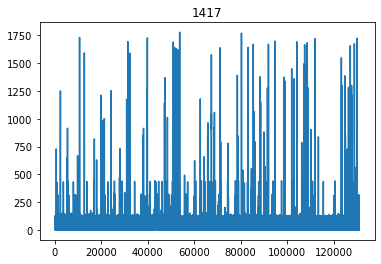

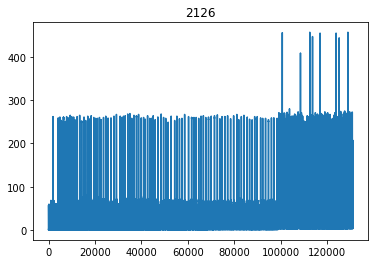

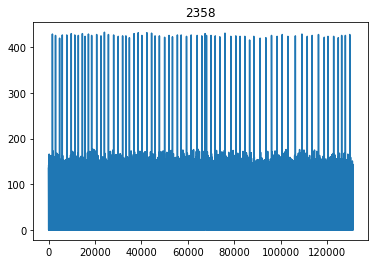

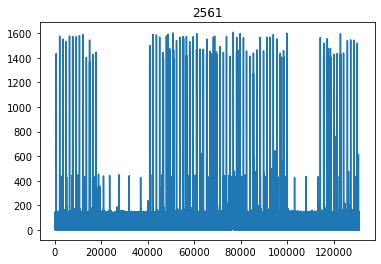

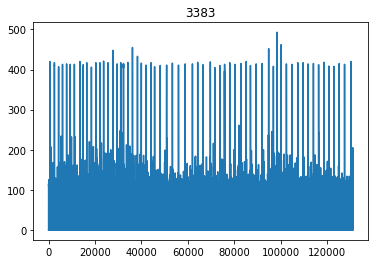

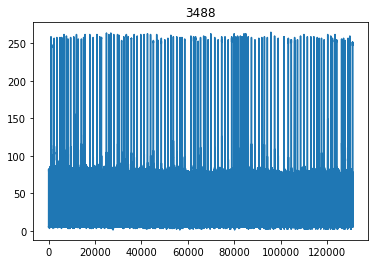

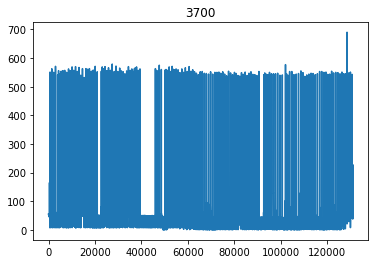

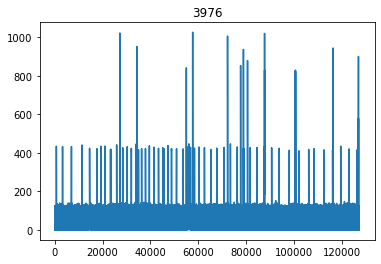

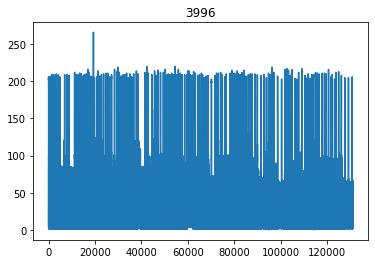

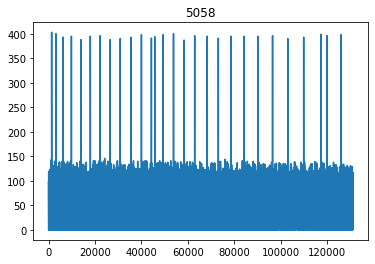

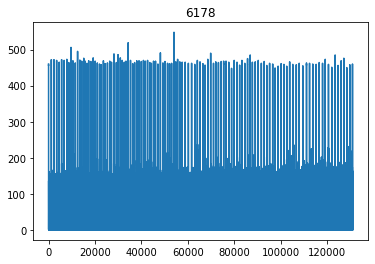

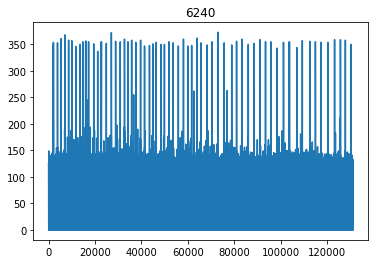

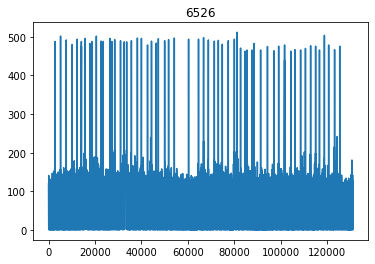

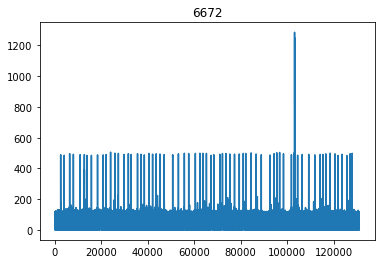

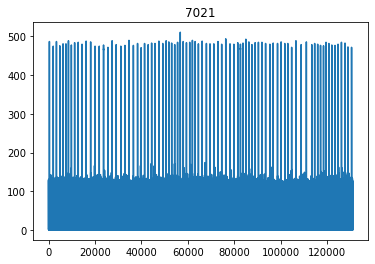

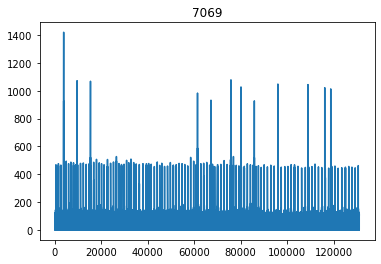

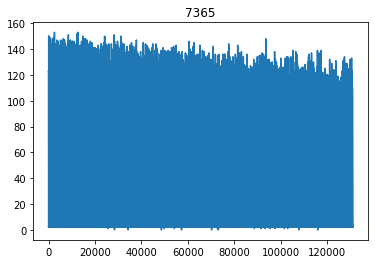

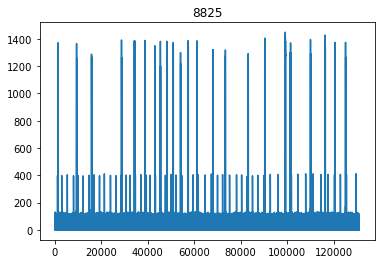

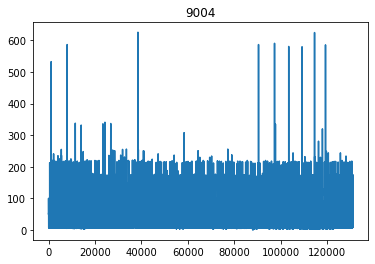

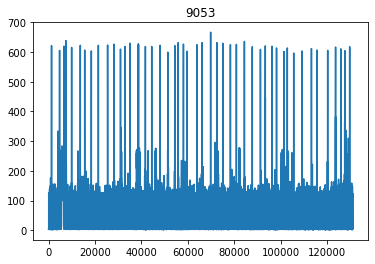

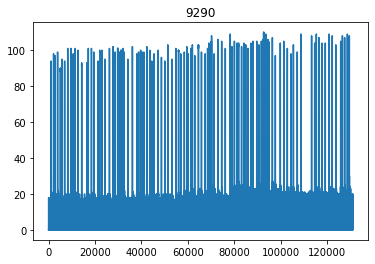

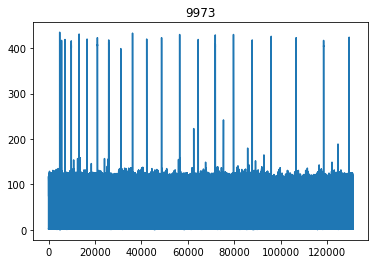

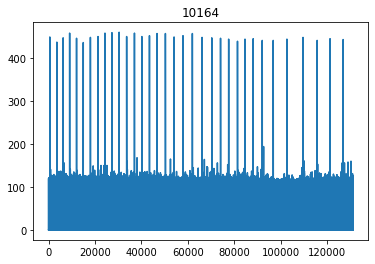

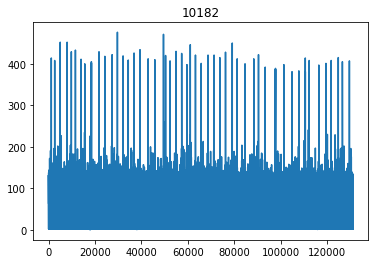

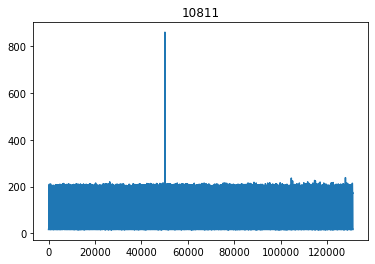

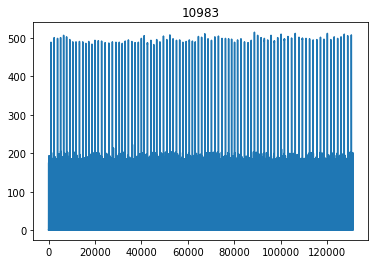

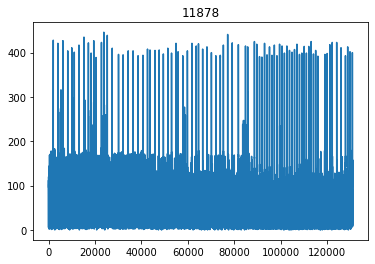

In [117]:
#Refrigerator time series per home
for home in fridge_ids:
    plt.figure()
    plt.plot(df_fridge.loc[df_fridge.dataid == home].appliance_power.values)
    plt.title(home)

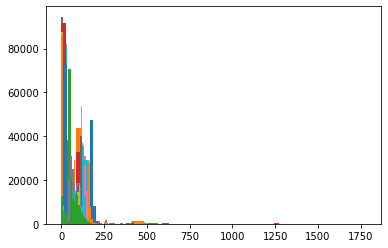

In [118]:
#Overlapping refrigerator histograms
for home in fridge_ids:
    plt.hist(df_fridge.loc[df_fridge.dataid==home].appliance_power.values, bins = 50)

In [119]:
fridge_off_count = []
total_lengths = []
for home in fridge_ids:
    df_per_house = df_fridge.loc[df_fridge.dataid == home][['appliance_power']]
    fridge_off_count.append(df_per_house[df_per_house.appliance_power < 5].count()[0])
    total_lengths.append(len(df_per_house))

In [120]:
off_fractions = pd.DataFrame([fridge_ids, [i / j for i, j in zip(fridge_off_count, total_lengths)]]).T

In [121]:
off_fractions = off_fractions.sort_values(by=1, ascending=False)

In [122]:
off_fractions[0] = off_fractions[0].astype('int32')

In [123]:
off_fractions[0] = off_fractions[0].astype('str')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

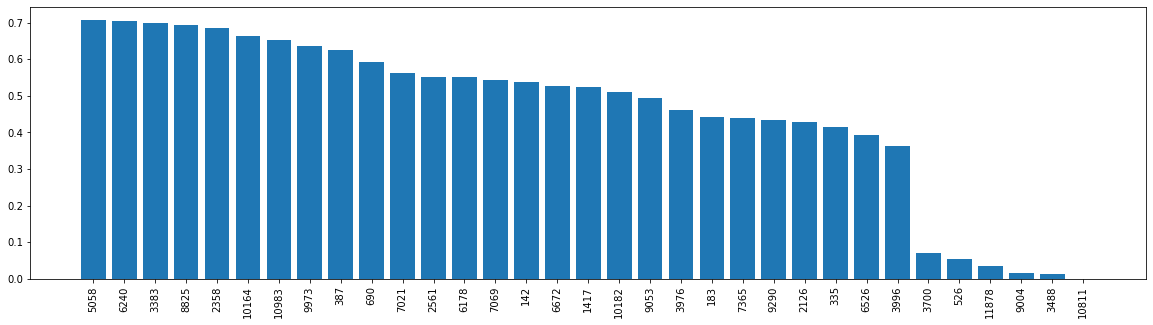

In [124]:
# % of time refrigerator is below 20W
plt.figure(figsize=(20,5))
plt.bar(off_fractions[0].values, off_fractions[1].values)
plt.xticks(rotation=90)

In [125]:
avg_agg = grid.groupby(grid.dataid).mean()

In [126]:
avg_app = df_fridge.groupby(df_fridge.dataid).mean()

In [127]:
homes_to_drop = list(set(avg_agg.index.unique()) - set(avg_app.index.unique()))

In [128]:
avg_agg = avg_agg.drop(index=homes_to_drop)

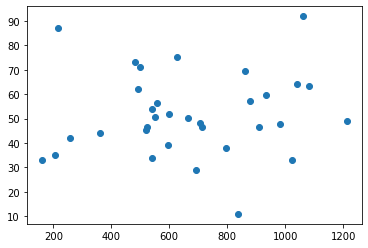

In [129]:
plt.scatter(avg_agg.total_grid.values, avg_app.appliance_power.values)

In [130]:
avg_agg.index

Int64Index([  142,   183,   335,   387,   526,   690,  1417,  2126,  2358,
             2561,  3383,  3488,  3700,  3976,  3996,  5058,  6178,  6240,
             6526,  6672,  7021,  7069,  7365,  8825,  9004,  9053,  9290,
             9973, 10164, 10182, 10811, 10983, 11878],
           dtype='int64', name='dataid')

In [131]:
X = np.array(list(list(a) for a in zip(avg_agg.total_grid.values, avg_app.appliance_power.values)))

In [132]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [133]:
label = kmeans.fit_predict(X)

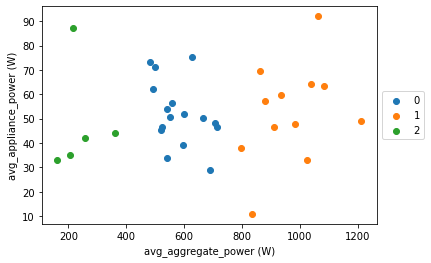

In [134]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(X[label == i , 0] , X[label == i , 1] , label = i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("avg_aggregate_power (W)")
plt.ylabel("avg_appliance_power (W)")
plt.show()

In [135]:
data = list(zip(avg_agg.index, label))

## Calculating averge energy

In [136]:
avg_agg_energy = grid.groupby(grid.dataid).mean()

In [137]:
avg_agg_energy = avg_agg_energy.drop(index=homes_to_drop)

In [138]:
avg_agg_energy['total_length'] = total_lengths

In [139]:
avg_agg_energy = avg_agg_energy.sort_values(by='total_grid', ascending=False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

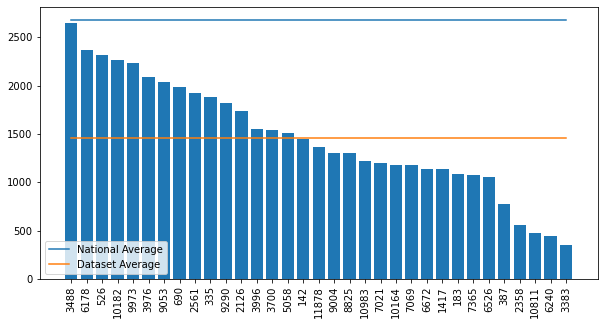

In [140]:
# kilowatthours consumed by each home for sept, oct, nov
plt.figure(figsize=(10,5))
plt.bar(avg_agg_energy.index.astype(str), avg_agg_energy.total_grid.values*avg_agg_energy.total_length.values/60/1000)
plt.plot(avg_agg_energy.index.astype(str), [2679]*len(avg_agg_energy))
plt.plot(avg_agg_energy.index.astype(str), [np.mean(avg_agg_energy.total_grid.values*avg_agg_energy.total_length.values/60/1000)]*len(avg_agg_energy))
plt.legend(['National Average', 'Dataset Average'])
plt.xticks(rotation=90)

In [ ]:
FL_results = [[0.06951961666345596, -1.0547907920686839, 0.7311992588450115, 0.7456100673854843, 0.45352463815322563, 19.315455238024395],
 [0.06750611960887909, -0.9061764415008356, 0.7431598779071023, 0.7048023497628592, 0.4403891934243316, 18.258307973543804],
 [0.04297441616654396, -0.6392584912691109, 0.8125841782201447, 0.4744438811163561, 0.2803518699064789, 12.290740092595419],
 [0.07527746260166168, -1.1321102858024428, 0.7133773582568644, 0.7908635820821566, 0.49108701108305475, 20.487773418426514],
 [0.06078772619366646, -0.9909178343987756, 0.7560586497334231, 0.6352026388321399, 0.3965604598159795, 16.4552876551946],
 [0.06729450821876526, -1.1279164035403797, 0.7078740864442855, 0.7361251794856674, 0.4390087399870242, 19.069743792215984],
 [0.03205053508281708, 0.2828068573659976, 0.7832790662095058, 0.42367462842894427, 0.20908782968145428, 10.975533564885458],
 [0.03972587361931801, 0.00046629515384349896, 0.7347972250315615, 0.48810910100089355, 0.2591594291053503, 12.644745429356893],
 [0.03881887346506119, 0.10475708558699538, 0.7167735279518588, 0.49345413640767144, 0.2532424364276869, 12.783211628595987],
 [0.044760655611753464, -0.1677143401281589, 0.6904550401939484, 0.540701311319558, 0.2920047632228599, 14.007176717122396],
 [0.04850225895643234, 0.05459620717059697, 0.7148736055951348, 0.5115025474377614, 0.3164138529907328, 13.250766038894653],
 [0.04988951236009598, 0.030102795840318237, 0.715130458322368, 0.5244570155533159, 0.32546384098156134, 13.586358944574991],
 [0.0633954107761383, -0.047742737008218315, 0.6740045526960716, 0.6332575540069433, 0.41357218055692735, 16.40489912033081],
 [0.06450808048248291, -0.09526510258711278, 0.6491365343570882, 0.6276351688916061, 0.42083087357915144, 16.25924801826477],
 [0.06549400091171265, -0.19760707133527125, 0.6671337254158477, 0.6168143856732332, 0.4272627511257778, 15.97892944018046],
 [0.05474377050995827, -0.1290505136790722, 0.696677594833347, 0.5843581071749195, 0.3571315516785887, 15.138130982716879],
 [0.06714557856321335, -0.1691848869123519, 0.6660485223422357, 0.6555396596983776, 0.43803713171654163, 16.9821298122406],
 [0.055342722684144974, -0.014301236927656094, 0.6970973325733955, 0.5805985456244764, 0.3610389377675811, 15.040737390518188],
 [0.059734467417001724, -0.03992679593688886, 0.6858098351038175, 0.5994954767458252, 0.38968928660048263, 15.530273199081421],
 [0.08048170059919357, -1.4764057743724204, 0.45971914384046236, 1.727740589820461, 0.5250378801530454, 44.758108139038086]]

In [ ]:
unwanted = {'dataid', 'leg1v', 'leg2v', 'grid', 'solar', 'solar2', "localminute"}

In [ ]:
appliances = [x for x in df.columns if x not in unwanted]